# Miniproject: Modelling the climate or the weather?
## Student ID: 18030750

### Machine Learning Tasks:
1. For a given station can you use the data to predict the weather (temperature, rainfall) one day in advance? 
2. For the previous task, can you predict for more than one day in advance? 
3. For a given station can you use the data to predict the climate (defined as the monthly average temperature, rainfall) one month in advance? 
4. For the previous task, can you predict for more than one month in advance? 

# Contents

1. IMPORTS AND CLASS DEFINITION

2. USEFUL FUNCTION DEFINITIONS

3. SET UP

4. DATA ANALYSIS

5. DATA PREPROCESSING

>5.1 Normalisation
   
>5.2 Monthly average
   
>5.3 Data conditioning

6. TIME SEQUENCES

7. MODEL STRUCTURE

8. DAILY AVERAGE TEMPERATURE PREDICTIONS
 
>8.1 Model structure

>>8.1.1 LSTM type and activation function

>>8.1.2 1 day in advance model structure

>>8.1.3 14 days in advance model structure

>>8.1.1 Windowsize
 
>8.2 One day in advance

>8.3 Comparison of different days in advance

9. MONTHLY AVERAGE TEMPERATURE PREDICTIONS

>9.1 Model structure

>>9.1.1 LSTM type and activation function

>>9.1.2 1 month in advance model structure

>>9.1.3 12 months in advance model structure

>>9.1.1 Windowsize

>9.2 One month in advance

>9.3 Comparison of different months in advance

10. DAILY RAINFALL PREDICTIONS

>10.1 Model structure

>>10.1.1 LSTM type and activation function

>>10.1.2 1 day in advance model structure

>>10.1.3 14 days in advance model structure

>>10.1.1 Windowsize
 
>10.2 One day in advance

>10.3 Comparison of different days in advance


11. MONTHLY RAINFALL PREDICTIONS

>11.1 Model structure

>>11.1.1 LSTM type and activation function

>>11.1.2 1 month in advance model structure

>>11.1.3 12 months in advance model structure

>>11.1.1 Windowsize

>11.2 One month in advance

>11.3 Comparison of different months in advance
 

12. SUMMARY AND FUTURE WORK

>12.1 Report figures



# 1. IMPORTS AND CLASS DEFINITION

In [2]:
# import the urllib library and essential libraries
import urllib.request
import numpy as np
import matplotlib.pyplot as plt 
from datetime import date,timedelta

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras
# Pandas library
import pandas as pd

# data conditioning libraries
from scipy.signal import medfilt
from scipy.ndimage import gaussian_filter1d

# other libraries
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
 
#Class that keeps information about station name and location
class Station():
    def __init__(self,sid,lat,lon,el,state,name,gsn,hcn,wmo,country):
        self.sid=sid
        self.lat=lat
        self.lon=lon
        self.el=el
        self.state=state
        self.name=name
        self.gsn=gsn
        self.hcn=hcn
        self.wmo=wmo
        self.country=country
        
    def __str__(self):
        return self.sid+" is "+self.name+", "+self.country+" at "+str(self.lat)+", "+str(self.lon)+", "+str(self.el)

#Class that hides some ugly reading routines
class GHNCD:
     
    #Class constructor
    def __init__(self): 
        self.station_col_len = [11,4,2,4]
        for i in range(31):
            self.station_col_len.append(5)
            self.station_col_len.append(3)
    
    # Split up the fixed length text arrays into fields
    def chunkstring(self,string, lengths):
        return (string[pos:pos+length].strip() 
                for idx,length in enumerate(lengths)
                for pos in [sum(map(int, lengths[:idx]))])

    # Process a file and extract all the information into a dictionary
    def processFile(self,fileName):
        outDict={} #
        with open(fileName, 'r') as fp: # Open file
            line = fp.readline()  #Read first line
            while line: # Process line
                fields = list(self.chunkstring(line, self.station_col_len)) #Get list of fields
                
                # For clarity use some variable names
                station=fields[0]  
                year=int(fields[1])
                month=int(fields[2])
                field=fields[3]
                vals=fields[4::2]
                flags=fields[5::2]
                # Not clear this is the only check we need, but for now
                def checkInt(x,flag):
                    if flag=='':
                        return -9999
                    return int(x)
                
                #Convert missing entries to -9999 using this swishy bit of string comprehension
                ivals=[checkInt(x,flag) for (x,flag) in zip(vals,flags)]
                monthDict=dict(year=year,month=month,field=field,vals=ivals,flags=flags)
                if field in outDict.keys():
                    outDict[field]['monthList'].append(monthDict)
                else:
                    fieldDict=dict(monthList=[monthDict])
                    outDict[field]=fieldDict
                line = fp.readline()
        return dict(outDict) #Return a copy
    
    def readCountriesFile(self,fileName=None):
        self.countryDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-countries.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            c=str(line[0:2], 'utf-8')
            d=str(line[3:-2], 'utf-8')                  
            self.countryDict[c]=d
        print("Read",len(self.countryDict),"countries and codes")
        
    
    def readStationsFile(self,fileName=None,justGSN=True):
        
        #------------------------------
        #Variable   Columns   Type
        #------------------------------
        #ID            1-11   Character
        #LATITUDE     13-20   Real
        #LONGITUDE    22-30   Real
        #ELEVATION    32-37   Real
        #STATE        39-40   Character
        #NAME         42-71   Character
        #GSN FLAG     73-75   Character
        #HCN/CRN FLAG 77-79   Character
        #WMO ID       81-85   Character
        #------------------------------
        self.stationDict={}
        if fileName==None:
            file = urllib.request.urlopen('http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd-stations.txt')
        else:
            file = open(fileName,'r')
        
        for line in file:
            sid=str(line[0:11], 'utf-8')
            lat=float(str(line[12:20], 'utf-8'))
            lon=float(str(line[21:30], 'utf-8'))
            el=float(str(line[31:37], 'utf-8'))
            state=str(line[38:40], 'utf-8')
            name=str(line[41:71], 'utf-8')
            gsn=str(line[72:75], 'utf-8')
            hcn=str(line[76:79], 'utf-8')
            wmo=str(line[80:85], 'utf-8')
            
           
            if justGSN:
                if gsn=='   ':
                    continue
            self.stationDict[sid]=Station(sid,lat,lon,el,state,name.rstrip(),gsn,hcn,wmo,self.countryDict[sid[0:2]])
        print("Read",len(self.stationDict),"stations with justGSN",justGSN)

    # Get all the data for a given variable type
    def getVar(self,statDict,varName='TMAX'):
        #The TMIN, TMAX, PRCP are all quoted in tenths (so need to be multipied by 0.1)
        cal=0.1
        if varName=='SNOW' or varName=='SNWD':
            cal=1.0
        tempList=[ (date(month['year'],month['month'],ind+1),cal*val)  for month in statDict[varName]['monthList'] for ind, val in enumerate(month['vals']) if val!=-9999   ]
        return tempList
    
    def getTMAX(self,statDict):
        return self.getVar(statDict,'TMAX')
    
    def printStation(self,sid):
        print(self.stationDict[sid])
        
    def getStation(self,sid):
        return self.stationDict[sid]
        
    def getStatKeyNames(self):
        #print(self.stationDict.keys())
        return [*self.stationDict.keys()]

# 2. USEFUL FUNCTION DEFINITIONS

In [2]:
def get_df(ghn,sid):
  '''Get dataframe of a station with all data from all variables using time as index
  This dataframe contains "holes" as NaN values
  Input: ghn: GHNCD class
         sid: station name, eg RSM00029866
  Output: dataframe_final: dataframe with columns as data for each variable
  '''
  # create filename and get url
  fileName=sid+'.dly'
  urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

  # Copy a network object to a local file
  urllib.request.urlretrieve(urlName,fileName)
  statDict=ghn.processFile(fileName)

  # get all variable names (TMAX,TMIN,etc)
  variables = [var for var,data in statDict.items()]

  # get all data for all variables
  variables_list = [ghn.getVar(statDict,variable) for variable in variables]

  # create a list containing one dataframe for each variable
  dataframe_list = [pd.DataFrame(variables_list[i],columns=['Time',variable]) for i,variable in enumerate(variables)]

  # set time as index for each dataframe in the list
  for i in range(len(variables)):
    dataframe_list[i].set_index('Time',inplace=True)
  
  # create final dataframe with all variables
  dataframe_final = pd.concat(dataframe_list,axis=1,sort=True)

  # set index dates to pandas datetime
  dataframe_final.index = pd.to_datetime(dataframe_final.index)

  return dataframe_final

In [3]:
def scale(data):
  '''Scale the data from 0 to 1
  Input: data: 1D array
  Outputs:
          data_scaled: scaled data 
          descale_object: MinMaxScaler object used to descaled back
  '''
  # reshape data since MinMaxScaler has as input array-like of shape (n_samples, n_features)
  data = data.reshape(len(data),1)
  # set range between 0 and 1
  min_max_scaler = MinMaxScaler(feature_range=(0,1))
  # scale data and reshape to 1D
  data_scaled = min_max_scaler.fit_transform(data)
  data_scaled = data_scaled.reshape(data_scaled.shape[0])
  # create object used to descale back
  descale_object = min_max_scaler.inverse_transform
  # return scaled data and descale object
  return data_scaled, descale_object

In [4]:
def descale(data,descale_object):
  '''Descale the data back
  Input: 
        data: 1D array
        descale_object: MinMaxScaler object used to descaled back
  Outputs: data_descaled: descaled data 
  '''
  # reshape data since MinMaxScaler has as input array-like of shape (n_samples, n_features)
  data = data.reshape(len(data),1)
  # descale data and reshape to 1D
  data_descaled = descale_object(data)
  data_descaled = data_descaled.reshape(data_descaled.shape[0])
  # return descaled data
  return data_descaled

In [5]:
def get_data_cond(data,sigma):
  ''''Get data after data conditioning. First median and then gaussian filter
  Inputs:
          data: data to be conditioned
          sigma: sigma of the gaussian filter
  Output: data_cond: data after data conditioning
  '''
  # create a copy of the data
  data_copy = data.copy()

  # data conditioning dataframe
  data_cond = pd.Series(data_copy.values)
  # median filter (medfilt) and gaussian filter (gaussian_filter1d)
  data_cond.update(gaussian_filter1d(medfilt(data.values),sigma))
  # copy the indices of the dataframe
  data_cond.index = data_copy.index

  return data_cond

In [6]:
def timeseqs(series,windowsize,offset):
  '''Function to convert a series with data values into a dataframe of windowsize values 
  with a target offset samples later
  There will be windowsize+1 columns in the final dataframe: windowsize number of 
  columns containing the windowsize values and 1 column containing the target
  Inputs:
          series: pandas series data
          windowsize: number of samples used in each sequence
          offset: represents number of days/months in advance
                  starting with 0, i.e. offset=0 represents 1 day/month in advance
                                        offset=1 represents 2 days/months in advance
  '''
  # create dataframe
  ts_df = pd.DataFrame()
  # loop to create windowsize columns
  for i in range(windowsize):
      #Shift the data by windowsize-i samples
      ts_df[i] = series.shift(windowsize-i) 
  # create target column
  ts_df['target'] = series.shift(-offset)
  # return dataframe without nan values
  ts_df.dropna(inplace=True)
  # change indices so that each row's index corresponds to the target's date
  ts_df.index = series.iloc[-len(ts_df):].index
    
  return ts_df

In [7]:
def get_train_and_test_data(data,train_end_date,windowsize):
  '''Get training and testing data ready to be inputed in keras models
  Inputs:
          data: data from timeseqs() function
          train_end_data: final date of training data
                          and first date of testing data
          windowsize: number of samples for each sequence
  Outputs:
          train_input,train_target: training data array (inputs+targets)
          test_input,test_target: testing data array (inputs+targets)
  
  '''
  # training data targets
  train_target=data.loc[:train_end_date].target.values
  # training data inputs and reshape
  train_input=data.loc[:train_end_date].drop('target',axis=1).values
  train_input=train_input.reshape(-1,windowsize,1)

  # testing data targets
  test_target=data.loc[train_end_date:].target.values
  # testing data inputs and reshape
  test_input=data.loc[train_end_date:].drop('target',axis=1).values
  test_input=test_input.reshape(-1,windowsize,1)

  return train_input,train_target,test_input,test_target

In [8]:
def model_lstm_act(method,n_neurons,windowsize,act_output,acts_hidden=[]):
  '''Create model to test the type of LSTM layer and the type of activation function
  Inputs:
          method: LSTM or Bi-LSTM (simple or bidirectional)
          n_neurons: number of LSTM/Bi-LSTM layer neurons
          windowsize: number of samples used in each sequence
          act_output: activation function for output dense layer
          act_hidden: activation functions for hidden dense layers
                      there are n_neurons/2 number of neurons in each layer
                      default: no hidden layer (empty list)
  Output: model
  '''

  # create model
  model=keras.models.Sequential()

  # type of LSTM layer with n_neurons number of neurons
  if method == 'LSTM':
    model.add(keras.layers.LSTM(n_neurons,input_shape=(windowsize,1),return_sequences=False)) 
  if method == 'Bi-LSTM':
    model.add(keras.layers.Bidirectional(keras.layers.LSTM(n_neurons,return_sequences=False),
                                         input_shape=(windowsize,1))) 
  
  # loop for each hidden dense layer activation function, if any
  # each hidden layer with n_neurons/2 number of neurons
  for acts_hidden in acts_hidden:
    model.add(keras.layers.Dense(int(n_neurons/2),activation=acts_hidden))
  
  # output dense layer with act_output activation function
  model.add(keras.layers.Dense(1,activation=act_output))
  # compile
  model.compile(loss='mean_squared_error',optimizer='adam')
  return model

In [9]:
def model_type(windowsize,lstm_neurons=[128],dense_neurons=[1],act=['sigmoid']):
  '''Create model used to test the model structure and used to do the final training
  Inputs:
          windowsize: number of samples used in each sequence
          lstm_neurons: list of LSTM neurons, e.g. [128,64] 128 neurons in the
                        first layer and 64 neurons in the second layer
                        default: [128], one LSTM layer
          dense_neurons: list of dense neurons, e.g. [128,64,1] 128 neurons in the
                         first hidden layer, 64 neurons in the second hidden layer
                         and 1 neuron in the output layer
                         default: [1], one output layer
          act: list of activation functions, e.g. [relu,relu,linear] relu activation
               functions in the first and second hidden layer and linear activation
               function in the output dense layer
               it must be of the same size as dense_neurons
               default: [sigmoid]
  Output: model
  '''
  # get the length of the neuron lists
  n_lstm = len(lstm_neurons)
  n_dense = len(dense_neurons)

  # create model
  model=keras.models.Sequential()

  # if one LSTM layer
  if n_lstm==1:
    model.add(keras.layers.LSTM(lstm_neurons[0],input_shape=(windowsize,1),return_sequences=False)) 
  # if more than one LSTM layer
  else:
    # first LSTM layer
    model.add(keras.layers.LSTM(lstm_neurons[0],input_shape=(windowsize,1),return_sequences=True)) 
    # loop for other LSTM layers, except the last one
    for i in range(n_lstm-2):
      model.add(keras.layers.LSTM(lstm_neurons[i+1],return_sequences=True)) 
    # final LSTM layer
    model.add(keras.layers.LSTM(lstm_neurons[-1],return_sequences=False)) 

  # loop for all dense layers, there is at least one dense layer (the output one)
  for i in range(n_dense):
    model.add(keras.layers.Dense(dense_neurons[i],activation=act[i]))
  
  # compile
  model.compile(loss='mean_squared_error',optimizer='adam')
  return model

In [10]:
def train_model(series,windowsize,offset,train_end_date,epochs,batchsize,
                lstm_neurons=[128],dense_neurons=[1],act=['sigmoid'],validation_split=0):
  '''Function used to train the model and get useful information
  It internally uses other functions, such as timeseqs() or model_type()
  Inputs:
          series: pandas series data
          windowsize: number of samples used in each sequence
          offset: represents number of days/months in advance
          train_end_data: final date of training data and first date of testing data
          epochs,batchsize: number of epochs and batch_size used in the training
          lstm_neurons: list of LSTM neurons, default: [128], one LSTM layer
          dense_neurons: list of dense neurons, default: [1], one output layer
          act: list of activation functions, default: [sigmoid]
          validation_split: validation data split used in the training, default: 0
  Outputs:
          history: history of the training
          test_predict: predictions of the testing data (predicted)
          test_target: targets of the testing data (actual)
          test_loss: mean squared error of the predictions
  '''
  # get time sequences data
  data = timeseqs(series,windowsize,offset)

  # get training and testing data
  train_input,train_target,test_input,test_target = get_train_and_test_data(data,
                                                    train_end_date,windowsize)

  # create model
  model = model_type(windowsize,lstm_neurons=lstm_neurons,dense_neurons=dense_neurons,act=act)
  
  # train model
  history=model.fit(train_input,train_target,epochs=epochs,batch_size=batchsize,
                    validation_split=validation_split,verbose=0)

  # calculate predictions
  test_predict = model.predict(test_input)
  # calculate test loss
  test_loss = model.evaluate(test_input,test_target,verbose=0)

  return history,test_predict,test_target,test_loss

In [11]:
def plot_subplot(df,predictions,targets,descale_var,title,ytitle,offset_array,frequency='days',n=None):
  ''''Create figure of 6 subplots showing predictions and original targets
  Each subplot shows predictions with different amount of time in advance
  Inputs:
          df: dataframe used to get indices (dates)
          predictions: list of predictions
                        predictions[i] are predictions of i-th subplot
          targets: original data
          descale_var: object used to descale back the predictions and targets
          title: main title of figure
          ytitle: main ylabel
          offset_array: array of offsets, eg offset_array=[0,1,2,3,4,5] represents
                        1 to 6 days/months in advance
                        1 day/month in advance for first subplot and so on
          frequency: days or months, default days
          n: number of data points to be plotted in each subplot
             default None, in which case use all data points
  '''
  # if n is None, use all data points
  if n == None:
    n = len(targets)

  # create figure
  fig = plt.figure(figsize=(15,15))
  # common title
  fig.suptitle(title,size=16)
  # common xlabel and ylabel
  fig.text(0.5,0.04, 'Prediction dates', ha="center", va="center",size=14)
  fig.text(0.05,0.5, ytitle, ha="center", va="center", rotation=90,size=14)

  # six subplots
  for i in range(6):
    ax = fig.add_subplot(231+i)
    # plot predictions and targets after descaling
    ax.plot(df.iloc[-n:].index,descale(targets[-n:],descale_var),'--',label='actual')
    ax.plot(df.iloc[-n:].index,descale(predictions[i][-n:],descale_var),label='prediction')
    # set subplot title 
    ax.set_title(f'{offset_array[i]+1} {frequency} in advance')
    # rotate x labels (dates)
    plt.setp(ax.get_xticklabels(), rotation=45)
    # set legend
    ax.legend()

# 3. SET UP

In [12]:
ghn=GHNCD()
ghn.readCountriesFile()
ghn.readStationsFile()

Read 219 countries and codes
Read 991 stations with justGSN True


In [13]:
# Get list of station names
statNames=ghn.getStatKeyNames()

# station name and filename
station='RSM00029866'
fileName=station+'.dly'
urlName='http://www.hep.ucl.ac.uk/undergrad/0056/other/projects/ghcnd/ghcnd_gsn/'+fileName

# Copy a network object to a local file
urllib.request.urlretrieve(urlName,fileName)
statDict=ghn.processFile(fileName)
print(ghn.getStation(station))

RSM00029866 is MINUSINSK, Russia at 53.7167, 91.7, 254.0


# 4. DATA ANALYSIS

This section is used to analyse the dataset. 

In [14]:
# get original DataFrame as df
# this dataframe contains holes (nan values)
df = get_df(ghn,station)

In [15]:
df

TMIN  PRCP  TAVG  TMAX  SNWD
1910-12-30 -18.9   0.0 -10.6   NaN   NaN
1912-04-14  -0.9   0.0   7.7   NaN   NaN
1912-04-28   0.6   0.0   4.7   NaN   NaN
1915-05-01   NaN   0.0  18.1   NaN   NaN
1915-05-02  10.5   0.8  16.4   NaN   NaN
...          ...   ...   ...   ...   ...
2020-11-09  -6.3   NaN   0.7   NaN   NaN
2020-11-10  -1.5   0.5   2.4   5.1   NaN
2020-11-11   NaN   0.0   0.8   5.6   NaN
2020-11-12  -4.3   0.0   0.8   4.5   NaN
2020-11-13   NaN   0.0  -3.6   2.9   NaN

[37938 rows x 5 columns]

In [16]:
# as it can be seen, there are different number of non-null values
# therefore, there are different number of nan values
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 37938 entries, 1910-12-30 to 2020-11-13
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMIN    37293 non-null  float64
 1   PRCP    37774 non-null  float64
 2   TAVG    37900 non-null  float64
 3   TMAX    33526 non-null  float64
 4   SNWD    1502 non-null   float64
dtypes: float64(5)
memory usage: 1.7 MB


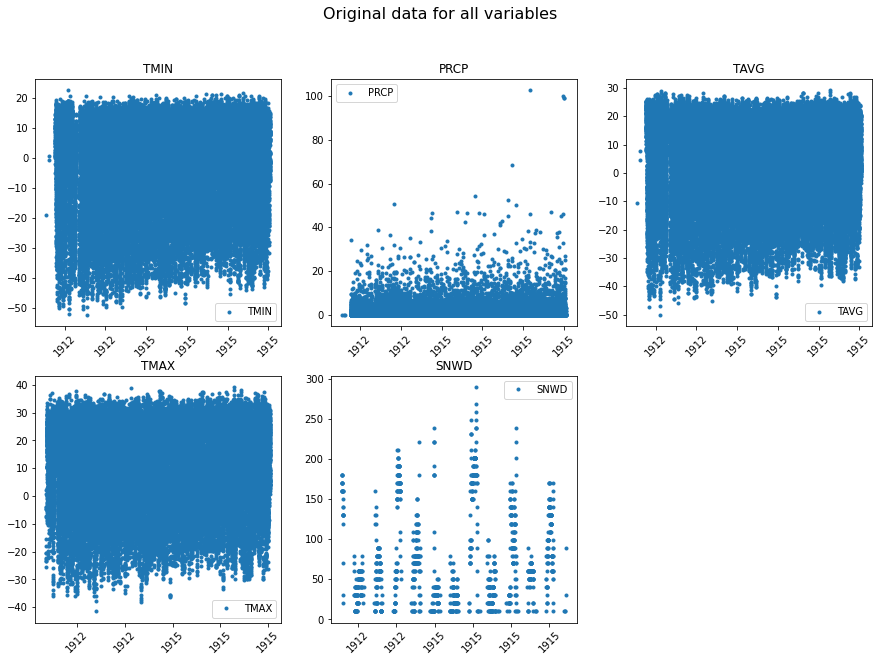

In [17]:
# create figure
fig = plt.figure(figsize=(15,10))
# common title
fig.suptitle('Original data for all variables',size=16)

# loop for each column (variable)
for i in range(len(df.columns)):
  ax = fig.add_subplot(231+i)
  # plot
  ax.plot(df.iloc[:,i],'.',label=df.columns[i])
  # set title 
  ax.set_title(df.columns[i])
  # rotate x labels (dates, only the year)
  ax.set_xticklabels(df.iloc[:,i].index.year, rotation=45)
  # set legend
  ax.legend()

In [18]:
# print the number of nan values per variable
for i in range(len(df.columns)):
  print(f'for {df.columns[i]}, {len(df.iloc[:,i][df.iloc[:,i].isnull()])} NaN values')

for TMIN, 645 NaN values
for PRCP, 164 NaN values
for TAVG, 38 NaN values
for TMAX, 4412 NaN values
for SNWD, 36436 NaN values


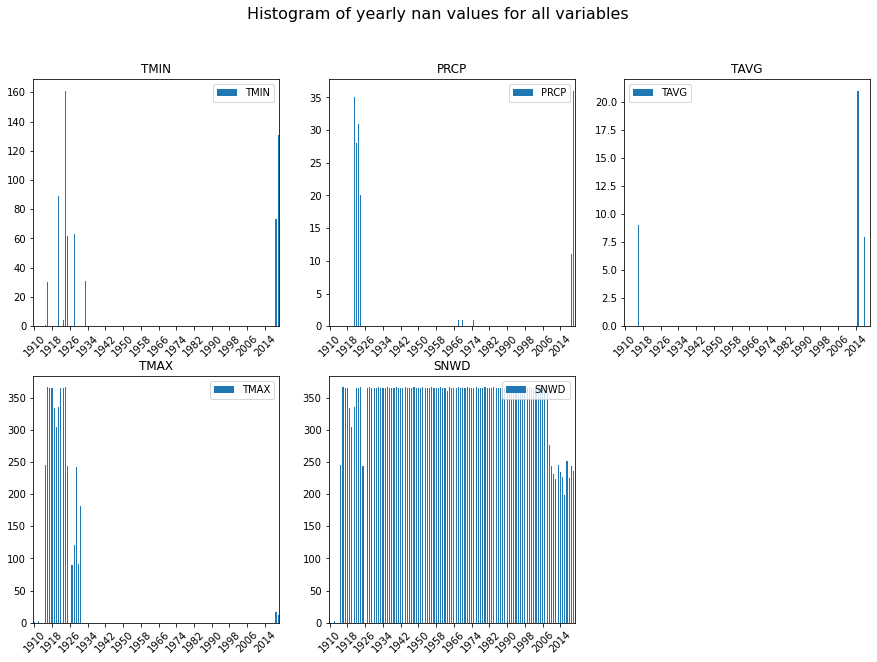

In [19]:
# the step of labels
n = 8

# create figure to plot the histogram of the nan values
fig = plt.figure(figsize=(15,10))
# common title
fig.suptitle('Histogram of yearly nan values for all variables',size=16)

# loop for each column (variable)
for i in range(len(df.columns)):
  ax_current = fig.add_subplot(231+i)

  # plot the nan values count per year
  ax = df.iloc[:,i].isnull().groupby(pd.Grouper(freq="Y")).sum().plot(ax=ax_current,kind="bar")
  
  # get x labels, only year
  ticks = ax.xaxis.get_ticklocs()
  # [:4] represents the year, first four characters
  ticklabels = [l.get_text()[:4] for l in ax.xaxis.get_ticklabels()]
  # the step of labels and rotation
  ax.xaxis.set_ticks(ticks[::n])
  ax.xaxis.set_ticklabels(ticklabels[::n], rotation=45)

  # title of subplot
  ax_current.set_title(df.columns[i])

  # set legend
  ax_current.legend()

  ax.figure.show()

In [20]:
# print the nan values dates from 1930 to 1940
for i in range(len(df.columns)):
  print(f'for {df.columns[i]}: {df.iloc[:,i][df.iloc[:,i].isnull()].loc[date(1930,1,1):date(1940,1,1)].index}')

for TMIN: DatetimeIndex(['1933-01-01', '1933-01-02', '1933-01-03', '1933-01-04',
               '1933-01-05', '1933-01-06', '1933-01-07', '1933-01-08',
               '1933-01-09', '1933-01-10', '1933-01-11', '1933-01-12',
               '1933-01-13', '1933-01-14', '1933-01-15', '1933-01-16',
               '1933-01-17', '1933-01-18', '1933-01-19', '1933-01-20',
               '1933-01-21', '1933-01-22', '1933-01-23', '1933-01-24',
               '1933-01-25', '1933-01-26', '1933-01-27', '1933-01-28',
               '1933-01-29', '1933-01-30', '1933-01-31'],
              dtype='datetime64[ns]', freq=None)
for PRCP: DatetimeIndex([], dtype='datetime64[ns]', freq=None)
for TAVG: DatetimeIndex([], dtype='datetime64[ns]', freq=None)
for TMAX: DatetimeIndex(['1930-10-01', '1930-10-02', '1930-10-03', '1930-10-04',
               '1930-10-05', '1930-10-06', '1930-10-07', '1930-10-08',
               '1930-10-09', '1930-10-10',
               ...
               '1931-06-21', '1931-06-22', '19

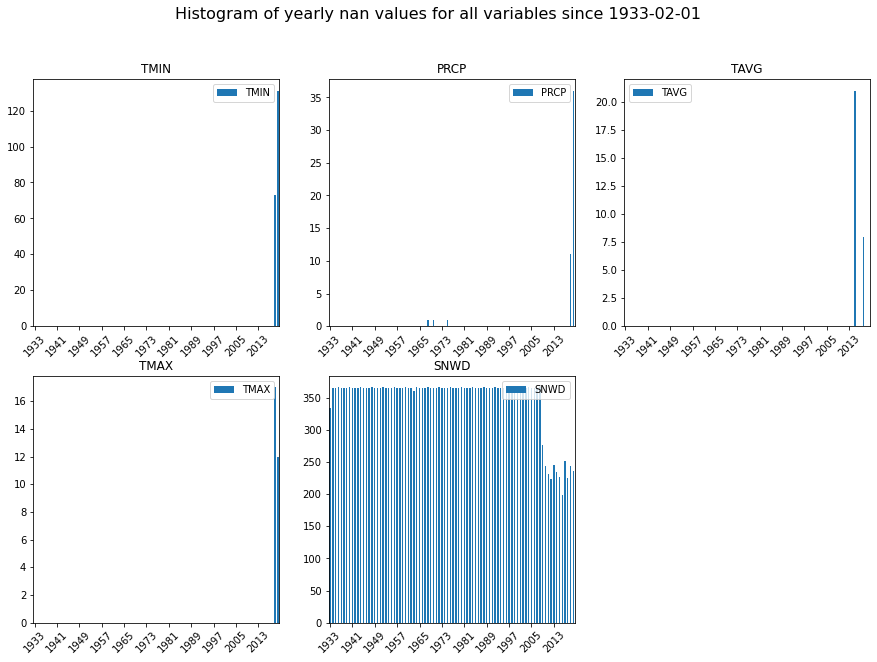

In [21]:
# create figure to plot the histogram of the nan values since 1933-02-01
fig = plt.figure(figsize=(15,10))
# common title
fig.suptitle('Histogram of yearly nan values for all variables since 1933-02-01',size=16)

# loop for each column (variable)
for i in range(len(df.columns)):
  ax_current = fig.add_subplot(231+i)
  # plot the nan values count per year since 1933-02-01
  ax = df.iloc[:,i].loc[date(1933,2,1):].isnull().groupby(pd.Grouper(freq="Y")).sum().plot(ax=ax_current,kind="bar")
  # get x labels, the dates
  ticks = ax.xaxis.get_ticklocs()
  # [:4] represents the year, first four characters
  ticklabels = [l.get_text()[:4] for l in ax.xaxis.get_ticklabels()]
  # the step of labels and rotation
  ax.xaxis.set_ticks(ticks[::n])
  ax.xaxis.set_ticklabels(ticklabels[::n], rotation=45)

  # title of subplot
  ax_current.set_title(df.columns[i])
  # set legend
  ax_current.legend()

  ax.figure.show()

Use only the first four variables (ignore SNWD) as the SNWD has too many nan values. At beginning, the other four variables also contain some nan values, specially tmax. Therefore, I have decided to use data from 1933-02-01, since 1933-01-31 is the last date from the other four variables that has a significant amount of consecutive nan values (look tmin nan values from 1930 to 1940). Notice also that for the last years (after around 2015), there is a relatively big amount of nan values. Let's analyse them.

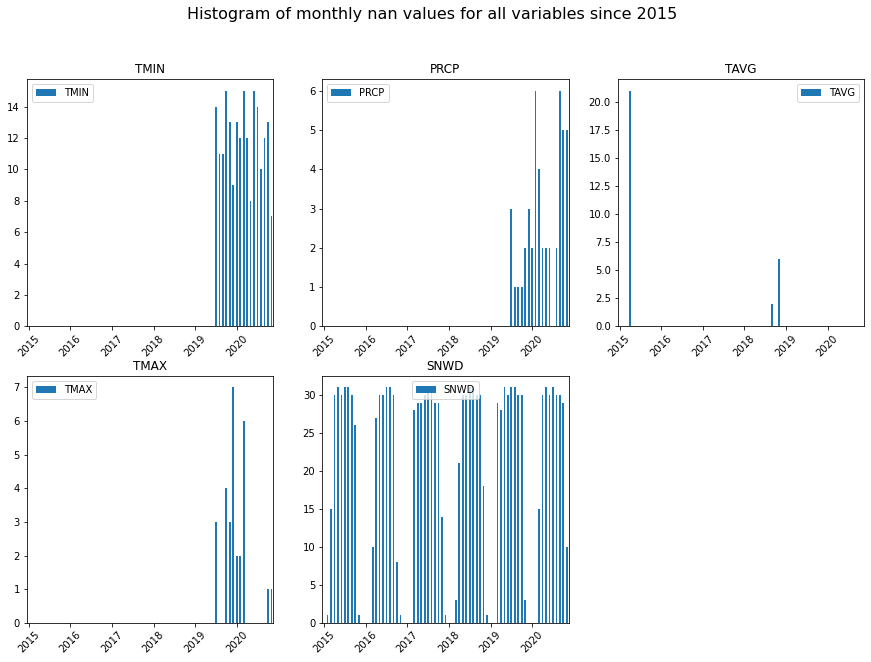

In [22]:
# the step of labels
n = 12

# create figure to plot the histogram of the nan values since 2015
fig = plt.figure(figsize=(15,10))
# common title
fig.suptitle('Histogram of monthly nan values for all variables since 2015',size=16)

for i in range(len(df.columns)):
  ax_current = fig.add_subplot(231+i)

  # plot the nan values count per year since 2015
  ax = df.iloc[:,i].loc[date(2015,1,1):].isnull().groupby(pd.Grouper(freq="M")).sum().plot(ax=ax_current,kind="bar")
  
  # get x labels, only year
  ticks = ax.xaxis.get_ticklocs()
  # [:4] represents the year, first four characters
  ticklabels = [l.get_text()[:4] for l in ax.xaxis.get_ticklabels()]
  # the step of labels and rotation
  ax.xaxis.set_ticks(ticks[::n])
  ax.xaxis.set_ticklabels(ticklabels[::n], rotation=45)

  # title of subplot
  ax_current.set_title(df.columns[i])
  # set legend
  ax_current.legend()

  ax.figure.show()

We can use interpolation to get rid of the nan values, but for tmin, it seems that nearly half of the values are nan since summer of 2019. Let's see what happens if we use interpolation for tmin.

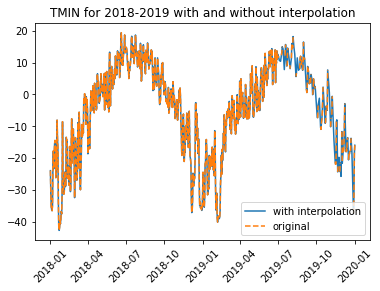

In [23]:
# plot figure comparing tmin with and without interpolation for 2018 and 2019
plt.plot(df['TMIN'].loc[date(2018,1,1):date(2020,1,1)].interpolate(),label='with interpolation')
plt.plot(df['TMIN'].loc[date(2018,1,1):date(2020,1,1)],'--',label='original')
plt.xticks(rotation=45)
plt.title('TMIN for 2018-2019 with and without interpolation')
plt.legend()

At these scales, we see that interpolation works well. In summary, for this station, we will use data since 1933-02-01, we will drop the snow variable and we will use interpolation to handle the nan values for the rest of variables

# 5. DATA PREPROCESSING

After data analysing, I will preprocess the data as summarised in the previous section.

In [24]:
# get original DataFrame as df
# this dataframe contains holes (nan values)
df = get_df(ghn,station)

In [25]:
# drop SNWD column
df.drop('SNWD',axis=1,inplace=True)

# drop rows before 1933-02-01
df.drop(df.loc[:date(1933,1,31)].index,inplace=True)

# interpolate nan values
df.interpolate(inplace=True)

In [26]:
# dataframe after preprocessing
df

TMIN  PRCP  TAVG   TMAX
1933-02-01 -36.0   0.2 -25.1 -18.40
1933-02-02 -29.6   0.3 -24.6 -16.10
1933-02-03 -32.4   0.1 -17.3 -10.10
1933-02-04 -31.5   0.2 -23.8 -14.90
1933-02-05 -40.1   0.0 -32.1 -20.80
...          ...   ...   ...    ...
2020-11-09  -6.3   0.5   0.7   7.25
2020-11-10  -1.5   0.5   2.4   5.10
2020-11-11  -2.9   0.0   0.8   5.60
2020-11-12  -4.3   0.0   0.8   4.50
2020-11-13  -4.3   0.0  -3.6   2.90

[32058 rows x 4 columns]

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32058 entries, 1933-02-01 to 2020-11-13
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   TMIN    32058 non-null  float64
 1   PRCP    32058 non-null  float64
 2   TAVG    32058 non-null  float64
 3   TMAX    32058 non-null  float64
dtypes: float64(4)
memory usage: 1.2 MB


Actually, for this project, I will only use TAVG (average temperature) and PRCP (precipitation). TMAX and TMIN are similar to TAVG, so there is no need to waste time to do these variables.

## 5.1 Normalisation

Create a new dataframe scaled from 0 to 1. For this, I will use MinMaxScaler() from sklearn library. 

In [28]:
# set range from 0 to 1
min_max_scaler_all = MinMaxScaler(feature_range=(0,1))
# scale the whole dataframe (all four variables)
# this scales each variable from 0 to 1
data_scaled_all = min_max_scaler_all.fit_transform(df.values)

In [29]:
# create scaled dataframe
df_scaled = pd.DataFrame(data_scaled_all)
# set index
df_scaled.index = df.index
# set column names
df_scaled.columns = df.columns

In [30]:
df_scaled

TMIN      PRCP      TAVG      TMAX
1933-02-01  0.190141  0.001949  0.271141  0.285891
1933-02-02  0.280282  0.002924  0.277852  0.314356
1933-02-03  0.240845  0.000975  0.375839  0.388614
1933-02-04  0.253521  0.001949  0.288591  0.329208
1933-02-05  0.132394  0.000000  0.177181  0.256188
...              ...       ...       ...       ...
2020-11-09  0.608451  0.004873  0.617450  0.603342
2020-11-10  0.676056  0.004873  0.640268  0.576733
2020-11-11  0.656338  0.000000  0.618792  0.582921
2020-11-12  0.636620  0.000000  0.618792  0.569307
2020-11-13  0.636620  0.000000  0.559732  0.549505

[32058 rows x 4 columns]

In [31]:
# create objects used to descaled back
# for example, descale(array,descale_tavg) will descale array according to TAVG
_, descale_tmin = scale(df['TMIN'].to_numpy())
_, descale_prcp = scale(df['PRCP'].to_numpy())
_, descale_tavg = scale(df['TAVG'].to_numpy())
_, descale_tmax = scale(df['TMAX'].to_numpy())

## 5.2 Monthly average

I will crete monthly averaged (scaled) dataset.

In [32]:
# create monthly averaged dataframe
df_month = df.groupby(pd.Grouper(freq='M')).mean()

In [33]:
# dataframe without scaling
df_month

TMIN      PRCP       TAVG       TMAX
1933-02-28 -35.032143  0.432143 -26.771429 -18.921429
1933-03-31 -25.193548  0.596774 -16.119355  -7.780645
1933-04-30  -2.986667  0.376667   3.890000  10.253333
1933-05-31   2.054839  0.664516   9.990323  16.093548
1933-06-30   9.230000  2.076667  16.790000  23.266667
...               ...       ...        ...        ...
2020-07-31  11.115054  1.532258  19.503226  25.790323
2020-08-31   9.466111  0.866667  17.806667  25.033333
2020-09-30   2.413333  2.015000  10.370000  18.233333
2020-10-31  -3.765054  0.867742   3.077419   8.096774
2020-11-30  -4.148718  0.715385   0.730769   5.788462

[1054 rows x 4 columns]

Scale the monthly averaged dataframe from 0 to 1

In [34]:
# set range from 0 to 1
min_max_scaler_all = MinMaxScaler(feature_range=(0,1))
# scale the whole dataframe (all four variables)
data_scaled_all = min_max_scaler_all.fit_transform(df_month.values)
# create scaled dataframe
df_month_scaled = pd.DataFrame(data_scaled_all)
# set index
df_month_scaled.index = df_month.index
# set column names
df_month_scaled.columns = df_month.columns

In [35]:
# create objects used to descaled back the monthly averaged variables
# for example, descale(array,descale_month_tavg) will descale array according to monthly TAVG
_, descale_month_tmin = scale(df_month['TMIN'].to_numpy())
_, descale_month_prcp = scale(df_month['PRCP'].to_numpy())
_, descale_month_tavg = scale(df_month['TAVG'].to_numpy())
_, descale_month_tmax = scale(df_month['TMAX'].to_numpy())

## 5.3 Data conditioning

Data conditioning is the use of data management and optimization techniques which result in the intelligent routing, optimization and protection of data for storage or data movement in a computer system (Wikipedia). The importance of this in LSTM time series predictions is also explained here:
https://www.rs-online.com/designspark/predicting-weather-using-lstm. In a few words, it is just to pass the data into a filter and return the trends. I will use a median filter, followed by a gaussian filter. I have imported these filters from scipy library.

In [36]:
# set sigma for gaussian filter
sigma = 1
# daily TAVG data conditioning dataframe
df_tavg_cond =  get_data_cond(df_scaled['TAVG'],sigma)

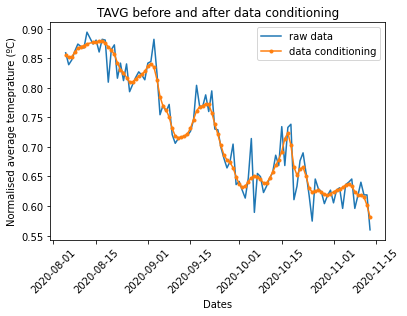

In [37]:
# plot data before and after data conditioning
plt.plot(df_scaled['TAVG'].iloc[-100:],label='raw data')
plt.plot(df_tavg_cond.iloc[-100:],'.-',label='data conditioning')
plt.xticks(rotation=45)
plt.title('TAVG before and after data conditioning')
plt.ylabel('Normalised average temeprature (ºC)')
plt.xlabel('Dates')
plt.legend()

In [38]:
# set sigma for gaussian filter
sigma = 0.5
# monthly TAVG data conditioning dataframe
df_month_tavg_cond =  get_data_cond(df_month_scaled['TAVG'],sigma)

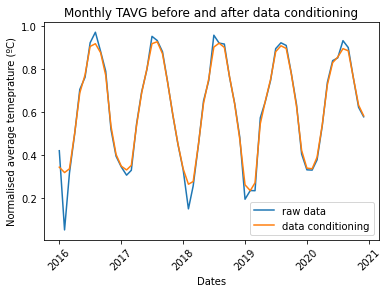

In [39]:
# plot data before and after data conditioning
plt.plot(df_month_scaled['TAVG'].iloc[-60:],label='raw data')
plt.plot(df_month_tavg_cond.iloc[-60:],label='data conditioning')
plt.title('Monthly TAVG before and after data conditioning')
plt.ylabel('Normalised average temeprature (ºC)')
plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.legend()

In [40]:
# set sigma for gaussian filter
sigma = 0.5
# daily PRCP data conditioning dataframe
df_prcp_cond =  get_data_cond(df_scaled['PRCP'],sigma)

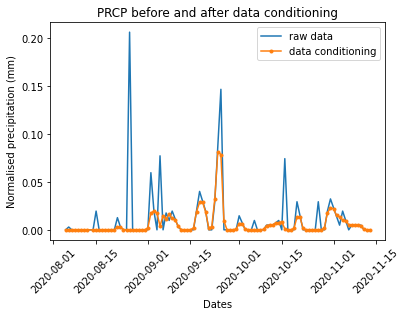

In [41]:
# plot data before and after data conditioning
plt.plot(df_scaled['PRCP'].iloc[-100:],label='raw data')
plt.plot(df_prcp_cond.iloc[-100:],'.-',label='data conditioning')
plt.xticks(rotation=45)
plt.title('PRCP before and after data conditioning')
plt.ylabel('Normalised precipitation (mm)')
plt.xlabel('Dates')
plt.legend()

In [42]:
# set sigma for gaussian filter
sigma = 0.5
# monthly PRCP data conditioning dataframe
df_month_prcp_cond =  get_data_cond(df_month_scaled['PRCP'],sigma)

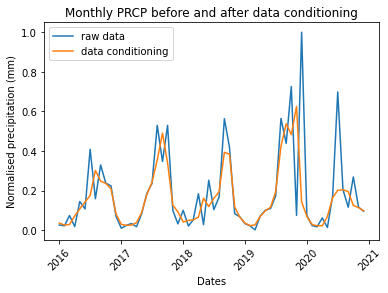

In [43]:
# plot data before and after data conditioning
plt.plot(df_month_scaled['PRCP'].iloc[-60:],label='raw data')
plt.plot(df_month_prcp_cond.iloc[-60:],label='data conditioning')
plt.title('Monthly PRCP before and after data conditioning')
plt.ylabel('Normalised precipitation (mm)')
plt.xlabel('Dates')
plt.xticks(rotation=45)
plt.legend()

The sigma for gaussian filter was set to 1 for daily temperature and 0.5 otherwise. I have tested for different sigma, the smaller sigma, the more similar to the original data. I found that the above sigma works the best for each case.

# 6. TIME SEQUENCES

I will show one example of time sequences data. The windowsize is the history length used to predict. The offset is the amount of time in advance to predict. Note that it starts from offset=0. For daily predictions, offset=0 is to predict one day in advance; offset=1 is to predict two days in advance and so on.

In [ ]:
# days in the history used to predict
windowsize = 10
# days in advace = offset + 1
# offset = 0 means one day in advance
offset = 0
data = timeseqs(df_scaled.TAVG,windowsize,offset)

In [ ]:
data

0         1         2  ...         8         9    target
1933-02-11  0.271141  0.277852  0.375839  ...  0.163758  0.181208  0.344966
1933-02-12  0.277852  0.375839  0.288591  ...  0.181208  0.344966  0.413423
1933-02-13  0.375839  0.288591  0.177181  ...  0.344966  0.413423  0.416107
1933-02-14  0.288591  0.177181  0.155705  ...  0.413423  0.416107  0.363758
1933-02-15  0.177181  0.155705  0.144966  ...  0.416107  0.363758  0.315436
...              ...       ...       ...  ...       ...       ...       ...
2020-11-09  0.617450  0.626846  0.605369  ...  0.645638  0.595973  0.617450
2020-11-10  0.626846  0.605369  0.626846  ...  0.595973  0.617450  0.640268
2020-11-11  0.605369  0.626846  0.630872  ...  0.617450  0.640268  0.618792
2020-11-12  0.626846  0.630872  0.595973  ...  0.640268  0.618792  0.618792
2020-11-13  0.630872  0.595973  0.636242  ...  0.618792  0.618792  0.559732

[32048 rows x 11 columns]

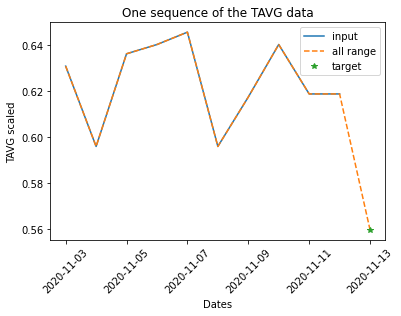

In [ ]:
# plot input and target of the last sequence (2020-11-13 sequence)
n = -1

# plot the input data
plt.plot(data.iloc[n-offset-windowsize:n-offset].index,
         data.iloc[n].drop('target'),label='input')

# plot all the data
plt.plot(df_scaled.TAVG.loc[data.iloc[n-offset-windowsize].name:],'--',label='all range')

# plot the target
plt.plot(data.iloc[n].name,
         data['target'].iloc[n],'*',label='target')

plt.xticks(rotation=45)
plt.title('One sequence of the TAVG data')
plt.xlabel('Dates')
plt.ylabel('TAVG scaled')
plt.legend()

Here I will show an example of training and testing data. I have also created a function based on the following code. I have set a training end date, which is the last date of the training data and the first date of testing data.

In [ ]:
# training data end date
train_end_date = date(2020,9,30)

# training data targets
train_target=data.loc[:train_end_date].target.values
# training data inputs
train_input=data.loc[:train_end_date].drop('target',axis=1).values
train_input=train_input.reshape(-1,windowsize,1)
print(train_input.shape)
print(train_target.shape)

# testing data targets
test_target=data.loc[train_end_date:].target.values
# testing data inputs
test_input=data.loc[train_end_date:].drop('target',axis=1).values
test_input=test_input.reshape(-1,windowsize,1)
print(test_input.shape)
print(test_target.shape)

(32004, 10, 1)
(32004,)
(45, 10, 1)
(45,)


# 7. MODEL STRUCTURE

One can vary the model in many ways: number of LSTM layers, number of neurons in the LSTM layers, number of dense layers, number of neurons in the dense layers, activation functions in the dense layers, etc.

In this project I will choose the structure in the following way:


1.   Type of layer and activation functions
2.   Number of neurons in a single LSTM layer
3.   Add second LSTM layer and see if loss decreases. If it decreases, try a third LSTM layer and so on.
4.   Add a hidden dense layer and see if loss decreases. If it decreases, try a second hidden dense layer and so on.

However, as I am interested in testing the predictions for different days/months in advance, I can't choose the optimal configuration for each day/month in advance. For example, for daily predictions, I will test from 1 day to 14 days in advance. I can't choose 14 optimal configurations. Instead, I will test for two cases: 1 day in advance and 14 days in advance, the two extremes, and then choose a configuration that optimises these two cases and assume that it optimises for all cases. This last assumption is not bad. According to this paper https://arxiv.org/pdf/1707.06799.pdf, the number of LSTM layers has a medium impact on the performance and the number of LSTM neurons has a low impact (as long as it is not far too large or far too small). 

Moreover, I am not interested in the optimal configuration for each time in advance. Optimising this will only lower the losses. But it won't change the fact that we can predict or not successfully. For example, for daily temperature predictions, we definitely can't predict 30 days in advance. Therefore, it does not really matter if the test loss is 0.025 or 0.029. The important thing is that we can't predict well.



In the first point when I say type of layer, I mean standard LSTM layer or bidirectional LSTM layer. The reason why one wants to use bidirectional layers is explained here https://stackoverflow.com/questions/43035827/whats-the-difference-between-a-bidirectional-lstm-and-an-lstm. In a few words, the standard LSTM layer goes to one direction and the Bi-LSTM goes to both directions.

When choosing the configuration, one thing that can be varied is the amount of history (windowsize). However, I will show that the amount of history has a small impact on the results. 

First notice that more history (larger windowsize) does not necesarily give a way smaller test loss. This is shown in the following paper https://www.mdpi.com/2076-3417/10/5/1609/htm. I will give an example using daily temperature predictions.

In [ ]:
# days in the history used to predict
windowsize_1 = 5
# days in the history used to predict
windowsize_2 = 120
# 1 day in advance
offset = 0
# training data end date
train_end_date = date(2020,1,1)

In [ ]:
# parameters of the model and training
epochs=10
batchsize=100
lstm_neurons=[128]

# get history, targets, predictions and test loss using 5 days to predict
history_1,test_predict_1,test_target_1,test_loss_1 = train_model(df_scaled['TAVG'],windowsize_1,
                                                         offset,train_end_date,epochs,batchsize,lstm_neurons)
# get history, targets, predictions and test loss using 120 days to predict
history_2,test_predict_2,test_target_2,test_loss_2 = train_model(df_scaled['TAVG'],windowsize_2,
                                                         offset,train_end_date,epochs,batchsize,lstm_neurons)

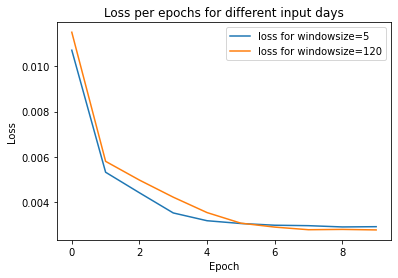

In [ ]:
# plot loss per epochs
plt.plot(history_1.history['loss'], label=f'loss for windowsize={windowsize_1}')
plt.plot(history_2.history['loss'], label=f'loss for windowsize={windowsize_2}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss per epochs for different input days')
plt.legend()

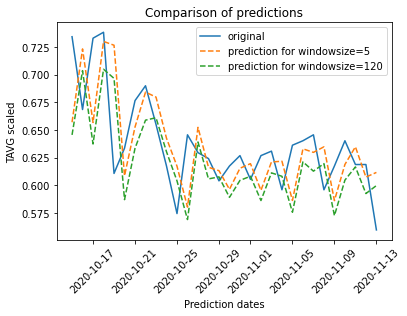

In [ ]:
# plot the predictions and the actual values
plt.plot(df.iloc[-30:].index,test_target_1[-30:],label='original')
plt.plot(df.iloc[-30:].index,test_predict_1[-30:],'--',label=f'prediction for windowsize={windowsize_1}')
plt.plot(df.iloc[-30:].index,test_predict_2[-30:],'--',label=f'prediction for windowsize={windowsize_2}')
plt.xticks(rotation=45)
plt.title('Comparison of predictions')
plt.xlabel('Prediction dates')
plt.ylabel('TAVG scaled')
plt.legend()

In [ ]:
print(f'test loss for windowsize={windowsize_1}: {test_loss_1}')
print(f'test loss for windowsize={windowsize_2}: {test_loss_2}')

test loss for windowsize=5: 0.0020650988444685936
test loss for windowsize=120: 0.001977168722078204


As it can be seen, the losses ar very close. Therefore, I won't struggle too much about the size of the window. I will check the windowsize's effect for some cases and then use it for all cases.

# 8. DAILY AVERAGE TEMPERATURE PREDICTIONS

## 8.1 Model structure

I will use the data after data conditioning to construct the model. In fact, I have tried to do this section with original data, it turns out that all models give very similar losses, the model can't be improved/optimised. We will see in the next sections that this is because the data without data conditioning fails to predict daily temperatures, even for a very complex model. Therefore, we should contruct the model based on data after data conditioning because this is the data that can be used to successfully predict.

### 8.1.1 LSTM type and activation function

In [ ]:
# days in the history used to predict
windowsize = 20
# 1 day in advance
offset = 0
# get time sequences data
data = timeseqs(df_tavg_cond,windowsize,offset)
# training data end date
train_end_date = date(2020,1,1)
# get training and testing data
train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)

LSTM linear test loss = 0.0002553189406171441
LSTM relu test loss = 0.503567636013031
LSTM sigmoid test loss = 0.00022966261894907802
Bi-LSTM linear test loss = 9.073838009499013e-05
Bi-LSTM relu test loss = 6.324626156128943e-05
Bi-LSTM sigmoid test loss = 0.00018626751261763275


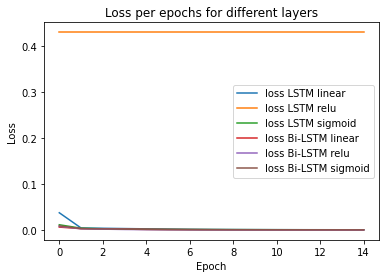

In [ ]:
# number of LSTM neurons
neurons = 20

# for different type of LSTM layer
for method in ['LSTM','Bi-LSTM']:
  # for different type of activation functions in the dense layer
  for act in ['linear','relu','sigmoid']:
    # create model
    model = model_lstm_act(method,neurons,windowsize,act)
    # train model
    history=model.fit(train_input,train_target,epochs=15,batch_size=100,verbose=0)
    # plot loss per epochs
    plt.plot(history.history['loss'], label=f'loss {method} {act}')
    # print test loss
    print(f'{method} {act} test loss = {model.evaluate(test_input,test_target,verbose=0)}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epochs for different layers')
plt.legend()

It seems that relu does not always work (sometimes it works, but not always, it is unstable). Linear and sigmoid works pretty well. I will run the code again without relu.

LSTM linear test loss = 0.00019409468222875148
LSTM sigmoid test loss = 0.00018137387814931571
Bi-LSTM linear test loss = 0.00018920633010566235
Bi-LSTM sigmoid test loss = 0.00020001694792881608


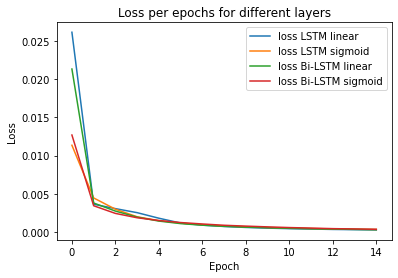

In [ ]:
# for different type of LSTM layer
for method in ['LSTM','Bi-LSTM']:
  # for different type of activation functions in the dense layer
  for act in ['linear','sigmoid']:
    # create model
    model = model_lstm_act(method,neurons,windowsize,act)
    # train model
    history=model.fit(train_input,train_target,epochs=15,batch_size=100,verbose=0)
    # plot loss per epochs
    plt.plot(history.history['loss'], label=f'loss {method} {act}')
    # print test loss
    print(f'{method} {act} test loss = {model.evaluate(test_input,test_target,verbose=0)}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epochs for different layers')
plt.legend()

The losses of the bidirectional layer are not always lower, the losses are not constant (compare the losses here and in the first graph). This is because we are talking about losses of the order of -3 or -4. They are already very small. These fluctuations are quite normal. The losses for sigmoid and linear are very close, but for sigmoid, the convergence is faster.

I will add a hidden dense layer and see what activation functions work better (two dense layers in total).

LSTM linear linear test loss = 0.00012667372357100248
LSTM linear sigmoid test loss = 0.00018162757623940706
LSTM sigmoid linear test loss = 0.00018812516645994037
LSTM sigmoid sigmoid test loss = 0.0003741584368981421
Bi-LSTM linear linear test loss = 0.0002251693804282695
Bi-LSTM linear sigmoid test loss = 0.0008754245354793966
Bi-LSTM sigmoid linear test loss = 0.00011501161498017609
Bi-LSTM sigmoid sigmoid test loss = 0.000675077666528523


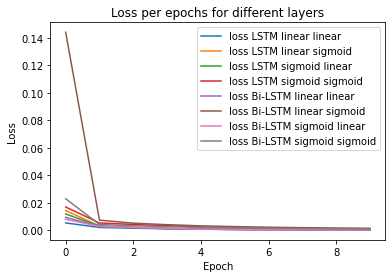

In [ ]:
# for different type of LSTM layer
for method in ['LSTM','Bi-LSTM']:
  # for different type of activation functions in the output dense layer
  for act in ['linear','sigmoid']:
    # for different type of activation functions in the hidden dense layer
    for act_hidden in ['linear','sigmoid']:
      # create model
      model = model_lstm_act(method,neurons,windowsize,act,acts_hidden=[act_hidden])
      # train model
      history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
      # plot loss per epochs
      plt.plot(history.history['loss'], label=f'loss {method} {act} {act_hidden}')
      # print test loss
      print(f'{method} {act} {act_hidden} test loss = {model.evaluate(test_input,test_target,verbose=0)}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epochs for different layers')
plt.legend()

As it can be seen, there is no clear benefit of using the bidirectional layer for daily temperature predictions. Therefore, I will use simple LSTM layer (actually, I have also tried using bidirectional layers in the next sections, but the performance was not improved).

As mentioned before, linear and sigmoid gives very close losses but sigmoid seems to converge faster. Therefore I will use sigmoid activation function for both hidden and output dense layers.

To sum up, I will use LSTM layer (not bidirectional) with sigmoid activation function in the dense layers.

### 8.1.2 1 day in advance model structure

In [ ]:
# neurons array
neuron_array = np.array([2,8,16,32,50,64,100,128])

In [ ]:
# days in the history used to predict
# as seen previsouly, a windowsize=5 also works
# as we want to test the LSTM neurons, I have chosen a bigger windowsize
windowsize = 20
# days in advace = offset + 1
offset = 0
# time sequences data
data = timeseqs(df_tavg_cond,windowsize,offset)
# training data end date
train_end_date = date(2020,1,1)
# get training and testing data
train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)

For single LSTM layer

In [ ]:
# create loss array
loss = np.zeros(len(neuron_array))
# loop for each neuron in the neuron_array
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[lstm_neuron])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for single LSTM layer')

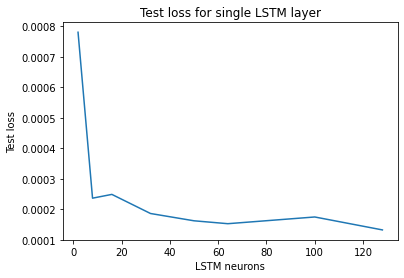

In [ ]:
# plot the loss for one day in advance prediction using single LSTM layer
plt.plot(neuron_array,loss)
plt.xlabel('LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer')

As long as the number of neurons is not too little, the test loss is quite independent of the number of LSTM neurons for one day in advance predictions. I will now test for two LSTM layers, the first one with 128 neurons.

In [ ]:
# loop for each neuron in the neuron_array
# it represents the neurons for the second LSTM layer
# first LSTM layer with 128 neurons
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128,lstm_neuron])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for double LSTM layer')

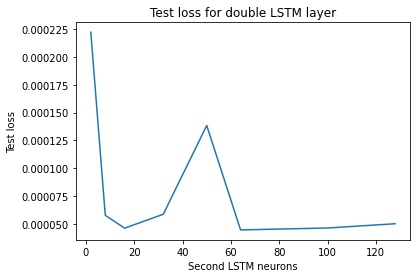

In [ ]:
# plot the loss for one day in advance prediction using two LSTM layers
# first LSTM layer with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Second LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for double LSTM layer')

Using a second LSTM layer, the losses are lowered considerable, although for 50 (number of neurons in the second LSTM layer), it seems that there is a spike. This is because of the fluctuations. We can move forward by adding a third LSTM layer, using 128 neurons in the first and second LSTM layer.

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the second LSTM layer
# first and second LSTM layer with 128 neurons
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128,128,lstm_neuron])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for triple LSTM layer')

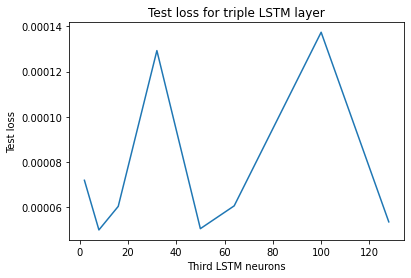

In [ ]:
# plot the loss for one day in advance prediction using two LSTM layers
# first and second LSTM layer with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Third LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for triple LSTM layer')

Adding a third layer does not lower the test loss. Next I will add a hidden layer, with two LSTM layers, one with 128 and one with 64 neurons (these choices aren't important, if I chose 128 and 128 it will give a similar performance).

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the hidden layer
# LSTM layers with 128 and 64 neurons
for i,dense_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128,64],dense_neurons=[dense_neuron,1],act=['sigmoid','sigmoid'])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for double LSTM layer with dense hidden layer')

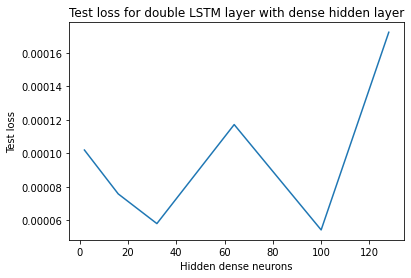

In [ ]:
# plot the loss for one day in advance prediction using LSTM+hidden dense layer
# LSTM layers with 128 and 64 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Hidden dense neurons')
plt.ylabel('Test loss')
plt.title('Test loss for double LSTM layer with dense hidden layer')

The extra dense layer does not make it perform better, instead, it sometimes performs even worse.

### 8.1.3 14 days in advance model structure

In [ ]:
# neurons array
neuron_array = np.array([2,16,32,64,100,128])

In [ ]:
# days in the history used to predict
windowsize = 45
# 14 days in advance
offset = 13
# get time sequences data
data = timeseqs(df_tavg_cond,windowsize,offset)
# training data end date
train_end_date = date(2020,1,1)
# get training and testing data
train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)

In [ ]:
# create loss array
loss = np.zeros(len(neuron_array))
# loop for each neuron in the neuron_array
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[lstm_neuron])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for single LSTM layer')

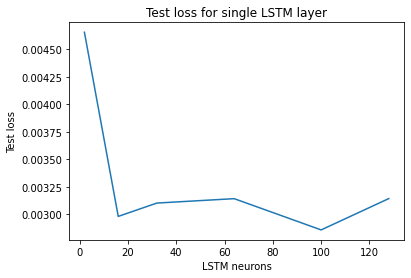

In [ ]:
# plot the loss for 14 days in advance prediction using single LSTM layer
plt.plot(neuron_array,loss)
plt.xlabel('LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer')

As before, the number of LSTM neurons is not important, as long ad it is not too little (like 2). Now I will add a second LSTM layer.

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the second LSTM layer
# first LSTM layer with 128 neurons
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128,lstm_neuron])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for double LSTM layer')

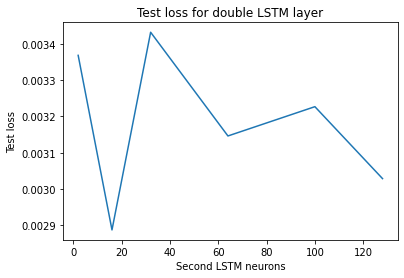

In [ ]:
# plot the loss for one day in advance prediction using two LSTM layers
# first LSTM layer with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Second LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for double LSTM layer')

The performance is not improved, adding a second LSTM layer is useless for predicting 14 days in advance. This is actually because one can't predict 14 days in advance accurately. Therefore it does not matter if you have 1 or 2 LSTM layer (this is shown in the future sections). Now I will add a hidden dense layer with a single LSTM layer (I have also tried adding a hidden dense layer using two LSTM layers, but got same results).

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the hidden layer
# LSTM layer with 128 neurons
for i,dense_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128],dense_neurons=[dense_neuron,1],act=['sigmoid','sigmoid'])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for single LSTM layer with dense hidden layer')

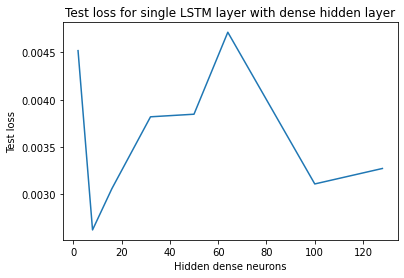

In [ ]:
# plot the loss for one day in advance prediction using LSTM+hidden dense layer
# LSTM layer with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Hidden dense neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer with dense hidden layer')

As before, no benefit of using extra dense layers (actually, sometimes it gets worse performance, larger losses). The reason is the same as before, cannot really predict 14 days in advance. 

After looking at the two extremes, I would choose a model with two LSTM layers, first one with 128 neurons and second one with 64 LSTM neurons. Although the second LSTM layer is useless for predicting 14 days in advance, it might be usefull for predicting 1 or 2 days in advance (it does, I have checked it). Hidden dense layers are useless for both cases, I won't use them. To sum up: LSTM(128)+LSTM(64)+Dense(1), the final dense layer is the output layer, with sigmoid activation function.

### 8.1.4 Windowsize

For 1 day in advance, the loss is quite independent from the windowsize. I will test for 7 and 14 days in advance.

In [ ]:
windowsize_array = np.array([45,60,75,90,105])

In [ ]:
# 7 days in advance
offset = 6

In [ ]:
# create loss array
loss = np.zeros(len(windowsize_array))

# loop for each window in the windowsize_array
for i,windowsize in enumerate(windowsize_array):
  # get time sequences data
  data = timeseqs(df_tavg_cond,windowsize,offset)
  # get training and testing data
  train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)
  # create model with 128 and 64 LSTM neurons
  model = model_type(windowsize,lstm_neurons=[128,64])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for 7 days in advance')

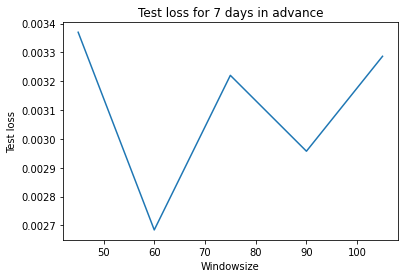

In [ ]:
# plot the loss for 7 days in advance prediction
plt.plot(windowsize_array,loss)
plt.xlabel('Windowsize')
plt.ylabel('Test loss')
plt.title(f'Test loss for {offset+1} days in advance')

In [ ]:
# days in advace = offset + 1
offset = 13

In [ ]:
# create loss array
loss = np.zeros(len(windowsize_array))

# loop for each window in the windowsize_array
for i,windowsize in enumerate(windowsize_array):
  # get time sequences data
  data = timeseqs(df_tavg_cond,windowsize,offset)
  # get training and testing data
  train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)
  # create model with 128 and 64 LSTM neurons
  model = model_type(windowsize,lstm_neurons=[128,64])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for 14 days in advance')

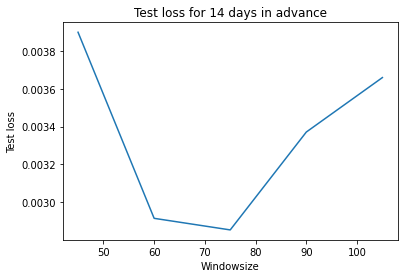

In [ ]:
# plot the loss for 14 days in advance prediction
plt.plot(windowsize_array,loss)
plt.xlabel('Windowsize')
plt.ylabel('Test loss')
plt.title(f'Test loss for {offset+1} days in advance')

We can see that there is a minimum around windowsize = 60. Although, for other windowsizes, the loss is quite similar. In this project we are not interested in the absulute optimal configuration. A loss of 0.0038 and a loss of 0.0030 is basically the same. By the same I mean the predictions are very similar. I will show later that the predictions are bad for 14 days in advance (actually, the predictions are bad from 3 or 4 days in advance), it does not matter if the loss is 0.0030 or 0.0038. However, I will use windowsize=60 for the next sections. 

## 8.2 One day in advance

I will train two models. One using original data and one using data after data conditioning.

In [ ]:
# days in the history used to predict
windowsize = 60
# 1 day in advance
offset = 0
# training data end date
train_end_date = date(2020,1,1)

In [ ]:
# parameters of the model and training
epochs=10
batchsize=100
lstm_neurons=[128,64]

# get history, targets, predictions and test loss for original data
history,test_predict,test_target,test_loss = train_model(df_scaled['TAVG'],windowsize,
                                                         offset,train_end_date,epochs,batchsize,
                                                         lstm_neurons)
# get history, targets, predictions and test loss after data conditioning
history_cond,test_predict_cond,test_target_cond,test_loss_cond = train_model(df_tavg_cond,windowsize,
                                                          offset,train_end_date,epochs,batchsize,
                                                          lstm_neurons)

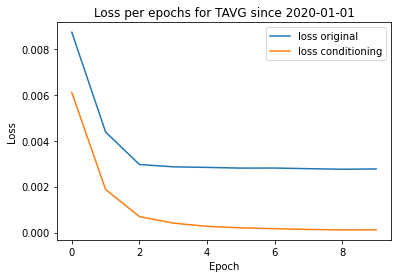

In [ ]:
# plot loss per epochs
plt.plot(history.history['loss'], label='loss original')
plt.plot(history_cond.history['loss'], label='loss conditioning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss per epochs for TAVG since {train_end_date}')
plt.legend()

We also see that 10 epochs is more than enough (I checked for other offsets, 10 is enough)

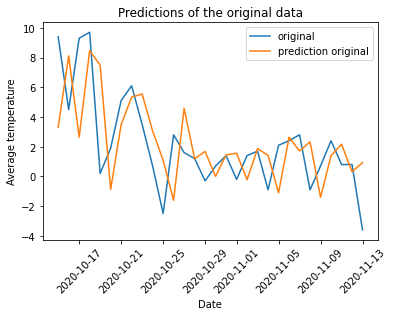

In [ ]:
# plot predictions of the last 30 days for original data
plt.plot(df.iloc[-30:].index,descale(test_target[-30:],descale_tavg),label='original')
plt.plot(df.iloc[-30:].index,descale(test_predict[-30:],descale_tavg),label='prediction original')
plt.xticks(rotation=45)
plt.title('Predictions of the original data')
plt.xlabel('Date')
plt.ylabel('Average temperature')
plt.legend()

The predictions of the original dataset (not using data conditioning) can't predict maxima or minima. It is shifted by one day. The LSTM model is trained such that the temperature next day will be very similar to the previous day.

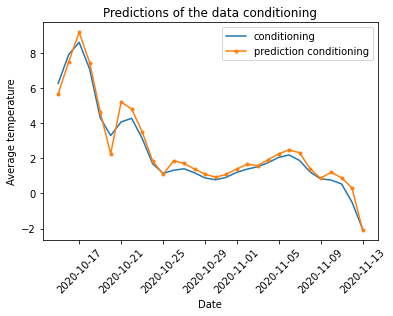

In [ ]:
# plot predictions of the last 30 days after data conditioning
plt.plot(df.iloc[-30:].index,descale(test_target_cond[-30:],descale_tavg),label='conditioning')
plt.plot(df.iloc[-30:].index,descale(test_predict_cond[-30:],descale_tavg),'.-',label='prediction conditioning')
plt.title('Predictions of the data conditioning')
plt.xticks(rotation=45)
plt.xlabel('Date')
plt.ylabel('Average temperature')
plt.legend()

After using data conditioning, it does not looked shifted. For example, at 2020-10-25, it correctly precits a relative minimum. The LSTM model is trained such that is can predict some minima and maxima.

In [ ]:
print(f'test loss for original {test_loss}')
print(f'test loss after conditioning {test_loss_cond}')
# real test loss of the predictions using data conditioning
# test_predict_cond is compared with test_target, the real targets
print(f'real test loss after conditioning {mean_squared_error(test_target,test_predict_cond)}')

test loss for original 0.001921074464917183
test loss after conditioning 5.643821714329533e-05
real test loss after conditioning 0.0006217964706461248


I have also printed a real test loss after data conditioning. This is because the test loss from the model that uses data conditioning has got targets that are not the real original data. So test_loss is the error of the predictions compared to the data after data conditioning, real test loss is the error of the predictions compared to the data before data conditioning. However, as it can be seen, even the real test loss is smaller by a lot compared to the original test loss (0.0006 vs 0.0019). I will now plot the original data and the different predictions.

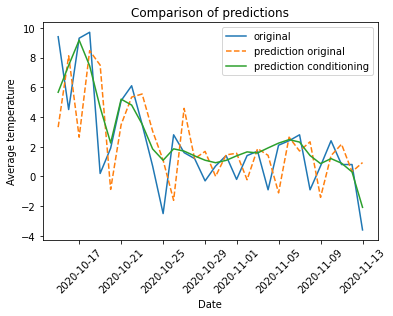

In [ ]:
# plot original with different predictions
plt.plot(df.iloc[-30:].index,descale(test_target[-30:],descale_tavg),label='original')
plt.plot(df.iloc[-30:].index,descale(test_predict[-30:],descale_tavg),'--',label='prediction original')
plt.plot(df.iloc[-30:].index,descale(test_predict_cond[-30:],descale_tavg),label='prediction conditioning')
plt.xticks(rotation=45)
plt.title('Comparison of predictions')
plt.xlabel('Date')
plt.ylabel('Average temperature')
plt.legend()

For example, for 2020-10-25, the prediction using conditioning captures correctly a relative minimum at that date. In summary, the predictions using data conditioning does not have so many spikes, but it correctly captures the trends, and the loss (mean square error) is also smaller.

I have tried using more LSTM neurons and added hidden dense layers and dropout layers. However, the performance is similar.

## 8.3 Comparison of different days in advance

I will use the same model to predict the temperature for different days in advance (from 1 to 14 days). Each time, I will use 60 days (2 months) as windowsize. 

In [ ]:
# days in the history used to predict
windowsize = 60
# training data end date
train_end_date = date(2020,1,1)

# parameters of the model and training
epochs=10
batchsize=100
lstm_neurons=[128,64]

# list of predictions, test losses
test_predict_list = []
test_loss_list = []

# loop to predict from 1 to 14 days in advance
# offset from 0 to 13
offset_max = 14
for offset in range(offset_max):
  # train and get predictions, targets and loss
  _,test_predict,test_target,test_loss = train_model(df_scaled['TAVG'],windowsize,
                                                      offset,train_end_date,epochs,batchsize,
                                                     lstm_neurons)
  
  test_predict_list.append(test_predict)
  test_loss_list.append(test_loss)

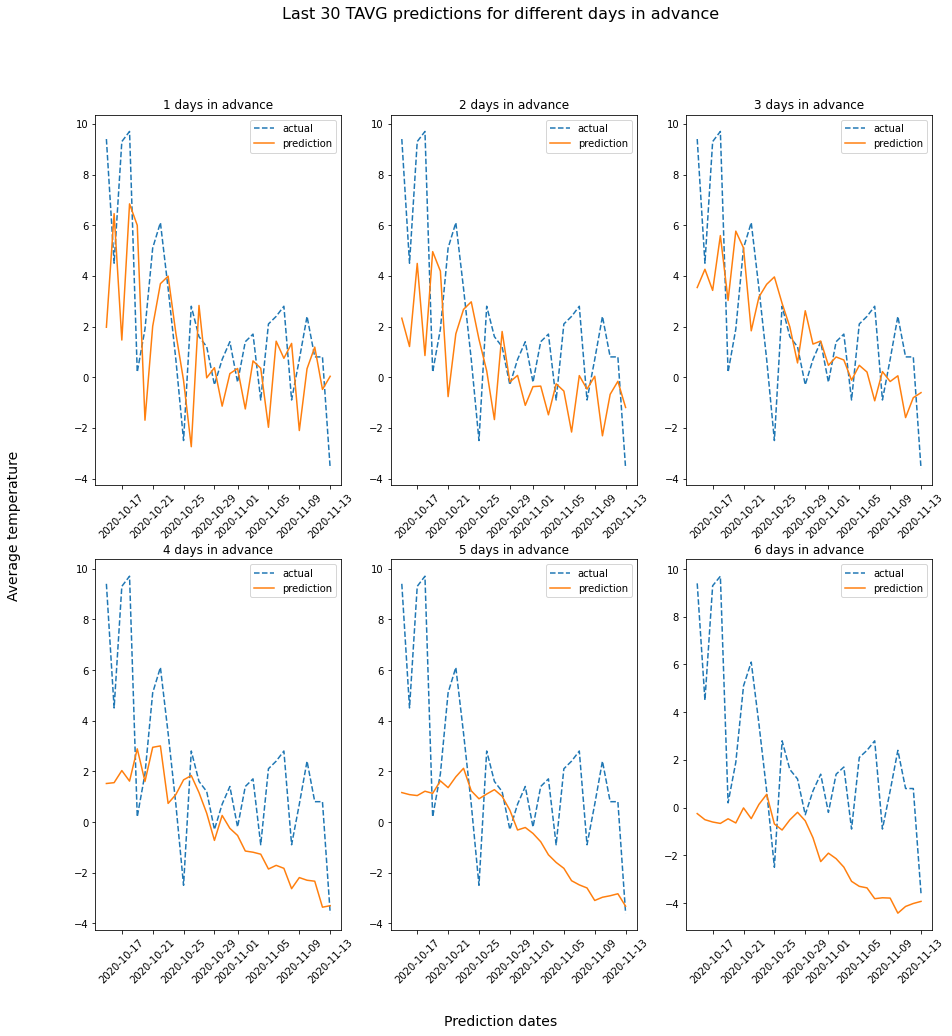

In [ ]:
# last month predictions comparison
n = 30
title = f'Last {n} TAVG predictions for different days in advance'
ytitle = 'Average temperature'
plot_subplot(df,test_predict_list,test_target,descale_tavg,title,ytitle,
             np.arange(offset_max),n=n)

The are not good predictions in any case. For 1 day in advance, it was already discussed previously.

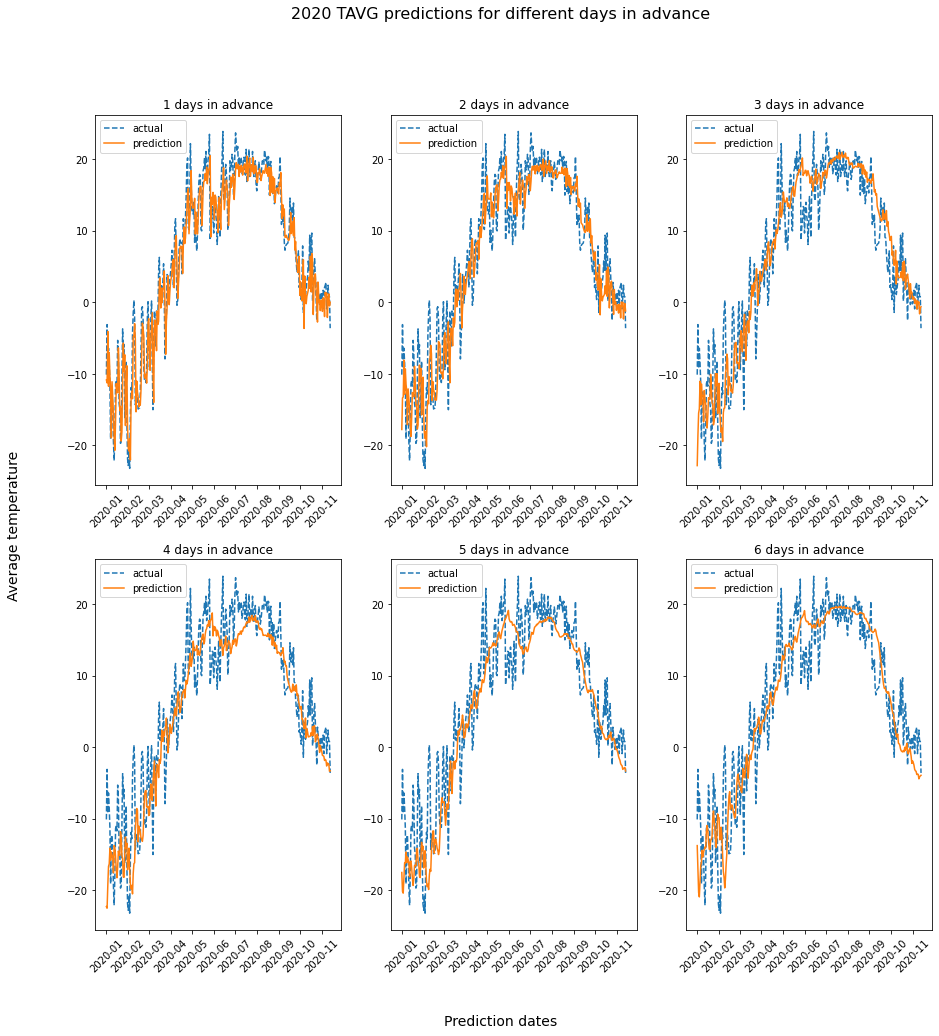

In [ ]:
# 2020 predictions comparison
title = f'2020 TAVG predictions for different days in advance'
plot_subplot(df,test_predict_list,test_target,descale_tavg,title,ytitle,np.arange(offset_max))

For large scales, the predictions can catch the trends, but only that.

Text(0, 0.5, 'Test loss')

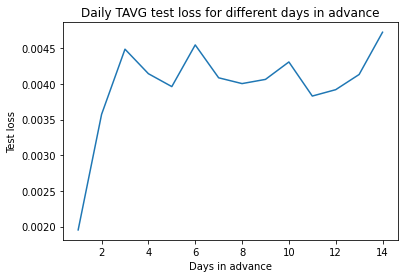

In [ ]:
# plot test loss vs offset
plt.plot(np.arange(1,offset_max+1),test_loss_list)
plt.title('Daily TAVG test loss for different days in advance')
plt.xlabel('Days in advance')
plt.ylabel('Test loss')

After 3 days in advance, the test loss is quite constant, this is because we have reached a point that we can only predict the temperatures in large scales (see '2020 TAVG predictions for different days in advance' graph). Now I will use data after data conditioning. 

In [ ]:
# list of predictions and test losses
test_predict_list_cond = []
test_loss_list_cond = []
real_test_loss_list_cond = []

# loop to predict from 1 to 14 days in advance
# offset from 0 to 13
offset_max = 14
for offset in range(offset_max):
  # train and get predictions and loss
  _,test_predict,_,test_loss = train_model(df_tavg_cond,windowsize,
                                           offset,train_end_date,epochs,batchsize,
                                           lstm_neurons)
  
  test_predict_list_cond.append(test_predict)
  test_loss_list_cond.append(test_loss)
  # real test loss
  real_test_loss_list_cond.append(mean_squared_error(test_target,test_predict))

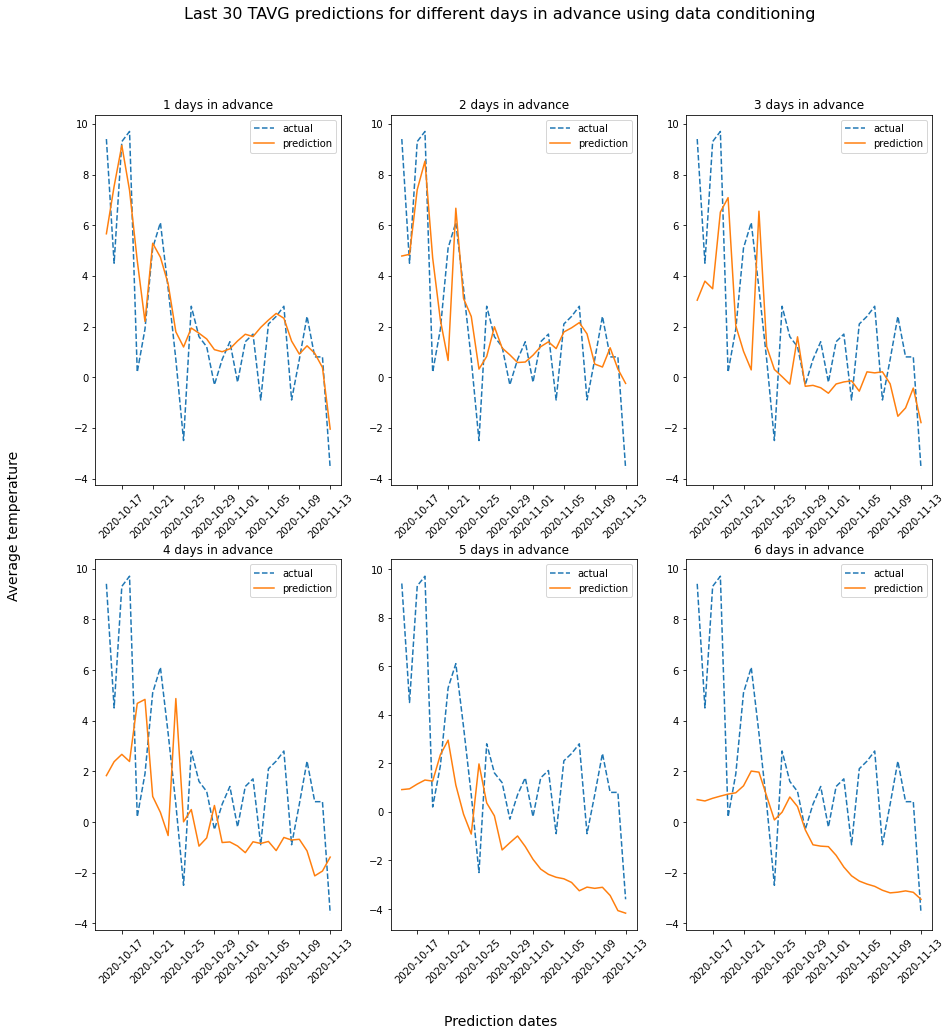

In [ ]:
# last month predictions comparison
title = f'Last {n} TAVG predictions for different days in advance using data conditioning'
plot_subplot(df,test_predict_list_cond,test_target,descale_tavg,title,ytitle,np.arange(offset_max),n=n)

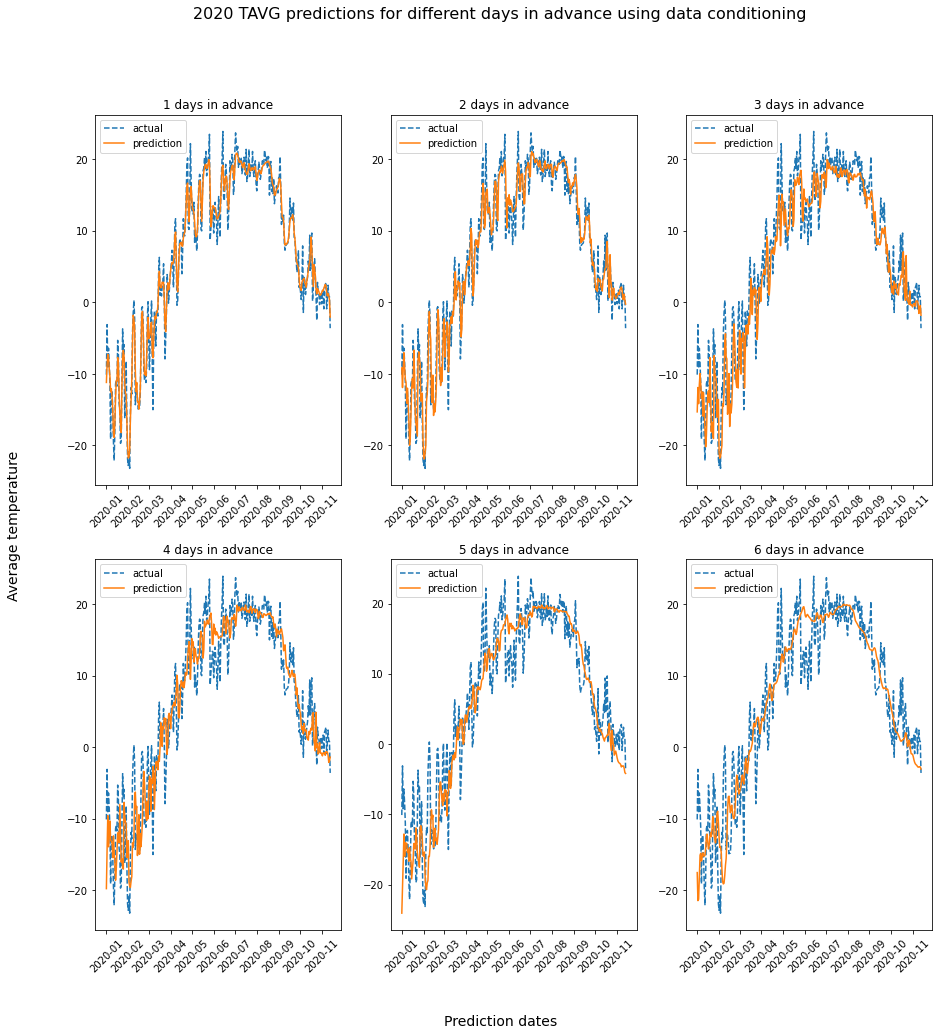

In [ ]:
# 2020 predictions comparison
title = f'2020 TAVG predictions for different days in advance using data conditioning'
plot_subplot(df,test_predict_list_cond,test_target,descale_tavg,title,ytitle,np.arange(offset_max))

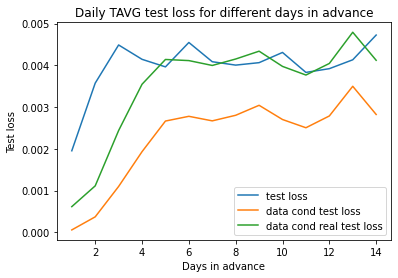

In [ ]:
# plot test loss vs offset
plt.plot(np.arange(1,offset_max+1),test_loss_list,label='test loss')
plt.plot(np.arange(1,offset_max+1),test_loss_list_cond,label='data cond test loss')
plt.plot(np.arange(1,offset_max+1),real_test_loss_list_cond,label='data cond real test loss')
plt.title('Daily TAVG test loss for different days in advance')
plt.xlabel('Days in advance')
plt.ylabel('Test loss')
plt.legend()

If we looked at the graphs, one can only predict one day, at most two days in advance with accuracy (e.g. at 2020-10-25, the model correctly predicts the minima). By accuracy I mean one can predict some maxima and minima. Three days in advance is too far away to predict accurately using historical data.

To show that 3 days in advance is really impossible (not possible to predict when the trends change), I will use a more complex network structure.

In [ ]:
# days in the history used to predict
windowsize = 60
# 3 days in advance
offset = 2
# training data end date
train_end_date = date(2020,1,1)

# parameters of the model and training
epochs=10
batchsize=100
# two LSTM layers with 128 and 64 neurons
lstm_neurons=[128,64]
# two dense hidden layers with 64 and 32 neurons
# one dense output layer with 1 neuron
dense_neurons = [64,32,1]
# use sigmoid act function for all dense layers
act = ['sigmoid']*3

# train and return hisotry, predictions, loss
history,test_predict,_,test_loss = train_model(df_tavg_cond,windowsize,offset,train_end_date,
                                         epochs,batchsize,lstm_neurons,
                                         dense_neurons,act)

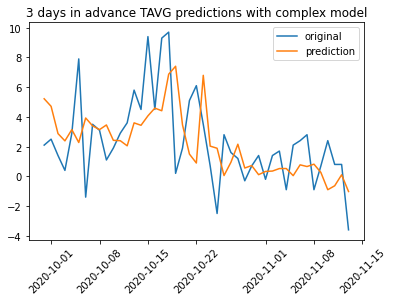

In [ ]:
# plot predictions of the last 45 days for original data
plt.plot(df.iloc[-45:].index,descale(test_target[-45:],descale_tavg),label='original')
plt.plot(df.iloc[-45:].index,descale(test_predict[-45:],descale_tavg),label='prediction')
plt.xticks(rotation=45)
plt.title(f'{offset+1} days in advance TAVG predictions with complex model')
plt.legend()

In [ ]:
# this test_target is the real target, not the data after data conditioning
print(f'loss = {mean_squared_error(test_target,test_predict)}')

loss = 0.0024992943484214644


It gives very similar predictions than using a simpler model. We still can't predict three days in advance, we can't predict the maxima and minima. This is the reason I have chosen a simpler model. A more complex model might give smaller losses for some cases, but in general, the predictions look similar to the simpler model's predictions. More importantly, a more complex model does not change the fact that we are not able to predict more days in advance. This ensures again that the model chosen is enough. Finally, we can conclude that using historical data, we can only get reasonable predictions for one or two day in advance.

# 9. MONTHLY AVERAGE TEMPERATURE PREDICTIONS

## 9.1 Model structure

### 9.1.1 LSTM type and activation function

As for daily temperature predictions, Relu does not always work for monthly TAVG. I will only test for linear and sigmoid activation functions.

In [ ]:
# months in the history used to predict
windowsize = 12
# months in advace = offset + 1
offset = 0
# get time sequences data
data = timeseqs(df_month_tavg_cond,windowsize,offset)

In [ ]:
# training data end date
train_end_date = date(2010,1,1)
# get training and testing data
train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)

LSTM linear test loss = 0.002899488201364875
LSTM sigmoid test loss = 0.002804852556437254
Bi-LSTM linear test loss = 0.0020697545260190964
Bi-LSTM sigmoid test loss = 0.0025627054274082184


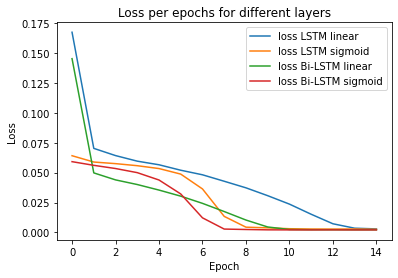

In [ ]:
# number of LSTM neurons
neurons = 20

# for different type of LSTM layer
for method in ['LSTM','Bi-LSTM']:
  # for different type of activation functions in the dense layer
  for act in ['linear','sigmoid']:
    # create model
    model = model_lstm_act(method,neurons,windowsize,act)
    # train model
    history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
    # plot loss per epochs
    plt.plot(history.history['loss'], label=f'loss {method} {act}')
    # print test loss
    print(f'{method} {act} test loss = {model.evaluate(test_input,test_target,verbose=0)}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epochs for different layers')
plt.legend()

I will show another example

In [ ]:
# months in the history used to predict
windowsize = 24
# months in advace = offset + 1
offset = 12
data = timeseqs(df_month_tavg_cond,windowsize,offset)
# training data end date
train_end_date = date(2010,1,1)
# get training and testing data
train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)

LSTM linear test loss = 0.002828181954100728
LSTM sigmoid test loss = 0.0027628387324512005
Bi-LSTM linear test loss = 0.0027867115568369627
Bi-LSTM sigmoid test loss = 0.0030720385257154703


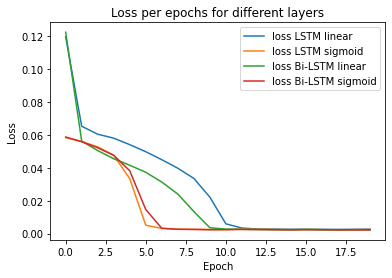

In [ ]:
neurons = 32
# train models for offset=0 and windowsize=12
for method in ['LSTM','Bi-LSTM']:
  for act in ['linear','sigmoid']:
    # create model
    model = model_lstm_act(method,neurons,windowsize,act)
    # train model
    history=model.fit(train_input,train_target,epochs=20,batch_size=50,verbose=0)
    # plot loss per epochs
    plt.plot(history.history['loss'], label=f'loss {method} {act}')
    # print test loss
    print(f'{method} {act} test loss = {model.evaluate(test_input,test_target,verbose=0)}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epochs for different layers')
plt.legend()

Linear and sigmoid give quite similar test loss but sigmoid converges faster. Bidirectional layers does not give better performance. As before, I will use LSTM layer with dense sigmoid layer.

### 9.1.2 1 month in advance model structure

In [ ]:
# neurons array
neuron_array = np.array([2,8,16,32,50,64,100,128])

In [ ]:
# months in the history used to predict
windowsize = 18
# 1 month in advance
offset = 0
# get time sequences data
data = timeseqs(df_month_tavg_cond,windowsize,offset)
# training data end date
train_end_date = date(2010,1,1)
# get training and testing data
train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)

For a single LSTM layer

In [ ]:
# create loss array
loss = np.zeros(len(neuron_array))
# loop for each neuron in the neuron_array
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[lstm_neuron])
  # train model
  history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for single LSTM layer')

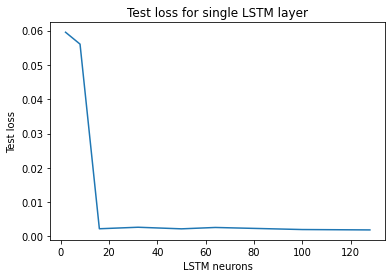

In [ ]:
# plot the loss for one month in advance prediction using single LSTM layer
plt.plot(neuron_array,loss)
plt.xlabel('LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer')

As long as the number of neurons is not too small, we have a quite constant test loss. I will plot the same graph but ignoring the first two points to see clearly the test losses.

Text(0.5, 1.0, 'Test loss for single LSTM layer')

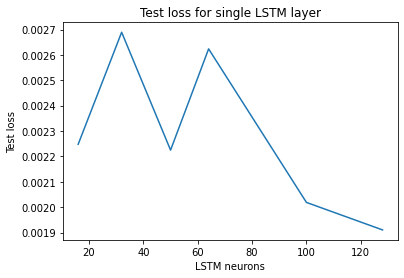

In [ ]:
# plot the loss for one month in advance prediction using single LSTM layer
# ignore first two losses
plt.plot(neuron_array[2:],loss[2:])
plt.xlabel('LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer')

I will add a second LSTM layer, with the first LSTM layer with 128 neurons

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the second LSTM layer
# first LSTM layer with 128 neurons
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128,lstm_neuron])
  # train model
  history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for double LSTM layer')

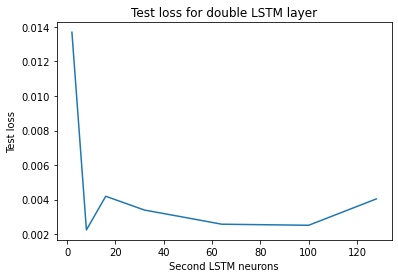

In [ ]:
# plot the loss for one month in advance prediction using two LSTM layers
# first LSTM layer with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Second LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for double LSTM layer')

For monthly temperature predictions, adding a second LSTM layer is not usefull. I will add a hidden dense layer, with one LSTM layer with 128 neurons.

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the hidden layer
# LSTM layer with 128 neurons
for i,dense_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128],dense_neurons=[dense_neuron,1],act=['sigmoid','sigmoid'])
  # train model
  history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for single LSTM layer with dense hidden layer')

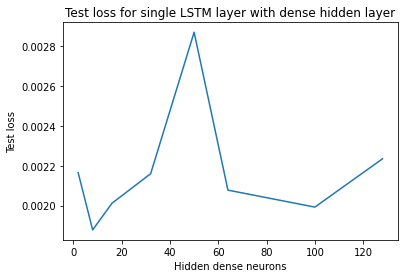

In [ ]:
# plot the loss for one month in advance prediction using LSTM+hidden dense layer
# LSTM layers with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Hidden dense neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer with dense hidden layer')

Adding a hidden dense layer is not useful.

### 9.1.3 12 months in advance model structure

In [ ]:
# months in the history used to predict
windowsize = 36
# 12 months in advance
offset = 11
# get time sequences data
data = timeseqs(df_month_tavg_cond,windowsize,offset)
# training data end date
train_end_date = date(2010,1,1)
# get training and testing data
train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)

For a single LSTM layer

In [ ]:
# create loss array
loss = np.zeros(len(neuron_array))
# loop for each neuron in the neuron_array
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[lstm_neuron])
  # train model
  history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for single LSTM layer')

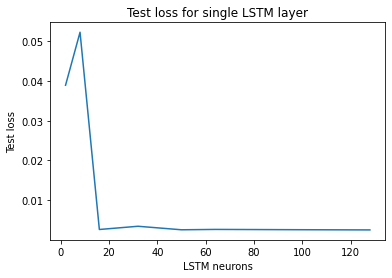

In [ ]:
# plot the loss for 14 months in advance prediction using single LSTM layer
plt.plot(neuron_array,loss)
plt.xlabel('LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer')

As long as the number of neurons is not too small, we have a quite constant test loss. I will plot the same graph but ignoring the first two points.

Text(0.5, 1.0, 'Test loss for single LSTM layer')

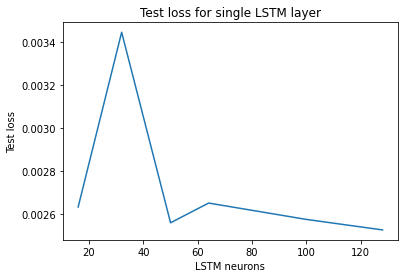

In [ ]:
# plot the loss for 14 months in advance prediction using single LSTM layer
plt.plot(neuron_array[2:],loss[2:])
plt.xlabel('LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer')

I will add a second LSTM layer, with the first LSTM layer with 128 neurons

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the second LSTM layer
# first LSTM layer with 128 neurons
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128,lstm_neuron])
  # train model
  history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for double LSTM layer')

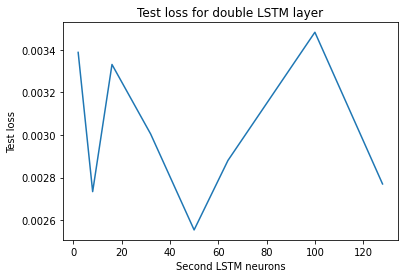

In [ ]:
# plot the loss for 14 months in advance prediction using two LSTM layers
# first LSTM layer with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Second LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for double LSTM layer')

For monthly temperature predictions for 12 months in advance, adding a second LSTM layer is not usefull. I will add a hidden dense layer, with one LSTM layer with 128 neurons.

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the hidden layer
# LSTM layer with 128 neurons
for i,dense_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128],dense_neurons=[dense_neuron,1],act=['sigmoid','sigmoid'])
  # train model
  history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for single LSTM layer with dense hidden layer')

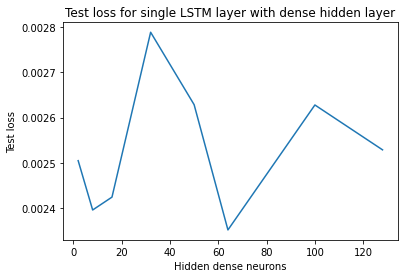

In [ ]:
# plot the loss for 14 months in advance prediction using LSTM+hidden dense layer
# LSTM layers with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Hidden dense neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer with dense hidden layer')

Adding a hidden dense layer is not useful.

After looking at the two extremes, I would choose a model with one LSTM layers with 128 neurons. To sum up: LSTM(128)+Dense(1), the final dense layer is the output layer, with sigmoid activation function.

### 9.1.4 Windowsize

As this training is faster than daily predictions (less samples), I will train three times each windowsize to get an average test loss.

In [ ]:
windowsize_array = np.array([12,18,36,48,60,72])

In [ ]:
# 6 months in advance
offset = 5

In [ ]:
# create loss array
loss = np.zeros((3,len(windowsize_array)))

# loop three times
for i in range(3):
  # loop for each window in the windowsize_array
  for j,windowsize in enumerate(windowsize_array):
    # get time sequences data
    data = timeseqs(df_month_tavg_cond,windowsize,offset)
    # get training and testing data
    train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)
    # create model with 128 LSTM neurons
    model = model_type(windowsize,lstm_neurons=[128])
    # train model
    history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
    # calculate loss
    loss[i,j] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for 6 months in advance')

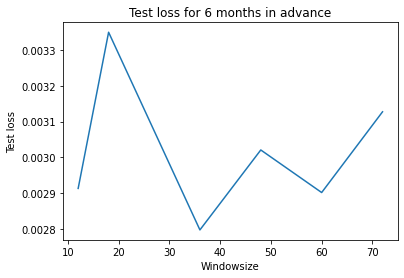

In [ ]:
# plot the loss for 6 months in advance prediction
plt.plot(windowsize_array,np.mean(loss,0))
plt.xlabel('Windowsize')
plt.ylabel('Test loss')
plt.title(f'Test loss for {offset+1} months in advance')

In [ ]:
# 12 months in advance
offset = 11

In [ ]:
# create loss array
loss = np.zeros((3,len(windowsize_array)))

# loop three times
for i in range(3):
  # loop for each window in the windowsize_array
  for j,windowsize in enumerate(windowsize_array):
    # get time sequences data
    data = timeseqs(df_month_tavg_cond,windowsize,offset)
    # get training and testing data
    train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)
    # create model with 128 LSTM neurons
    model = model_type(windowsize,lstm_neurons=[128])
    # train model
    history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
    # calculate loss
    loss[i,j] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for 12 months in advance')

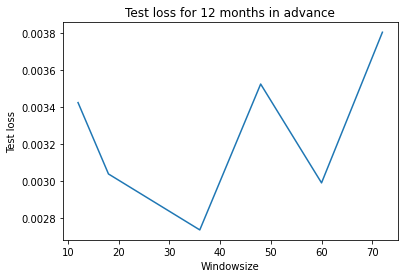

In [ ]:
# plot the loss for 12 months in advance prediction
plt.plot(windowsize_array,np.mean(loss,0))
plt.xlabel('Windowsize')
plt.ylabel('Test loss')
plt.title(f'Test loss for {offset+1} months in advance')

Seems that there is a minimum at windowsize=36, but other test losses are also very similar. I will use 36 months to predict monthly TAVG

## 9.2 One month in advance

In [ ]:
# months in the history used to predict
windowsize = 36
# days in advace = offset + 1
offset = 0
# training data end date
train_end_date = date(2010,1,1)

In [ ]:
# parameters of the model and training
epochs=15
batchsize=50
lstm_neurons=[128]

# get history, targets, predictions and test loss for original data
history,test_predict,test_target,test_loss = train_model(df_month_scaled['TAVG'],windowsize,
                                                         offset,train_end_date,epochs,batchsize,
                                                         lstm_neurons)
# get history, targets, predictions and test loss after data conditioning
history_cond,test_predict_cond,test_target_cond,test_loss_cond = train_model(df_month_tavg_cond,windowsize,
                                                          offset,train_end_date,epochs,batchsize,
                                                          lstm_neurons)

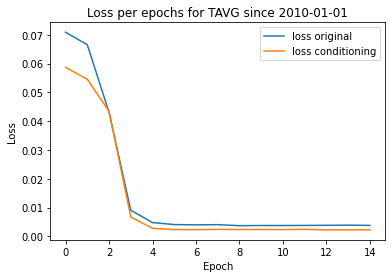

In [ ]:
# plot loss per epochs
plt.plot(history.history['loss'], label='loss original')
plt.plot(history_cond.history['loss'], label='loss conditioning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss per epochs for TAVG since {train_end_date}')
plt.legend()

It can be seen that 15 epochs is more than enough for 1 month in advance's predictions, also for other cases.

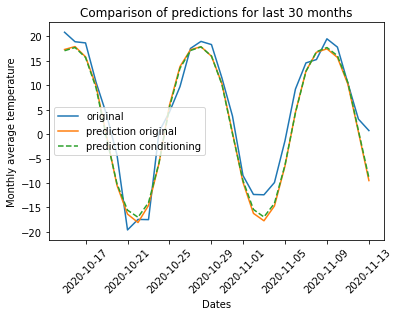

In [ ]:
# plot original with different predictions
plt.plot(df.iloc[-30:].index,descale(test_target[-30:],descale_month_tavg),label='original')
plt.plot(df.iloc[-30:].index,descale(test_predict[-30:],descale_month_tavg),label='prediction original')
plt.plot(df.iloc[-30:].index,descale(test_predict_cond[-30:],descale_month_tavg),'--',label='prediction conditioning')
plt.xticks(rotation=45)
plt.title('Comparison of predictions for last 30 months')
plt.xlabel('Dates')
plt.ylabel('Monthly average temperature')
plt.legend()

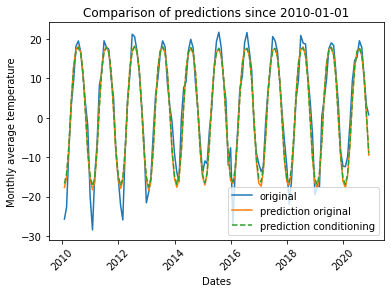

In [ ]:
# length of predictions and targets
n = len(test_target)
# plot original with different predictions
plt.plot(df_month.iloc[-n:].index,descale(test_target,descale_month_tavg),label='original')
plt.plot(df_month.iloc[-n:].index,descale(test_predict,descale_month_tavg),label='prediction original')
plt.plot(df_month.iloc[-n:].index,descale(test_predict_cond,descale_month_tavg),'--',label='prediction conditioning')
plt.xticks(rotation=45)
plt.title(f'Comparison of predictions since {train_end_date}')
plt.xlabel('Dates')
plt.ylabel('Monthly average temperature')
plt.legend()

As it can be seen, the predictions are sinusoidal functions. Although the amplitude changes per year, it is still difficult to predict exactly the maxima and minima. I have tried using using more LSTM neurons and adding hidden dense layers, but the performance is similar. 

In [ ]:
print(f'test loss for original {test_loss}')
print(f'test loss after conditioning {test_loss_cond}')
# real test loss of the predictions using data conditioning
# test_predict_cond is compared with test_target, the real targets
print(f'real test loss after conditioning {mean_squared_error(test_target,test_predict_cond)}')

test loss for original 0.004734070040285587
test loss after conditioning 0.0027792875189334154
real test loss after conditioning 0.004743582661220163


Using data conditioning for monthly temperature predictions does not give better performance. They both give very similar loss and predictions. This is because the original monthly temperature already looks like it is been passed to the filter. I will now show an example of complex model to predict the temperatures.

In [ ]:
# parameters of the model and training
epochs=20
batchsize=50
# two LSTM layers with 128 and 64 neurons
lstm_neurons=[128,64]
# two dense hidden layers with 128 and 64 neurons
# one dense output layer with 1 neuron
dense_neurons = [128,64,1]
# use sigmmoid act function for all dense layers
act = ['sigmoid']*3

# train and return hisotry, predictions, loss
history,test_predict,_,test_loss = train_model(df_month_scaled['TAVG'],windowsize,offset,train_end_date,
                                         epochs,batchsize,lstm_neurons,
                                         dense_neurons,act)

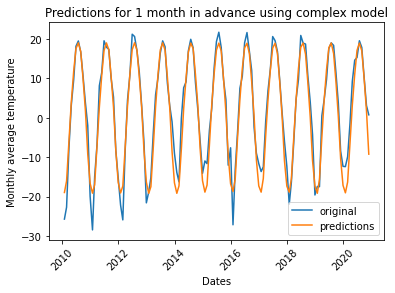

In [ ]:
# plot original with different predictions
plt.plot(df_month.iloc[-n:].index,descale(test_target[-n:],descale_month_tavg),label='original')
plt.plot(df_month.iloc[-n:].index,descale(test_predict[-n:],descale_month_tavg),label='predictions')
plt.xticks(rotation=45)
plt.title('Predictions for 1 month in advance using complex model')
plt.xlabel('Dates')
plt.ylabel('Monthly average temperature')
plt.legend()

In [ ]:
# print test loss
test_loss

0.0044825077056884766

As it can be seen, the very complex model can't improved the performance, the maxima and minima are still very difficult to predict, specially the minima, that varies a lot every year. 

## 9.3 Comparison of different months in advance

In [ ]:
# months in the history used to predict
windowsize = 36
# training data end date
train_end_date = date(2010,1,1)

# parameters of the model and training
epochs=15
batchsize=50
lstm_neurons=[128]

# list of predictions and test losses
test_predict_list = []
test_loss_list = []

# loop to predict from 1 to 12 months in advance
# offset from 0 to 11
offset_max = 12
for offset in range(offset_max):
  # train and get predictions, targets and loss
  _,test_predict,test_target,test_loss = train_model(df_month_scaled['TAVG'],windowsize,
                                                         offset,train_end_date,epochs,
                                                     batchsize,lstm_neurons)
  
  test_predict_list.append(test_predict)
  test_loss_list.append(test_loss)

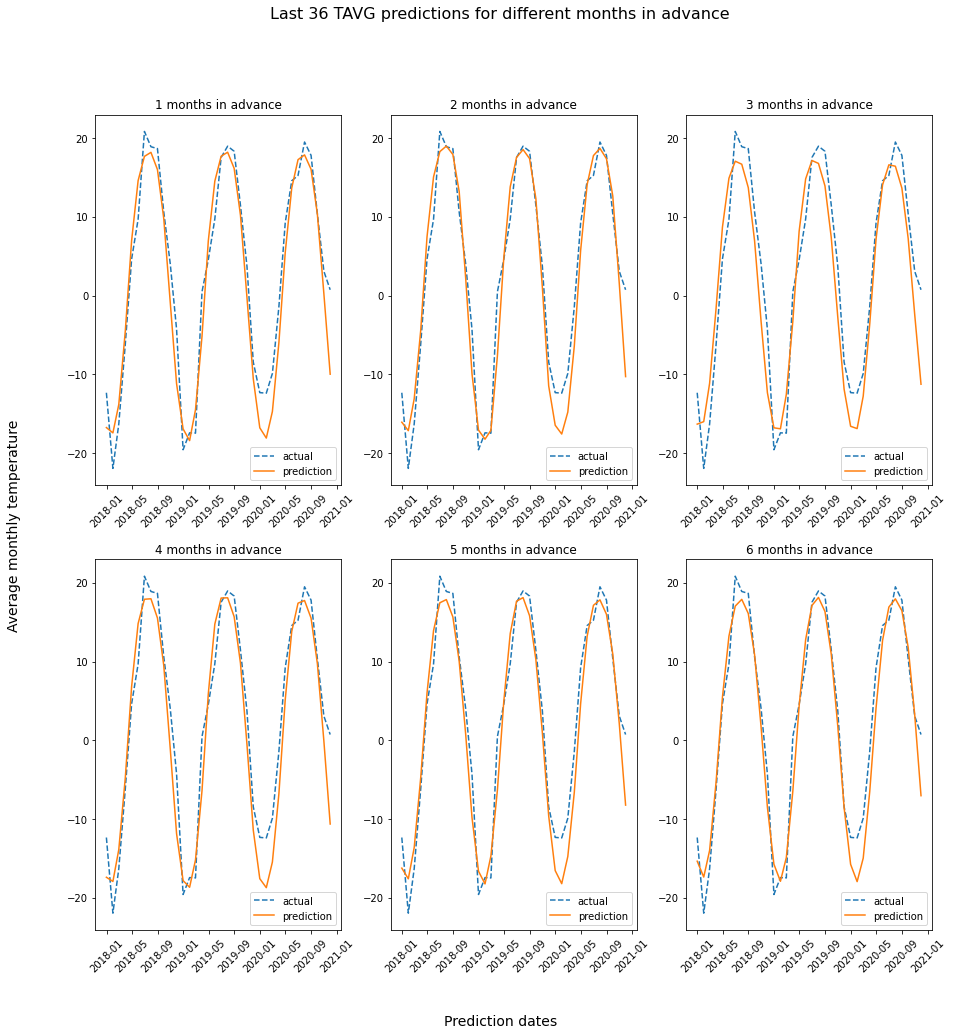

In [ ]:
# last 3 years predictions comparison
n = 36
title = f'Last {n} TAVG predictions for different months in advance'
ytitle = 'Average monthly temperature'
plot_subplot(df_month,test_predict_list,test_target,descale_month_tavg,title,ytitle,
             np.arange(offset_max),frequency='months',n=n)

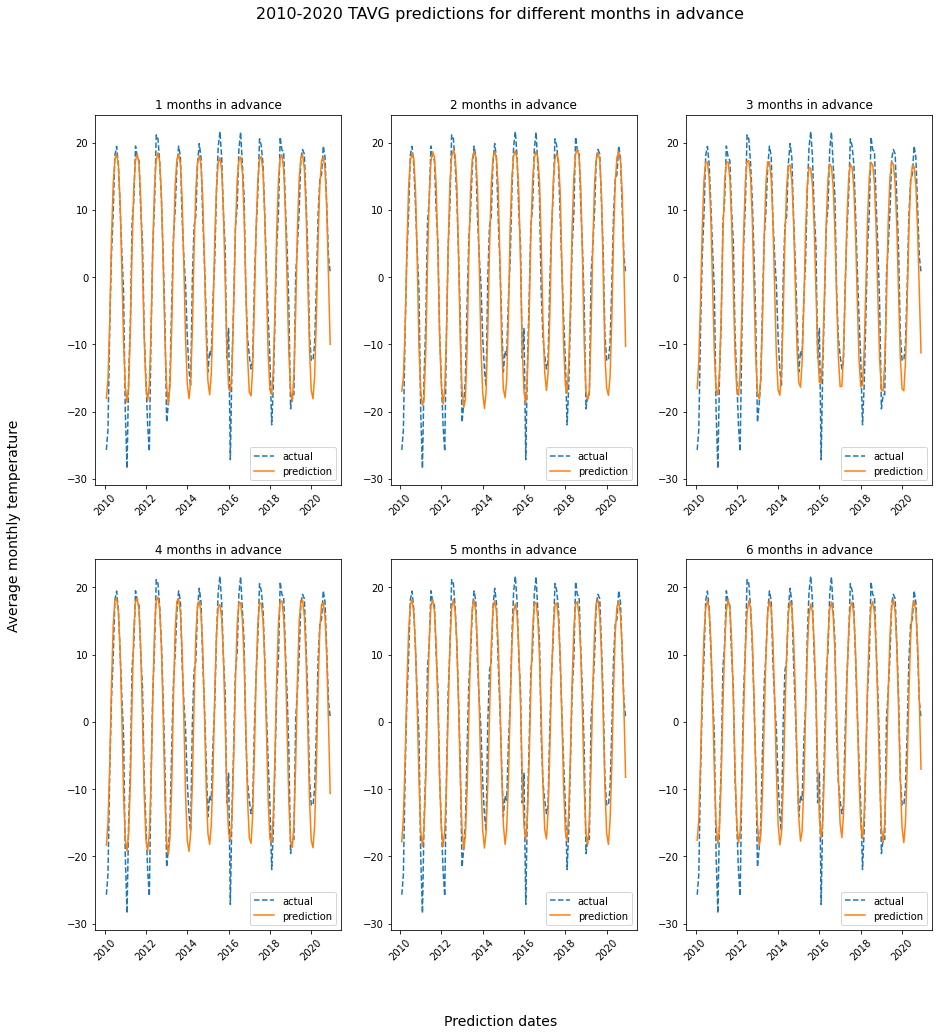

In [ ]:
# 2010-2020 predictions comparison
title = f'2010-2020 TAVG predictions for different months in advance'
plot_subplot(df_month,test_predict_list,test_target,descale_month_tavg,title,
             ytitle,np.arange(offset_max),frequency='months')

Text(0, 0.5, 'Test loss')

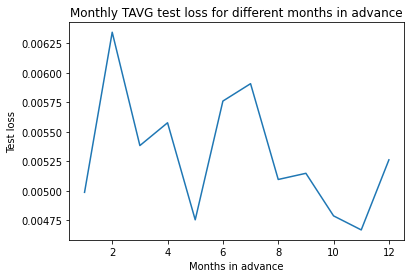

In [ ]:
# plot test loss vs offset
plt.plot(np.arange(1,offset_max+1),test_loss_list)
plt.title('Monthly TAVG test loss for different months in advance')
plt.xlabel('Months in advance')
plt.ylabel('Test loss')

As it can be seen, the test loss is quite constant for all cases (although there are some fluctuations). The predictions are also very similar, they are all sinusoidal functions (although the amplitude does change slightly). The maximum temperature predictions are slightly better than minimum temperatures, partly because the minimum temperature per year changes more radically. 

This was the reason why one can't get a better model for monthly temperatures. The best we can get are sinusoidal predictions. We can't accurately predict the maxima and minima (even for a very complex model). Therefore it does not matter if we predict 1 month in advance or 12 months in advance. I will now try using data after data conditioning. 

In [ ]:
# list of predictions and test losses
test_predict_list_cond = []
test_loss_list_cond = []
real_test_loss_list_cond = []
 
# loop to predict from 1 to 12 months in advance
# offset from 0 to 11
offset_max = 12
for offset in range(offset_max):
  # train and get predictions and loss
  _,test_predict,_,test_loss = train_model(df_month_tavg_cond,windowsize,
                                                         offset,train_end_date,epochs,
                                                     batchsize,lstm_neurons)
  
  test_predict_list_cond.append(test_predict)
  test_loss_list_cond.append(test_loss)
  # real test loss
  real_test_loss_list_cond.append(mean_squared_error(test_target,test_predict))

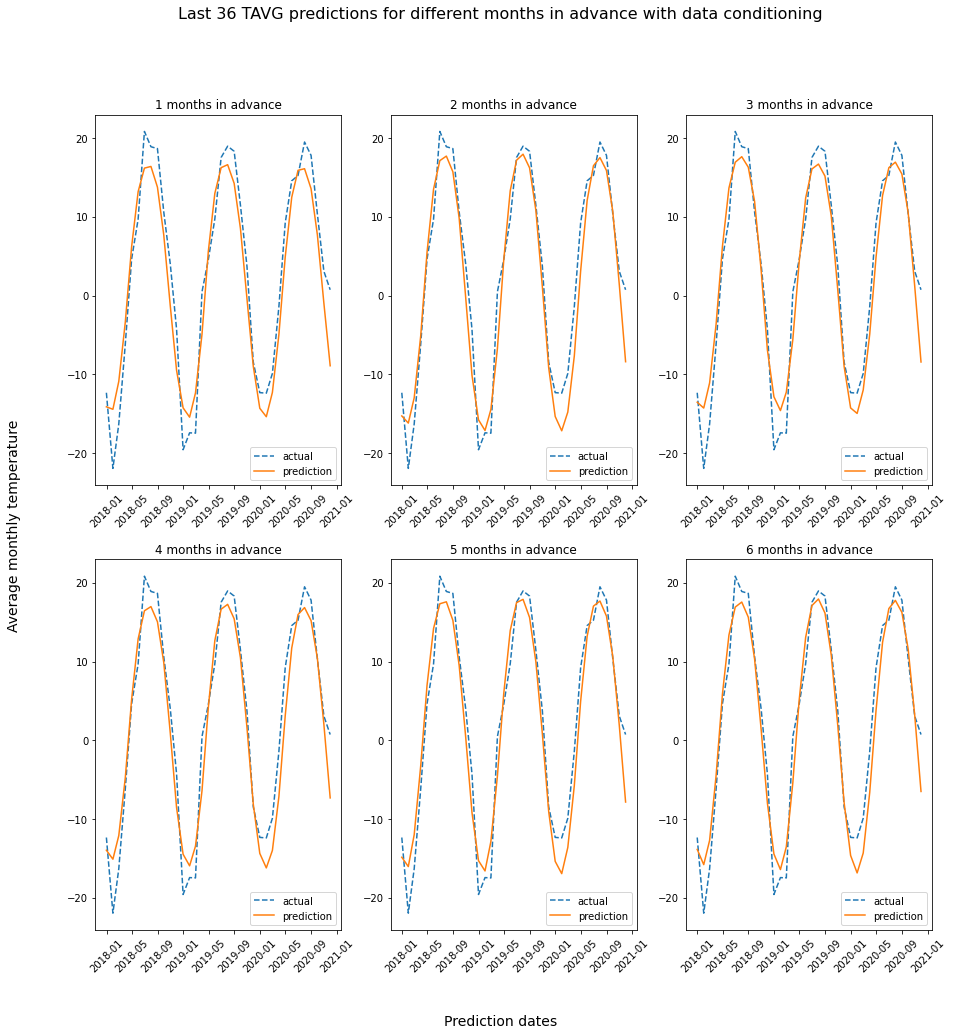

In [ ]:
# last 3 years predictions comparison
title = f'Last {n} TAVG predictions for different months in advance with data conditioning'
plot_subplot(df_month,test_predict_list_cond,test_target,descale_month_tavg,title,ytitle,
             np.arange(offset_max),frequency='months',n=n)

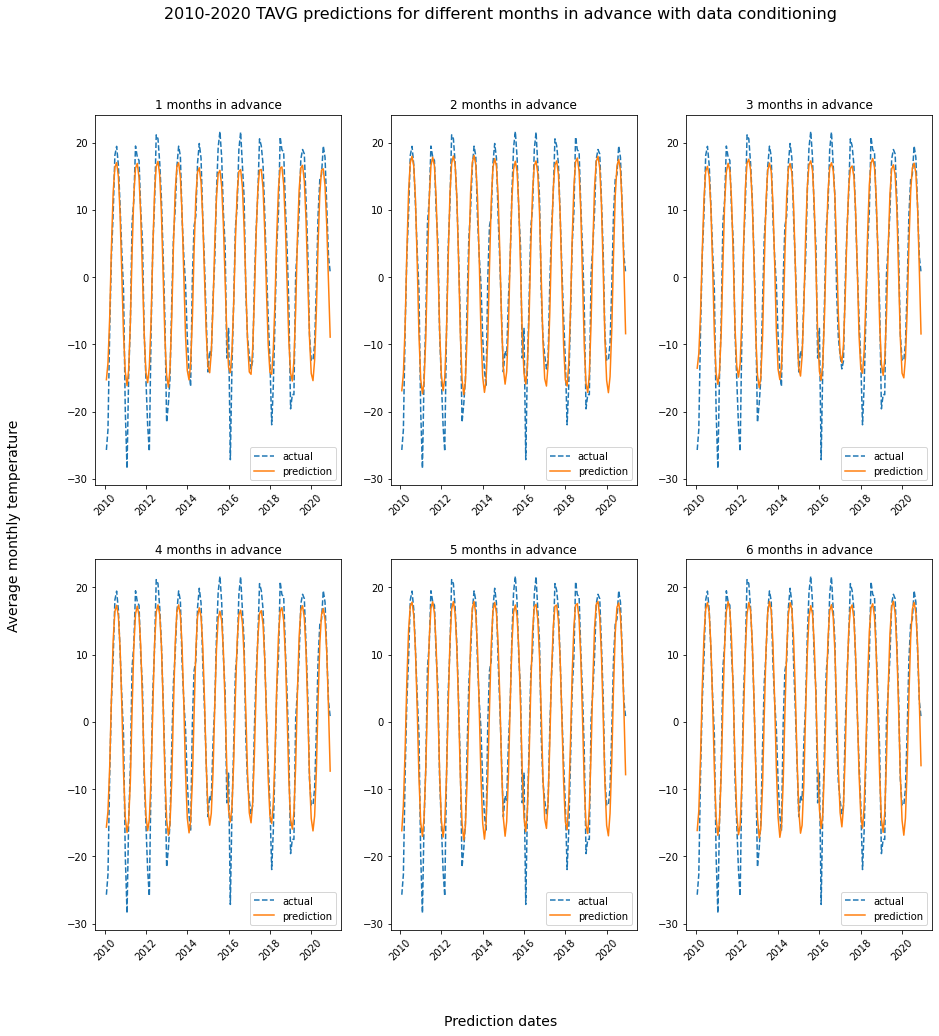

In [ ]:
# 2010-2020 predictions comparison
title = f'2010-2020 TAVG predictions for different months in advance with data conditioning'
plot_subplot(df_month,test_predict_list_cond,test_target,descale_month_tavg,title,
             ytitle,np.arange(offset_max),frequency='months')

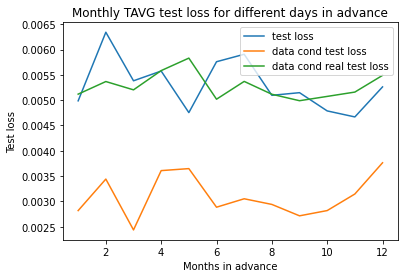

In [ ]:
# plot test loss vs offset
plt.plot(np.arange(1,offset_max+1),test_loss_list,label='test loss')
plt.plot(np.arange(1,offset_max+1),test_loss_list_cond,label='data cond test loss')
plt.plot(np.arange(1,offset_max+1),real_test_loss_list_cond,label='data cond real test loss')
plt.title('Monthly TAVG test loss for different days in advance')
plt.xlabel('Months in advance')
plt.ylabel('Test loss')
plt.legend()

As mentioned in the previous section, data conditioning in monthly temeprature predictions does not improve the performance. We basically get the same test loss and same type of predictions. It is interesting to see for how long can we predict. I will test from 120 to 600 months in advance.

In [ ]:
offset_array = np.linspace(120,600,6,dtype=int)-1

In [ ]:
# months in the history used to predict
windowsize = 36
# training data end date
train_end_date = date(2010,1,1)

# parameters of the model and training
epochs=15
batchsize=50
lstm_neurons=[128]

# list of predictions and test losses
test_predict_list = []
test_loss_list = []

# loop to predict for each offset_array
for offset in offset_array:
  # train and return hisotry, predictions, loss
  _,test_predict,test_target,test_loss = train_model(df_month_scaled['TAVG'],windowsize,
                                                         offset,train_end_date,epochs,
                                                     batchsize,lstm_neurons)
  
  test_predict_list.append(test_predict)
  test_loss_list.append(test_loss)

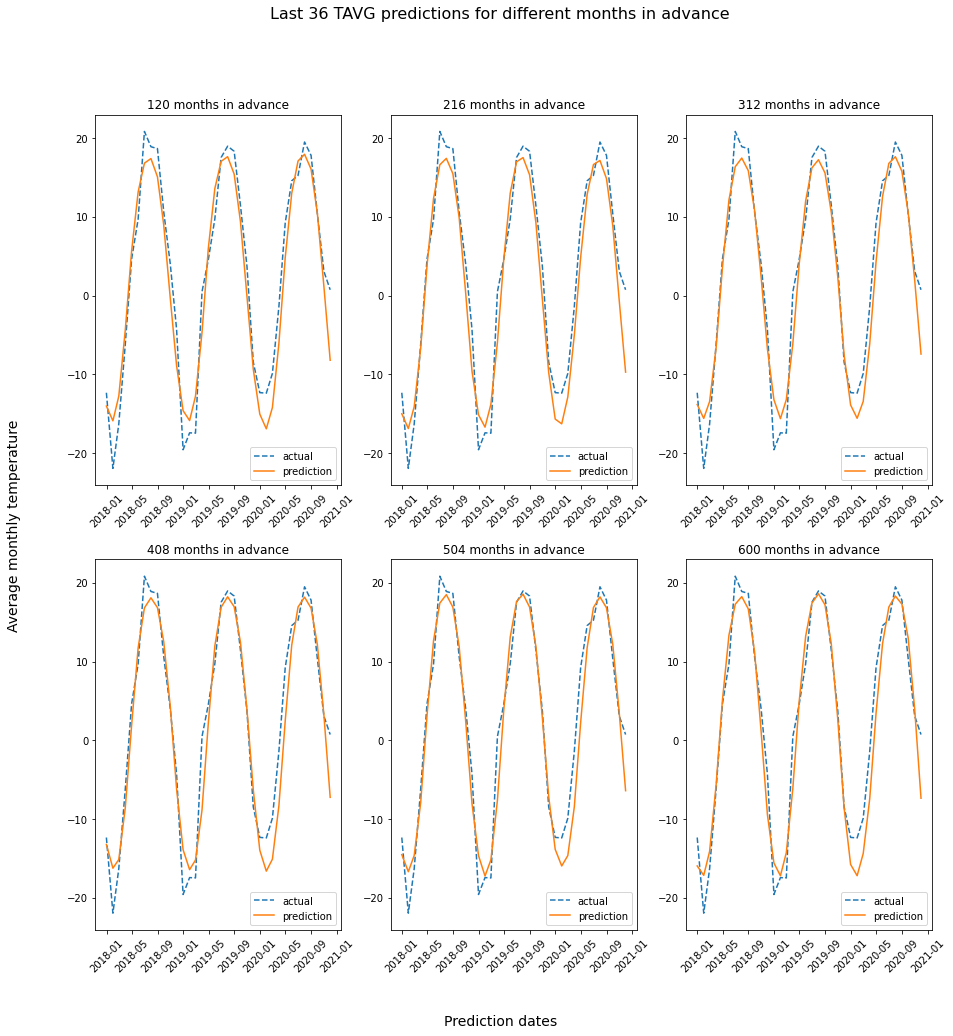

In [ ]:
# plot last two years predictions
# n = number of months to predict
n = 36
title = f'Last {n} TAVG predictions for different months in advance'
ytitle = 'Average monthly temperature'
plot_subplot(df_month,test_predict_list,test_target,descale_month_tavg,title,ytitle,
             offset_array,frequency='months',n=n)

Text(0, 0.5, 'Test loss')

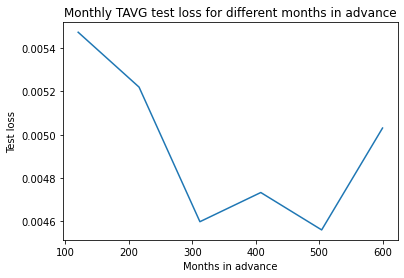

In [ ]:
# plot test loss vs offset
plt.plot(offset_array+1,test_loss_list)
plt.title('Monthly TAVG test loss for different months in advance')
plt.xlabel('Months in advance')
plt.ylabel('Test loss')

As it can be seen, the predictions and test losses are not bad. We can predict any time in advance for monthly temperatures, if we consider the sinusoidal predictions are good enough. Let's see the monthly temperatures for the whole range.

Text(0.5, 1.0, 'Monthly TAVG for the whole range')

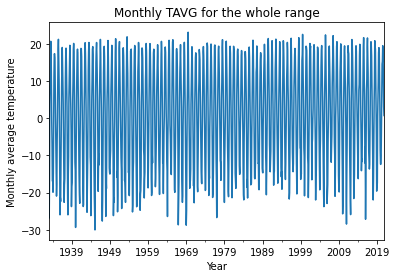

In [ ]:
df_month.TAVG.plot()
plt.xlabel('Year')
plt.ylabel('Monthly average temperature')
plt.title('Monthly TAVG for the whole range')

For this station, the maximum temperature is quite constant, around 20 degrees. The minimum temperatures vary from -20 to -30 degrees. However, one can see that there might be a hidden patter for minimum temperature. Therefore I will try to increase the windowsize to 600 (50 years) to see if it is possible to catch this pattern.

In [ ]:
# months in the history used to predict
windowsize = 600
# 1 month in advance
offset = 0
# training data end date
train_end_date = date(2010,1,1)

# parameters of the model and training
epochs=15
batchsize=50
# two LSTM layers with 128 and 64 neurons
lstm_neurons=[128,64]
# two dense hidden layers with 128 and 64 neurons
# one dense output layer with 1 neuron
dense_neurons = [128,64,1]
# use sigmmoid act function for all dense layers
act = ['sigmoid']*3

# train and return hisotry, predictions, loss
history,test_predict,test_target,test_loss = train_model(df_month_scaled['TAVG'],windowsize,offset,train_end_date,
                                         epochs,batchsize,lstm_neurons,
                                         dense_neurons,act)

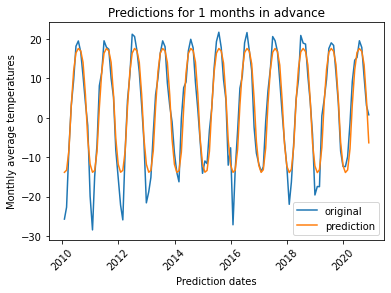

In [ ]:
# plot original with different predictions
plt.plot(df_month.iloc[-131:].index,descale(test_target[-131:],descale_month_tavg),label='original')
plt.plot(df_month.iloc[-131:].index,descale(test_predict[-131:],descale_month_tavg),label='prediction')
plt.xticks(rotation=45)
plt.title(f'Predictions for {offset+1} months in advance')
plt.xlabel('Prediction dates')
plt.ylabel('Monthly average temperatures')
plt.legend()

In [ ]:
# print test loss
test_loss

0.006249242927879095

Even for a very complex network and a very large windowsize, it is not possible to accurately predict the maxima and minima. Therefore, for monthly temperatures, we can predict more or less for any time in advance, but the maxima and minima each year is not possible to predict by using historical data.

# 10. DAILY RAINFALL PREDICTIONS

Daily rainfall prediction is extremely difficult. The reason is because for many days, the rainfall is zero and suddenly, there is precipitation. I will show one time sequence.

In [ ]:
# days in the history used to predict
windowsize = 45
# 1 day in advance
offset = 0
# get time sequences data
data = timeseqs(df_scaled.PRCP,windowsize,offset)

In [ ]:
# training data end date
train_end_date = date(2020,1,1)
# get training and testing data
train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)

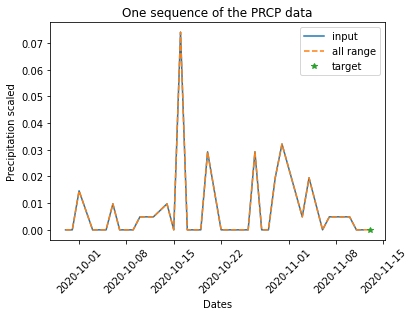

In [ ]:
# plot input and target of the last sequence
n = -1

# plot the input data
plt.plot(data.iloc[n-offset-windowsize:n-offset].index,
         data.iloc[n].drop('target'),label='input')

# plot all data
plt.plot(df_scaled.PRCP.loc[data.iloc[n-offset-windowsize].name:],'--',label='all range')

# plot the target
plt.plot(data.iloc[n].name,
         data['target'].iloc[n],'*',label='target')

plt.xticks(rotation=45)
plt.title('One sequence of the PRCP data')
plt.xlabel('Dates')
plt.ylabel('Precipitation scaled')
plt.legend()

We can see that there is no pattern. Some days are just zero.

## 10.1 Model structure

### 10.1.1 LSTM type and activation function

For simplicity, I will just show the LSTM layer and linear and sigmoid activaition functions (bi-LSTM does not improve accuracy). Here, I will use validation_split in the training. In the temperature predictions, if one tries to plot the validation loss, one will see a non-overfitting training. Here, we are overfitting.

linear test loss = 0.001134966965764761
sigmoid test loss = 0.0012098439037799835


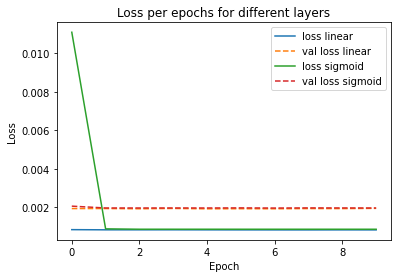

In [ ]:
# LSTM neurons
neurons = 64
# predictions list
predictions = []

# LSTM layer
method = 'LSTM'
# for different type of activation functions in the dense layer
for act in ['linear','sigmoid']:
  # create model
  model = model_lstm_act(method,neurons,windowsize,act)
  # train model using validation_split
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0,
                    validation_split=0.1)
  # append predictions
  predictions.append(model.predict(test_input))
  # plot loss per epochs
  plt.plot(history.history['loss'], label=f'loss {act}')
  plt.plot(history.history['val_loss'],'--', label=f'val loss {act}')
  # print test loss
  print(f'{act} test loss = {model.evaluate(test_input,test_target,verbose=0)}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epochs for different layers')
plt.legend()

Both type of activation functions give a similar loss. Moreover, the model is overfitting, as anticipated previously. I have tried more complex structures with dense layers and dropout layers but it is always overfitting.

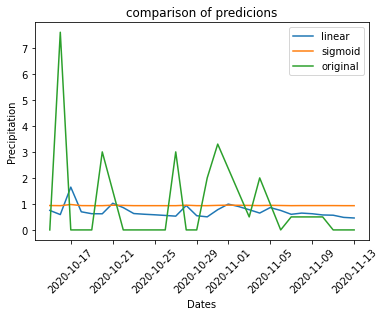

In [ ]:
# comparison of the two predicions
plt.plot(df.iloc[-30:].index,descale(predictions[0][-30:],descale_prcp),label='linear')
plt.plot(df.iloc[-30:].index,descale(predictions[1][-30:],descale_prcp),label='sigmoid')
plt.plot(df.iloc[-30:].index,descale(test_target[-30:],descale_prcp),label='original')
plt.xticks(rotation=45)
plt.title('comparison of predicions')
plt.xlabel('Dates')
plt.ylabel('Precipitation')
plt.legend()

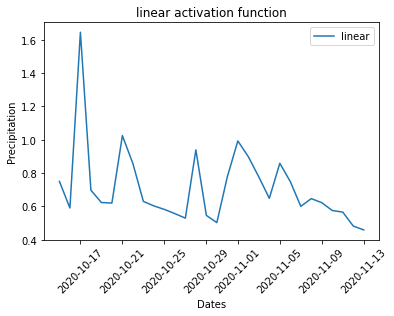

In [ ]:
# plot predicions of linear act function
plt.plot(df.iloc[-30:].index,descale(predictions[0][-30:],descale_prcp),label='linear')
plt.xticks(rotation=45)
plt.title('linear activation function')
plt.xlabel('Dates')
plt.ylabel('Precipitation')
plt.legend()

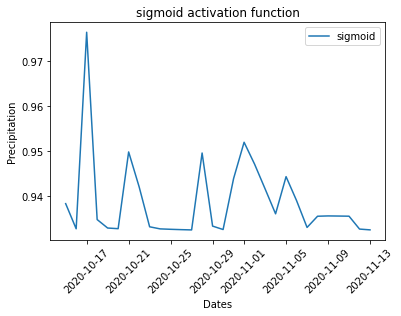

In [ ]:
# plot predicions of sigmoid act function
plt.plot(df.iloc[-30:].index,descale(predictions[1][-30:],descale_prcp),label='sigmoid')
plt.xticks(rotation=45)
plt.title('sigmoid activation function')
plt.xlabel('Dates')
plt.ylabel('Precipitation')
plt.legend()

As it can be seen in the previous graphs, both predictions look like the original dataset but shifted by one day. The LSTM internally is trained such that if the previous date has rained, the next day will also rain. Both activation functions uses the previous day to predict the next day. However, the linear function has a bigger amplitude, the sigmoid function looks like a straight horizontal line compared to the original data. Therefore, I will use the linear activation function for daily rainfall prediction.

### 10.1.2 1 day in advance model structure

I will use data after data conditioning as we will see in the next sections, it slightly improves the predictions.

In [ ]:
# neurons array
neuron_array = np.array([2,8,16,32,50,64,100,128])

In [ ]:
# days in the history used to predict
windowsize = 20
# 1 day in advance
offset = 0
# get time sequences data
data = timeseqs(df_prcp_cond,windowsize,offset)
# training data end date
train_end_date = date(2020,1,1)
# get training and testing data
train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)

For single LSTM layer

In [ ]:
# create loss array
loss = np.zeros(len(neuron_array))
# loop for each neuron in the neuron_array
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[lstm_neuron],act=['linear'])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for single LSTM layer')

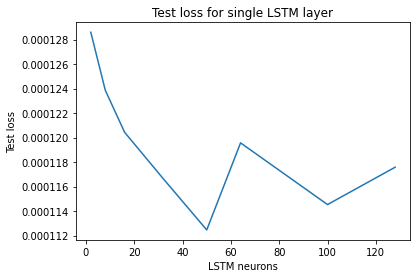

In [ ]:
# plot the loss for one day in advance prediction using single LSTM layer
plt.plot(neuron_array,loss)
plt.xlabel('LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer')

Although we see that the test loss has decreased, they are all very close (see the y axis range). I will test by adding a second LSTM layer.

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the second LSTM layer
# first LSTM layer with 128 neurons
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128,lstm_neuron],act=['linear'])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for double LSTM layer')

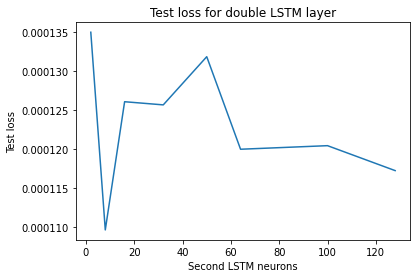

In [ ]:
# plot the loss for one day in advance prediction using two LSTM layers
# first LSTM layer with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Second LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for double LSTM layer')

The test loss is not lowered by adding an extra LSTM layer. I will add a hidden dense layer instead.

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the hidden layer
# LSTM layer with 128 neurons
for i,dense_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128],dense_neurons=[dense_neuron,1],act=['linear','linear'])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for single LSTM layer with dense hidden layer')

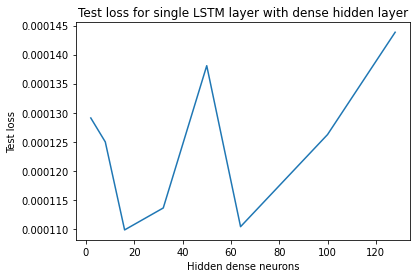

In [ ]:
# plot the loss for one day in advance prediction using LSTM+hidden dense layer
# LSTM layers with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Hidden dense neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer with dense hidden layer')

As before, the test loss is not lowered.

### 10.1.3 14 days in advance model structure

In [ ]:
# neurons array
neuron_array = np.array([2,8,16,32,50,64,100,128])

In [ ]:
# days in the history used to predict
windowsize = 45
# 14 days in advace
offset = 13
data = timeseqs(df_prcp_cond,windowsize,offset)
# training data end date
train_end_date = date(2020,1,1)
# get training and testing data
train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)

For single LSMT layer

In [ ]:
# create loss array
loss = np.zeros(len(neuron_array))
# loop for each neuron in the neuron_array
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[lstm_neuron],act=['linear'])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for single LSTM layer')

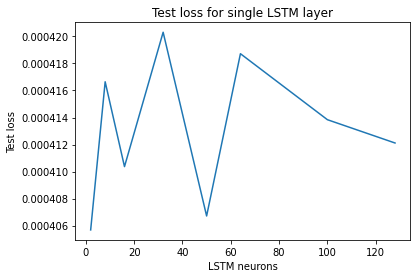

In [ ]:
# plot the loss for one day in advance prediction using single LSTM layer
plt.plot(neuron_array,loss)
plt.xlabel('LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer')

The test losses are very close. I will add a second LSTM layer.

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the second LSTM layer
# first LSTM layer with 128 neurons
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128,lstm_neuron],act=['linear'])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for double LSTM layer')

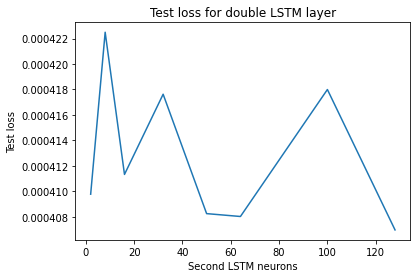

In [ ]:
# plot the loss for one day in advance prediction using two LSTM layers
# first LSTM layer with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Second LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for double LSTM layer')

The second LSTM layer does not improve the performance. I will now add a hidden dense layer

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the hidden layer
# LSTM layer with 128 neurons
for i,dense_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128],dense_neurons=[dense_neuron,1],act=['linear','linear'])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for single LSTM layer with dense hidden layer')

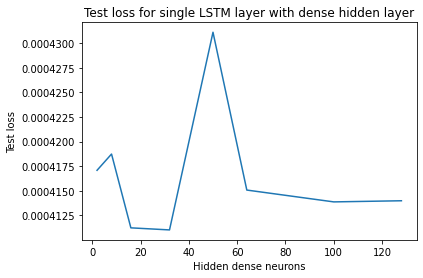

In [ ]:
# plot the loss for one day in advance prediction using LSTM+hidden dense layer
# LSTM layers with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Hidden dense neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer with dense hidden layer')

As before, the second LSTM layer does not improve the performance.

After looking at the two extremes, I would choose a model with one LSTM layers with 128 neurons. To sum up: LSTM(128)+Dense(1), the final dense layer is the output layer, with linear activation function.

### 10.1.4 Windowsize

In [ ]:
windowsize_array = np.array([45,60,75,90,105])

In [ ]:
# 7 days in advace
offset = 6

In [ ]:
# create loss array
loss = np.zeros(len(windowsize_array))

# loop for each window in the windowsize_array
for i,windowsize in enumerate(windowsize_array):
  # get time sequences data
  data = timeseqs(df_tavg_cond,windowsize,offset)
  # get training and testing data
  train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)
  # create model with 128 LSTM neurons
  model = model_type(windowsize,lstm_neurons=[128],act=['linear'])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for 7 months in advance')

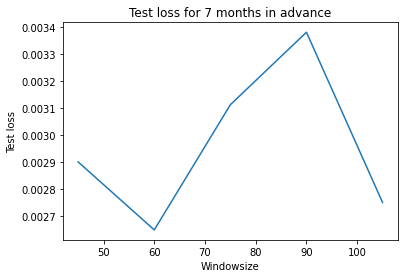

In [ ]:
# plot the loss for 7 days in advance prediction
plt.plot(windowsize_array,loss)
plt.xlabel('Windowsize')
plt.ylabel('Test loss')
plt.title(f'Test loss for {offset+1} months in advance')

In [ ]:
# 14 days in advace
offset = 13

In [ ]:
# create loss array
loss = np.zeros(len(windowsize_array))

# loop for each window in the windowsize_array
for i,windowsize in enumerate(windowsize_array):
  # get time sequences data
  data = timeseqs(df_tavg_cond,windowsize,offset)
  # get training and testing data
  train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)
  # create model with 128 LSTM neurons
  model = model_type(windowsize,lstm_neurons=[128],act=['linear'])
  # train model
  history=model.fit(train_input,train_target,epochs=10,batch_size=100,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for 14 months in advance')

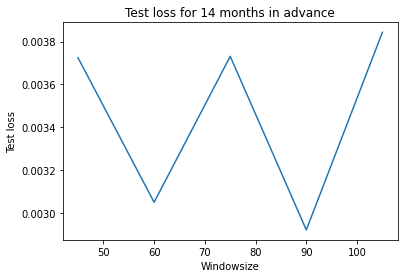

In [ ]:
# plot the loss for 14 days in advance prediction
plt.plot(windowsize_array,loss)
plt.xlabel('Windowsize')
plt.ylabel('Test loss')
plt.title(f'Test loss for {offset+1} months in advance')

It seems that there is a minimum at windowsize=60. I will use this, but once again, the windowsize is not very crucial.

## 10.2 One day in advance

In [ ]:
# days in the history used to predict
windowsize = 60
# days in advace = offset + 1
offset = 0
# training data end date
train_end_date = date(2020,1,1)

In [ ]:
# parameters of the model and training
epochs=10
batchsize=100
lstm_neurons=[128]

# get history, targets, predictions and test loss for original data
history,test_predict,test_target,test_loss = train_model(df_scaled['PRCP'],windowsize,
                                                         offset,train_end_date,epochs,batchsize,
                                                         lstm_neurons,act=['linear'])
# get history, targets, predictions and test loss after data conditioning
history_cond,test_predict_cond,test_target_cond,test_loss_cond = train_model(df_prcp_cond,windowsize,
                                                          offset,train_end_date,epochs,batchsize,
                                                          lstm_neurons,act=['linear'])

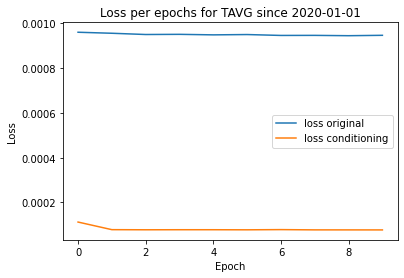

In [ ]:
# plot loss per epochs
plt.plot(history.history['loss'], label='loss original')
plt.plot(history_cond.history['loss'], label='loss conditioning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss per epochs for TAVG since {train_end_date}')
plt.legend()

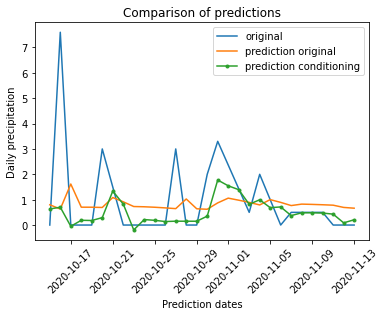

In [ ]:
# plot original with different predictions
plt.plot(df.iloc[-30:].index,descale(test_target[-30:],descale_prcp),label='original')
plt.plot(df.iloc[-30:].index,descale(test_predict[-30:],descale_prcp),label='prediction original')
plt.plot(df.iloc[-30:].index,descale(test_predict_cond[-30:],descale_prcp),'.-',label='prediction conditioning')
plt.xticks(rotation=45)
plt.title('Comparison of predictions')
plt.xlabel('Prediction dates')
plt.ylabel('Daily precipitation')
plt.legend()

In [ ]:
print(f'test loss for original {test_loss}')
print(f'test loss after conditioning {test_loss_cond}')
# real test loss of the predictions using data conditioning
# test_predict_cond is compared with test_target, the real targets
print(f'real test loss after conditioning {mean_squared_error(test_target,test_predict_cond)}')

test loss for original 0.0011223549954593182
test loss after conditioning 0.0001256915129488334
real test loss after conditioning 0.0008167898007539038


As it can be seen, there are some negative predictions. I will replace these with zero and print the test losses again.

In [ ]:
# replace negative values to zero
test_predict_cond[test_predict_cond<0]=0

In [ ]:
# print the losses after replacing negative values
print(f'test loss for original {test_loss}')
print(f'test loss after conditioning {mean_squared_error(test_target_cond,test_predict_cond)}')
# real test loss of the predictions using data conditioning
# test_predict_cond is compared with test_target, the real targets
print(f'real test loss after conditioning {mean_squared_error(test_target,test_predict_cond)}')

test loss for original 0.0011223549954593182
test loss after conditioning 0.00012410568814227464
real test loss after conditioning 0.0008153511225437484


Using data conditioning, one gets slightly better predictions. But we can't predict the first day that it starts to rain. 

## 10.3 Comparison of different days in advance

In [ ]:
# days in the history used to predict
windowsize = 60
# training data end date
train_end_date = date(2020,1,1)

# parameters of the model and training
epochs=10
batchsize=100
lstm_neurons=[128]

# list of predictions and test losses
test_predict_list = []
test_loss_list = []

# loop to predict from 1 to 14 days in advance
# offset from 0 to 13
offset_max = 14
for offset in range(offset_max):
  # train and get predictions, targets and loss
  _,test_predict,test_target,test_loss = train_model(df_scaled['PRCP'],windowsize,
                                                      offset,train_end_date,epochs,batchsize,
                                                     lstm_neurons,act=['linear'])
  
  test_predict_list.append(test_predict)
  test_loss_list.append(test_loss)

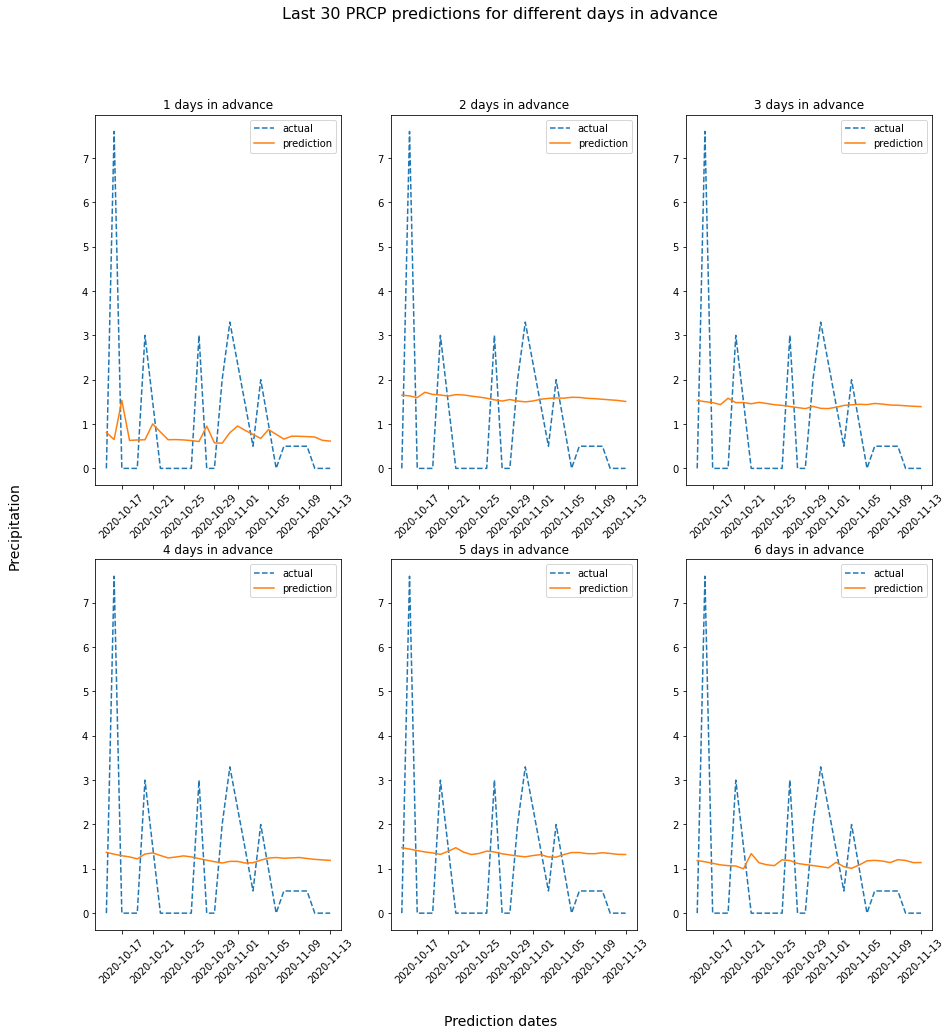

In [ ]:
# last month predictions comparison
n = 30
title = f'Last {n} PRCP predictions for different days in advance'
ytitle = 'Precipitation'
plot_subplot(df,test_predict_list,test_target,descale_prcp,title,ytitle,
             np.arange(offset_max),n=n)

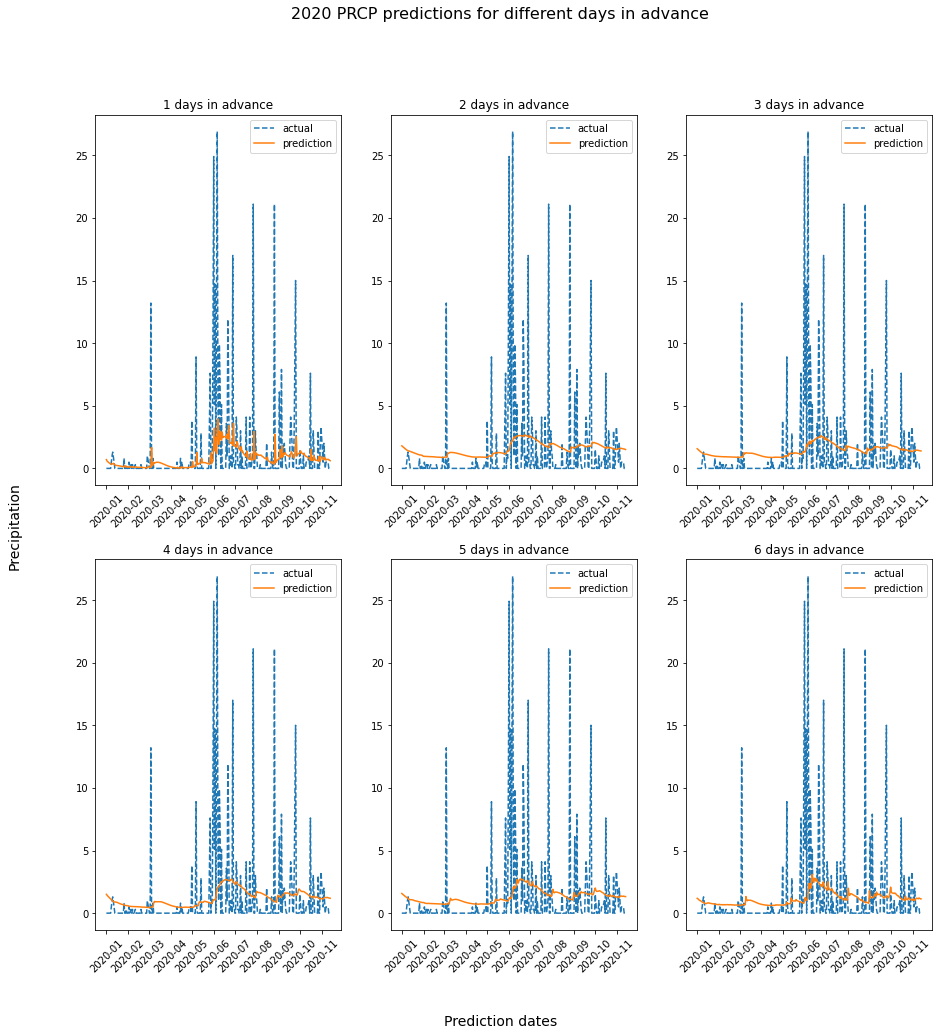

In [ ]:
# 2020 predictions comparison
title = f'2020 PRCP predictions for different days in advance'
plot_subplot(df,test_predict_list,test_target,descale_prcp,title,ytitle,np.arange(offset_max))

Text(0, 0.5, 'Test loss')

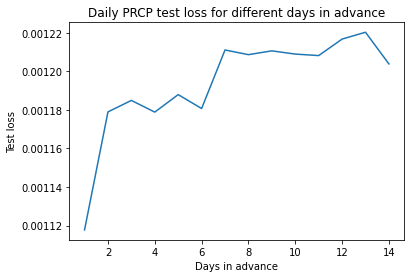

In [ ]:
# plot test loss vs offset
plt.plot(np.arange(1,offset_max+1),test_loss_list)
plt.title('Daily PRCP test loss for different days in advance')
plt.xlabel('Days in advance')
plt.ylabel('Test loss')

It seems that the losses increase as we increase the days in advance, but the losses are still very close, from 0.00112 to 0.00122. Now I will use data after data conditioning.

In [ ]:
# list of predictions and test losses
test_predict_list_cond = []
test_loss_list_cond = []
real_test_loss_list_cond = []

# loop to predict from 1 to 14 days in advance
# offset from 0 to 13
offset_max = 14
for offset in range(offset_max):
  # train and get predictions and loss
  _,test_predict,_,test_loss = train_model(df_prcp_cond,windowsize,
                                           offset,train_end_date,epochs,batchsize,
                                           lstm_neurons,act=['linear'])
  
  # replace negative predictions with zeroes
  test_predict[test_predict<0]=0

  test_predict_list_cond.append(test_predict)
  test_loss_list_cond.append(test_loss)
  # real test loss
  real_test_loss_list_cond.append(mean_squared_error(test_target,test_predict))

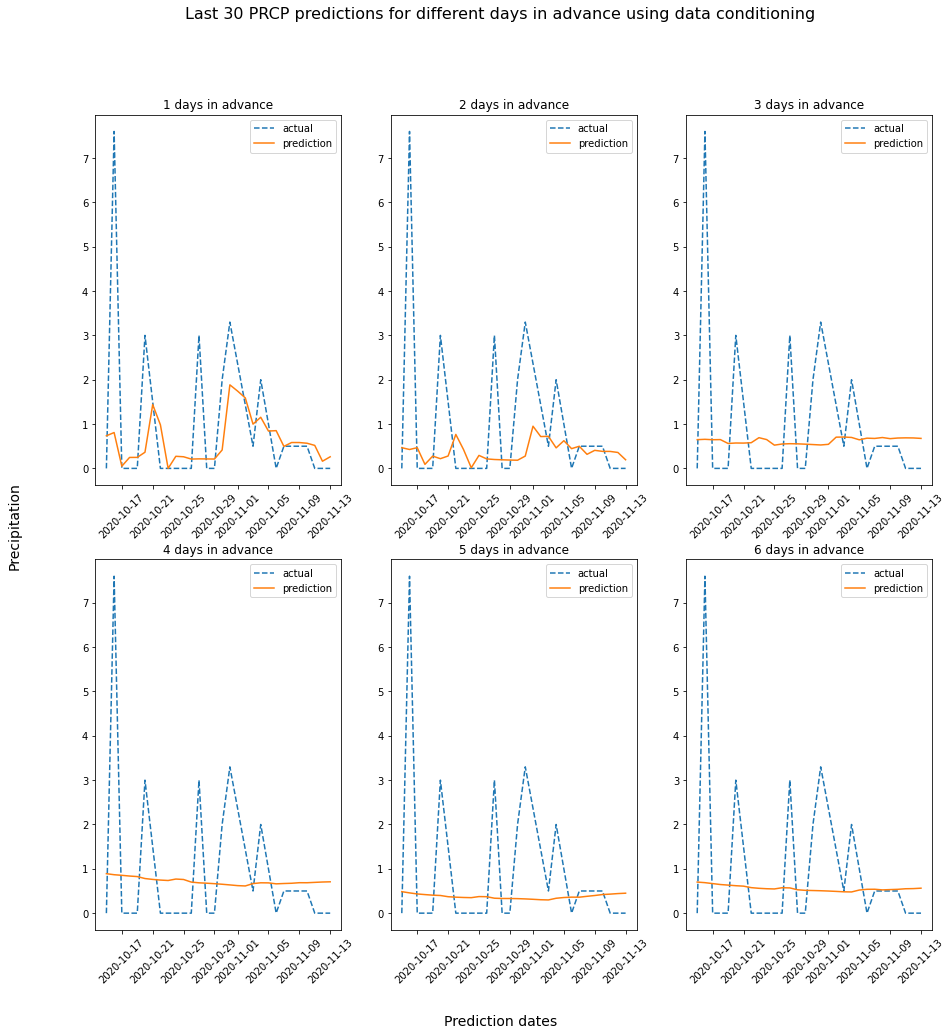

In [ ]:
# last month predictions comparison
title = f'Last {n} PRCP predictions for different days in advance using data conditioning'
plot_subplot(df,test_predict_list_cond,test_target,descale_prcp,title,ytitle,np.arange(offset_max),n=n)

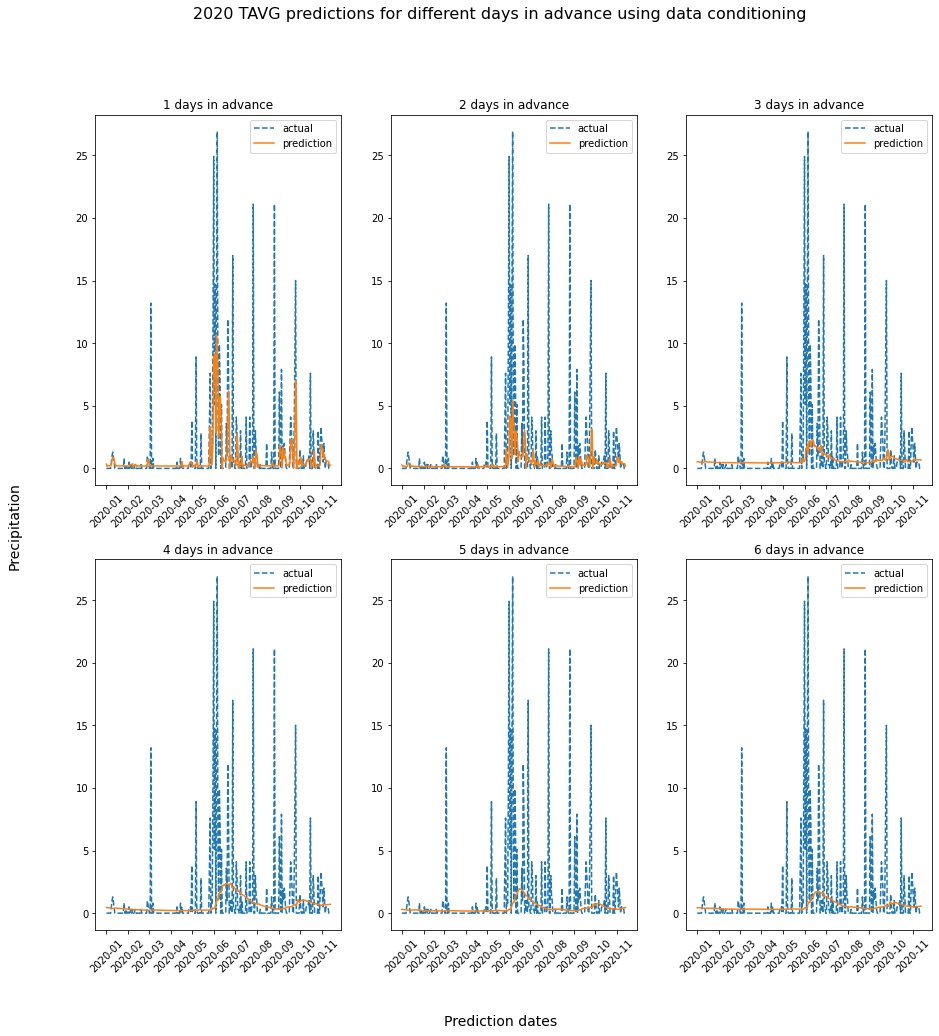

In [ ]:
# 2020 predictions comparison
title = f'2020 TAVG predictions for different days in advance using data conditioning'
plot_subplot(df,test_predict_list_cond,test_target,descale_prcp,title,ytitle,np.arange(offset_max))

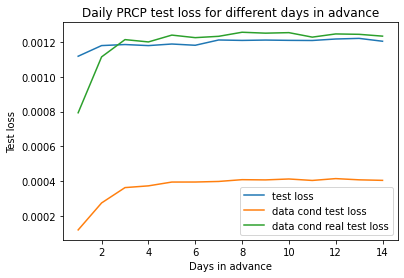

In [ ]:
# plot test loss vs offset
plt.plot(np.arange(1,offset_max+1),test_loss_list,label='test loss')
plt.plot(np.arange(1,offset_max+1),test_loss_list_cond,label='data cond test loss')
plt.plot(np.arange(1,offset_max+1),real_test_loss_list_cond,label='data cond real test loss')
plt.title('Daily PRCP test loss for different days in advance')
plt.xlabel('Days in advance')
plt.ylabel('Test loss')
plt.legend()

Using data conditioning, we can only get better predictions with 1 day in advance. As it can be seen in the previous graphs, this is the only case where we somehow capture the shape of the rainfall. After 1 day in advance, we get a very constant test loss. The models are trained such that we always get some precipitation and overall (at large scales) the loss is somehow minimised. 

Strictly speacking, we can't predict accurately because we don't know when it starts to rain, we can't predict the first day that it rains. We can only predict rainfall if it has rained in the last day. However, the best decent predictions are only from data conditioning and 1 day in advance. By decent I mean we get a similar shape than original data. For 2 days in advance, this is already impossible. I will show this in the following by using a more complex model

In [ ]:
# days in the history used to predict
windowsize = 60
# 2 days in advance
offset = 1
# training data end date
train_end_date = date(2020,1,1)

# parameters of the model and training
epochs=10
batchsize=100
# two LSTM layers with 128 and 64 neurons
lstm_neurons=[128,64]
# two dense hidden layers with 64 and 32 neurons
# one dense output layer with 1 neuron
dense_neurons = [64,32,1]
# use linear act function for all dense layers
act = ['linear']*3

# train and return hisotry, predictions, loss
history,test_predict,_,test_loss = train_model(df_prcp_cond,windowsize,offset,train_end_date,
                                         epochs,batchsize,lstm_neurons=lstm_neurons,
                                         dense_neurons=dense_neurons,act=act)

In [ ]:
# replace negative predictions with zeroes
test_predict[test_predict<0]=0

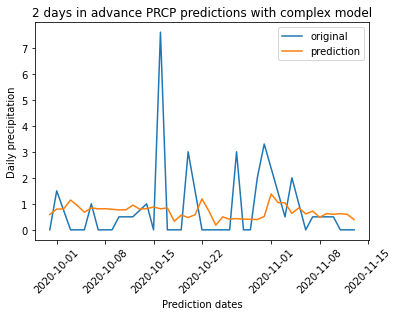

In [ ]:
# plot predictions of the last 45 days for original data
plt.plot(df.iloc[-45:].index,descale(test_target[-45:],descale_prcp),label='original')
plt.plot(df.iloc[-45:].index,descale(test_predict[-45:],descale_prcp),label='prediction')
plt.xticks(rotation=45)
plt.title(f'{offset+1} days in advance PRCP predictions with complex model')
plt.xlabel('Prediction dates')
plt.ylabel('Daily precipitation')
plt.legend()

In [ ]:
# this test_target is the real target, not the data after data conditioning
print(f'loss = {mean_squared_error(test_target,test_predict)}')

loss = 0.0010996553828293751


As it can be seen, for 2 days in advance, we can't even get a general shape. The complex model is trained such that it always returns some rainfall and averaged, we get try to reduce the loss. The loss is also similar than the simpler model case. This ensures again that the chosen model is enough. More complex models will do a similar job.

# 11. MONTHLY RAINFALL PREDICTIONS

## 11.1 Model structure

As before, I will use the data after data conditioning to construct the model.

### 11.1.1 LSTM type and activation function

In [ ]:
# months in the history used to predict
windowsize = 12
# 1 month in advace
offset = 0
# get time sequences data
data = timeseqs(df_month_prcp_cond,windowsize,offset)

In [ ]:
# training data end date
train_end_date = date(2010,1,1)
# get training and testing data
train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)

LSTM linear test loss = 0.0026347499806433916
LSTM sigmoid test loss = 0.010959276929497719
Bi-LSTM linear test loss = 0.0038172684144228697
Bi-LSTM sigmoid test loss = 0.010932686738669872


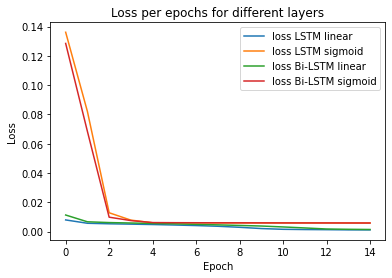

In [ ]:
# number of LSTM neurons
neurons = 20

# for different type of LSTM layer
for method in ['LSTM','Bi-LSTM']:
  # for different type of activation functions in the dense layer
  for act in ['linear','sigmoid']:
    # create model
    model = model_lstm_act(method,neurons,windowsize,act)
    # train model
    history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
    # plot loss per epochs
    plt.plot(history.history['loss'], label=f'loss {method} {act}')
    # print test loss
    print(f'{method} {act} test loss = {model.evaluate(test_input,test_target,verbose=0)}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epochs for different layers')
plt.legend()

It seems that bidirectional layers don't give better performance. Linear seems to work better than sigmoid. I will try and use another example to show this.

In [ ]:
# months in the history used to predict
windowsize = 24
# 12 months in advace
offset = 11
data = timeseqs(df_month_prcp_cond,windowsize,offset)
# training data end date
train_end_date = date(2010,1,1)
# get training and testing data
train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)

LSTM linear test loss = 0.004044824745506048
LSTM sigmoid test loss = 0.01033883634954691
Bi-LSTM linear test loss = 0.003799513215199113
Bi-LSTM sigmoid test loss = 0.010206514969468117


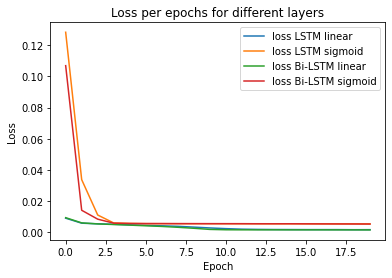

In [ ]:
# number of LSTM neurons
neurons = 32

# for different type of LSTM layer
for method in ['LSTM','Bi-LSTM']:
  # for different type of activation functions in the dense layer
  for act in ['linear','sigmoid']:
    # create model
    model = model_lstm_act(method,neurons,windowsize,act)
    # train model
    history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
    # plot loss per epochs
    plt.plot(history.history['loss'], label=f'loss {method} {act}')
    # print test loss
    print(f'{method} {act} test loss = {model.evaluate(test_input,test_target,verbose=0)}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss per epochs for different layers')
plt.legend()

As before, linear works best here. I will use simple LSTM layer with linear activation function in the dense layers.

### 11.1.2 1 month in advance model structure

Again, I will use data conditoining to construct the model.

In [ ]:
# neurons array
neuron_array = np.array([2,8,16,32,50,64,100,128])

In [ ]:
# months in the history used to predict
windowsize = 18
# 1 month in advace
offset = 0
# get time sequences data
data = timeseqs(df_month_prcp_cond,windowsize,offset)
# training data end date
train_end_date = date(2010,1,1)
# get training and testing data
train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)

For single LSTM layer

In [ ]:
# create loss array
loss = np.zeros(len(neuron_array))
# loop for each neuron in the neuron_array
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[lstm_neuron],act=['linear'])
  # train model
  history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for single LSTM layer')

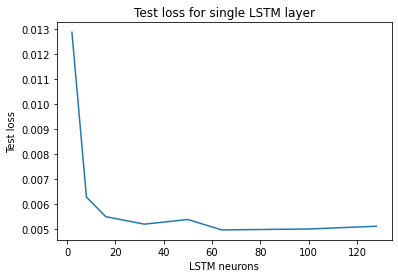

In [ ]:
# plot the loss for one month in advance prediction using single LSTM layer
plt.plot(neuron_array,loss)
plt.xlabel('LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer')

As long as the number of neurons is not too small, weget quite constant test loss. I will now add a second LSTM layer.

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the second LSTM layer
# first LSTM layer with 128 neurons
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128,lstm_neuron],act=['linear'])
  # train model
  history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for double LSTM layer')

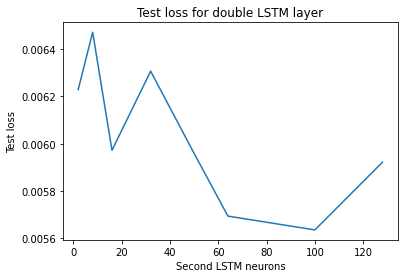

In [ ]:
# plot the loss for one month in advance prediction using double LSTM layer
# first LSTM layer with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Second LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for double LSTM layer')

The second LSTM layer does not improve the performance. I will now add instead a hidden dense layer (with single LSTM layer).

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the hidden layer
# LSTM layer with 128 neurons
for i,dense_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128],dense_neurons=[dense_neuron,1],
                     act=['linear','linear'])
  # train model
  history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for single LSTM layer with dense hidden layer')

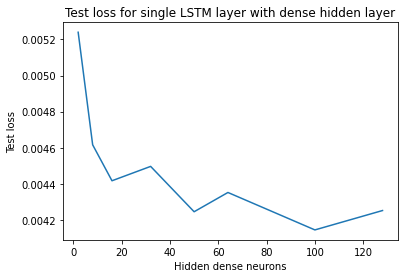

In [ ]:
# plot the loss for one month in advance prediction using LSTM+hidden dense layer
# LSTM layers with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Hidden dense neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer with dense hidden layer')

The hidden layer does reduce considerably the test loss. I will now add another hidden dense layer

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the second hidden layer
# LSTM layer with 128 neurons
# first hidden layer with 128 neurons
for i,dense_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128],dense_neurons=[128,dense_neuron,1],
                     act=['linear','linear','linear'])
  # train model
  history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for single LSTM layer with 2 dense hidden layers')

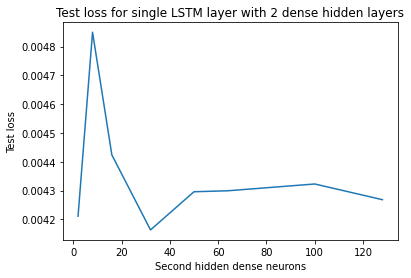

In [ ]:
# plot the loss for one month in advance prediction using LSTM+2 hidden dense layers
# LSTM layers with 128 neurons
# first hidden layer with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Second hidden dense neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer with 2 dense hidden layers')

The second hidden layer does not improve the performance. I have tried using two LSTM layers with multiple dense layers and the performance was not improved. Therefore, one LSTM plus two dense layers are enough here.

### 11.1.3 12 months in advance model structure

In [ ]:
# months in the history used to predict
windowsize = 36
# 12 months in advace
offset = 11
# get time sequences data
data = timeseqs(df_month_prcp_cond,windowsize,offset)
# training data end date
train_end_date = date(2010,1,1)
# get training and testing data
train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)

For single LSTM layer

In [ ]:
# create loss array
loss = np.zeros(len(neuron_array))
# loop for each neuron in the neuron_array
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[lstm_neuron],act=['linear'])
  # train model
  history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for single LSTM layer')

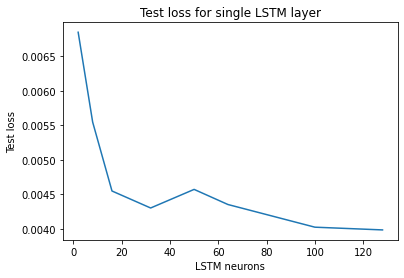

In [ ]:
# plot the loss for one month in advance prediction using single LSTM layer
plt.plot(neuron_array,loss)
plt.xlabel('LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer')

Quite constant test loss unless to little number of LSTM neurons. I will add a second LSTM layer.

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the second LSTM layer
# first LSTM layer with 128 neurons
for i,lstm_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128,lstm_neuron],act=['linear'])
  # train model
  history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for double LSTM layer')

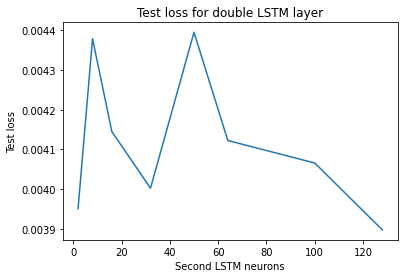

In [ ]:
# plot the loss for one month in advance prediction using single LSTM layer
# first LSTM layer with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Second LSTM neurons')
plt.ylabel('Test loss')
plt.title('Test loss for double LSTM layer')

The second LSTM layer does not improve the performance. I will add instead a hidden dense layer.

In [ ]:
# loop for each neuron in the neuron_array
# represents the neurons for the hidden layer
# LSTM layer with 128 neurons
for i,dense_neuron in enumerate(neuron_array):
  # create model 
  model = model_type(windowsize,lstm_neurons=[128],dense_neurons=[dense_neuron,1],act=['linear','linear'])
  # train model
  history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
  # calculate loss
  loss[i] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for single LSTM layer with dense hidden layer')

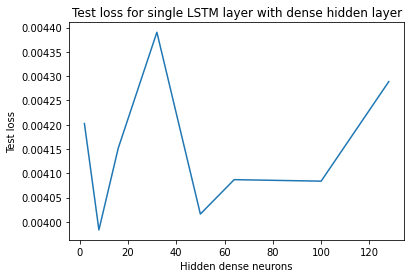

In [ ]:
# plot the loss for one month in advance prediction using LSTM+hidden dense layer
# LSTM layers with 128 neurons
plt.plot(neuron_array,loss)
plt.xlabel('Hidden dense neurons')
plt.ylabel('Test loss')
plt.title('Test loss for single LSTM layer with dense hidden layer')

The hidden dense layer does not improve the performance.

After looking at the two extremes, I would choose a model with one LSTM layers with 128 neurons, and one hidden dense layer with 128 neurons. To sum up: LSTM(128)+Dense(128)+Dense(1), the final dense layer is the output layer, with linear activation functions for all dense layers.

### 11.1.4 Windowsize

As in monthly temperature, I will loop each windowsize 3 times because this training is much shorter than daily basis.

In [ ]:
windowsize_array = np.array([12,18,36,48,60,72])

In [ ]:
# 6 months in advace
offset = 5

In [ ]:
# create loss array
loss = np.zeros((3,len(windowsize_array)))

# loop three times
for i in range(3):
  # loop for each window in the windowsize_array
  for j,windowsize in enumerate(windowsize_array):
    # get time sequences data
    data = timeseqs(df_month_prcp_cond,windowsize,offset)
    # get training and testing data
    train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)
    # create model with 128 LSTM neurons and a hidden dense layer with 128 neurons
    model = model_type(windowsize,lstm_neurons=[128],dense_neurons=[128,1],
                       act=['linear']*2)
    # train model
    history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
    # calculate loss
    loss[i,j] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for 6 months in advance')

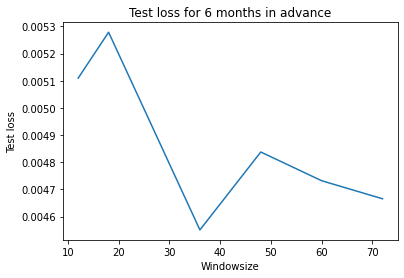

In [ ]:
# plot the loss for 6 months in advance prediction
plt.plot(windowsize_array,np.mean(loss,0))
plt.xlabel('Windowsize')
plt.ylabel('Test loss')
plt.title(f'Test loss for {offset+1} months in advance')

In [ ]:
# months in advace = offset + 1
offset = 11

In [ ]:
# create loss array
loss = np.zeros((3,len(windowsize_array)))

# loop three times
for i in range(3):
  # loop for each window in the windowsize_array
  for j,windowsize in enumerate(windowsize_array):
    # get time sequences data
    data = timeseqs(df_month_prcp_cond,windowsize,offset)
    # get training and testing data
    train_input,train_target,test_input,test_target = get_train_and_test_data(data,train_end_date,windowsize)
    # create model with 128 LSTM neurons and a hidden dense layer with 128 neurons
    model = model_type(windowsize,lstm_neurons=[128],dense_neurons=[128,1],
                       act=['linear']*2)
    # train model
    history=model.fit(train_input,train_target,epochs=15,batch_size=50,verbose=0)
    # calculate loss
    loss[i,j] = model.evaluate(test_input,test_target,verbose=0)

Text(0.5, 1.0, 'Test loss for 12 months in advance')

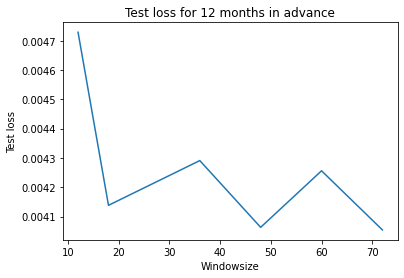

In [ ]:
# plot the loss for 12 months in advance prediction
plt.plot(windowsize_array,np.mean(loss,0))
plt.xlabel('Windowsize')
plt.ylabel('Test loss')
plt.title(f'Test loss for {offset+1} months in advance')

For 6 months in advance, 36 seems a good choice, for 12 months in advance, there is not a clear good choice, all of them are quite close. I will then use windowsize=36

## 11.2 One month in advance

In [ ]:
# months in the history used to predict
windowsize = 36
# 1 month in advace
offset = 0
# training data end date
train_end_date = date(2010,1,1)

In [ ]:
# parameters of the model and training
epochs=15
batchsize=50
lstm_neurons=[128]
dense_neurons=[128,1]
act=['linear']*2

# get history, targets, predictions and test loss for original data
history,test_predict,test_target,test_loss = train_model(df_month_scaled['PRCP'],windowsize,
                                                         offset,train_end_date,epochs,batchsize,
                                                         lstm_neurons,dense_neurons,act)
# get history, targets, predictions and test loss after data conditioning
history_cond,test_predict_cond,test_target_cond,test_loss_cond = train_model(df_month_prcp_cond,windowsize,
                                                          offset,train_end_date,epochs,batchsize,
                                                          lstm_neurons,dense_neurons,act)

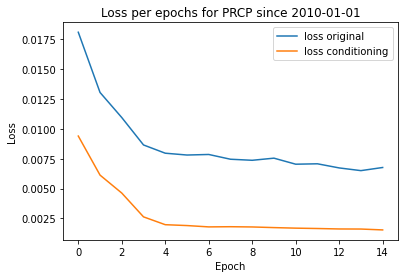

In [ ]:
# plot loss per epochs
plt.plot(history.history['loss'], label='loss original')
plt.plot(history_cond.history['loss'], label='loss conditioning')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title(f'Loss per epochs for PRCP since {train_end_date}')
plt.legend()

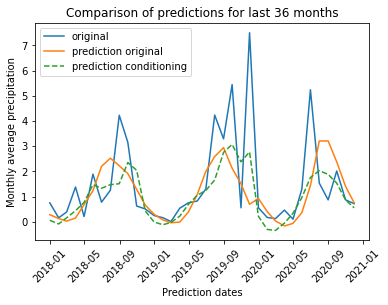

In [ ]:
# plot original with different predictions
plt.plot(df_month.iloc[-36:].index,descale(test_target[-36:],descale_month_prcp),label='original')
plt.plot(df_month.iloc[-36:].index,descale(test_predict[-36:],descale_month_prcp),label='prediction original')
plt.plot(df_month.iloc[-36:].index,descale(test_predict_cond[-36:],descale_month_prcp),'--',label='prediction conditioning')
plt.xticks(rotation=45)
plt.title('Comparison of predictions for last 36 months')
plt.xlabel('Prediction dates')
plt.ylabel('Monthly average precipitation')
plt.legend()

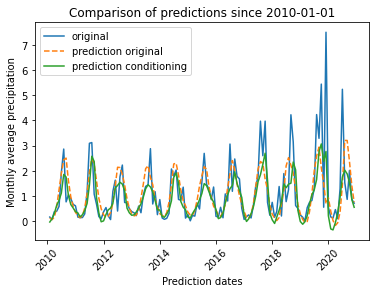

In [ ]:
# length of predictions and targets
n = len(test_target)
# plot original with different predictions
plt.plot(df_month.iloc[-n:].index,descale(test_target,descale_month_prcp),label='original')
plt.plot(df_month.iloc[-n:].index,descale(test_predict,descale_month_prcp),'--',label='prediction original')
plt.plot(df_month.iloc[-n:].index,descale(test_predict_cond,descale_month_prcp),label='prediction conditioning')
plt.xticks(rotation=45)
plt.title(f'Comparison of predictions since {train_end_date}')
plt.xlabel('Prediction dates')
plt.ylabel('Monthly average precipitation')
plt.legend()

In [ ]:
print(f'test loss for original {test_loss}')
print(f'test loss after conditioning {test_loss_cond}')
# real test loss of the predictions using data conditioning
# test_predict_cond is compared with test_target, the real targets
print(f'real test loss after conditioning {mean_squared_error(test_target,test_predict_cond)}')

test loss for original 0.01817263662815094
test loss after conditioning 0.004228394478559494
real test loss after conditioning 0.013059135374992835


Replace negative predictions with zeroes.

In [ ]:
# replace negative predictions after descaling with zeroes
test_predict_cond[test_predict_cond<0]=0

In [ ]:
print(f'test loss for original {test_loss}')
# real test loss of the predictions using data conditioning
# test_predict_cond is compared with test_target, the real targets
print(f'real test loss after conditioning {mean_squared_error(test_target,test_predict_cond)}')

test loss for original 0.01817263662815094
real test loss after conditioning 0.012980938865274471


Using data conditioning, we do get smaller test loss. The predictions using data conditioning are also much complex. In the previous graphs, one can see that the original predictions are just sinusoidal functions.

## 11.3 Comparison of different months in advance

In [ ]:
# months in the history used to predict
windowsize = 36
# training data end date
train_end_date = date(2010,1,1)

# parameters of the model and training
epochs=15
batchsize=50
lstm_neurons=[128]
dense_neurons=[128,1]
act=['linear']*2

# list of predictions and test losses
test_predict_list = []
test_loss_list = []

# loop to predict from 1 to 12 months in advance
# offset from 0 to 11
offset_max = 12
for offset in range(offset_max):
  # train and get predictions, targets and loss
  _,test_predict,test_target,test_loss = train_model(df_month_scaled['PRCP'],windowsize,
                                                         offset,train_end_date,epochs,
                                                     batchsize,lstm_neurons,dense_neurons,act)
  
  # replace negative predictions after descaling with zeroes
  test_predict[test_predict<0]=0

  test_predict_list.append(test_predict)
  test_loss_list.append(test_loss)

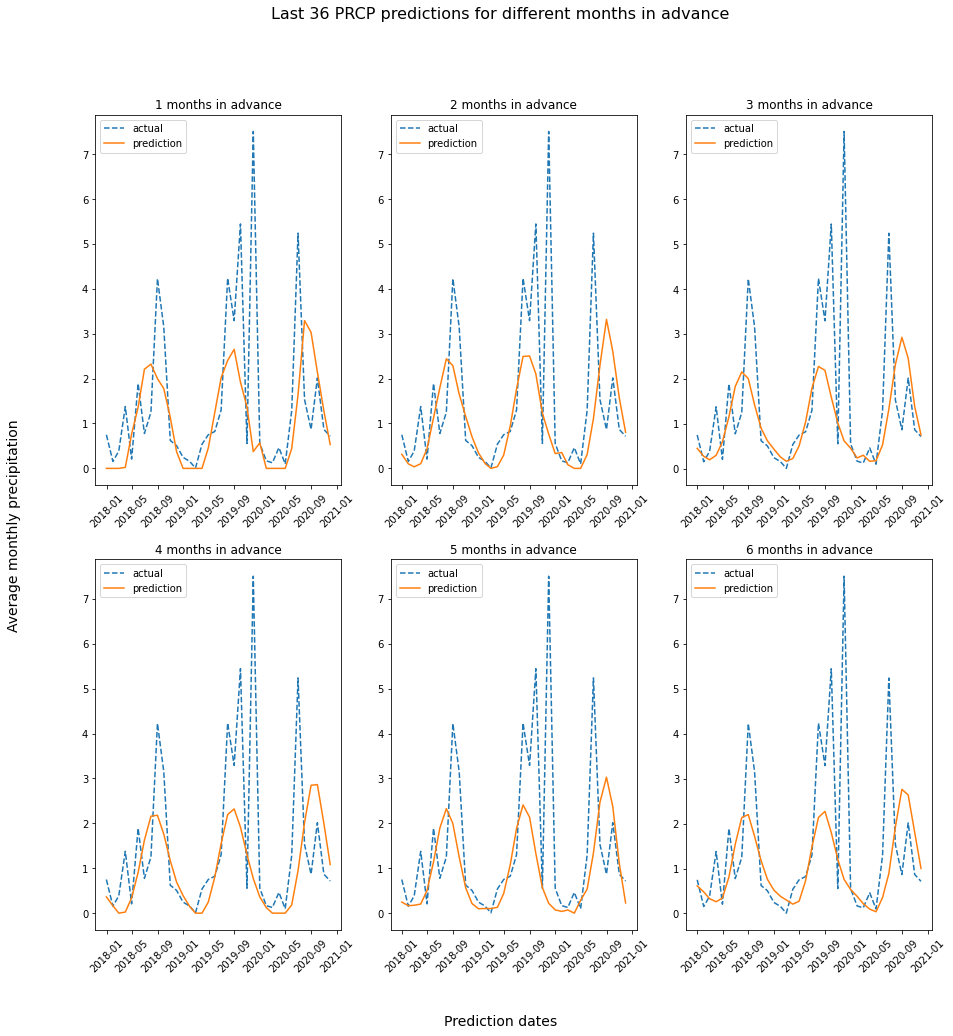

In [ ]:
# last 3 years predictions
n = 36
title = f'Last {n} PRCP predictions for different months in advance'
ytitle = 'Average monthly precipitation'
plot_subplot(df_month,test_predict_list,test_target,descale_month_prcp,title,ytitle,
             np.arange(offset_max),frequency='months',n=n)

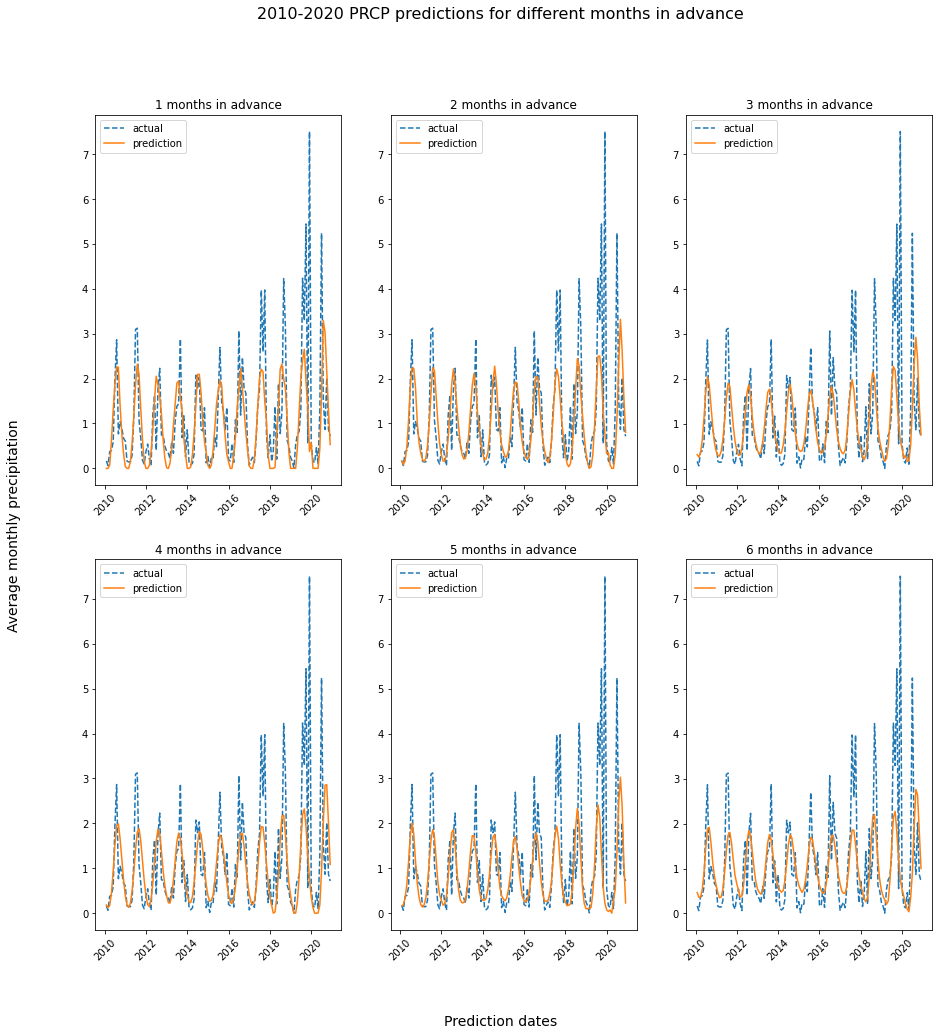

In [ ]:
# 2010-2020 predictions
title = f'2010-2020 PRCP predictions for different months in advance'
plot_subplot(df_month,test_predict_list,test_target,descale_month_prcp,title,
             ytitle,np.arange(offset_max),frequency='months')

Text(0, 0.5, 'Test loss')

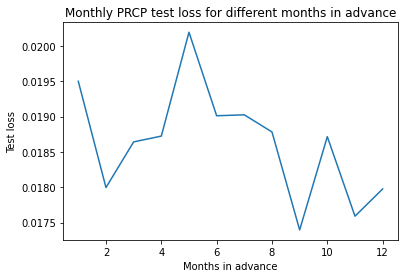

In [ ]:
# plot test loss vs offset
plt.plot(np.arange(1,offset_max+1),test_loss_list)
plt.title('Monthly PRCP test loss for different months in advance')
plt.xlabel('Months in advance')
plt.ylabel('Test loss')

We get quite constant test loss and very similar predictions (sinusoidal predictions) for all cases. These are actually quite bad predictions because these sinusoidal predictions do not really match the targets. I will now use data after data conditoining.

In [ ]:
# list of predictions and test losses
test_predict_list_cond = []
test_loss_list_cond = []
real_test_loss_list_cond = []

# loop to predict from 1 to 12 months in advance
# offset from 0 to 11
offset_max = 12
for offset in range(offset_max):
  # train and get predictions and loss
  _,test_predict,_,test_loss = train_model(df_month_prcp_cond,windowsize,offset,train_end_date,
                                           epochs,batchsize,lstm_neurons,dense_neurons,act)
  
  # replace negative predictions after descaling with zeroes
  test_predict[test_predict<0]=0

  test_predict_list_cond.append(test_predict)
  test_loss_list_cond.append(test_loss)
  # real test loss
  real_test_loss_list_cond.append(mean_squared_error(test_target,test_predict))

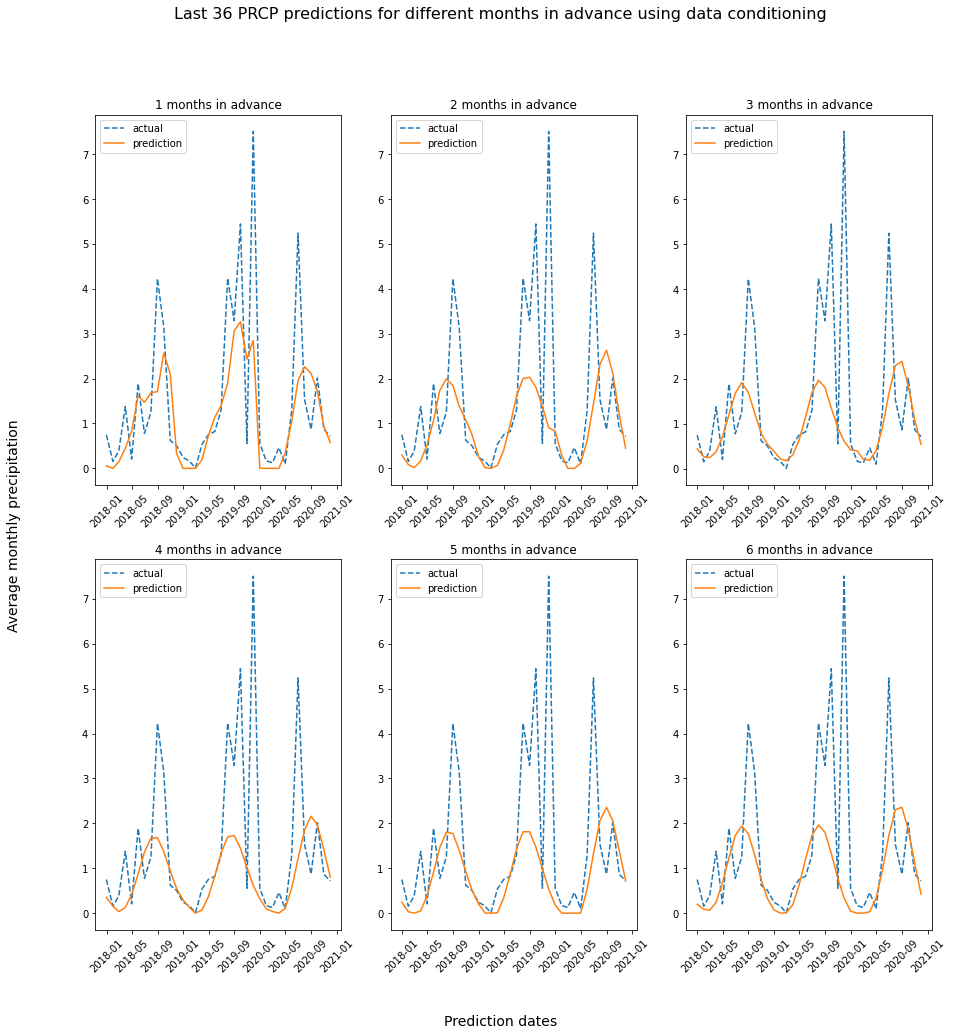

In [ ]:
# last 3 years predictions
title = f'Last {n} PRCP predictions for different months in advance using data conditioning'
plot_subplot(df_month,test_predict_list_cond,test_target,descale_month_prcp,title,ytitle,
             np.arange(offset_max),frequency='months',n=n)

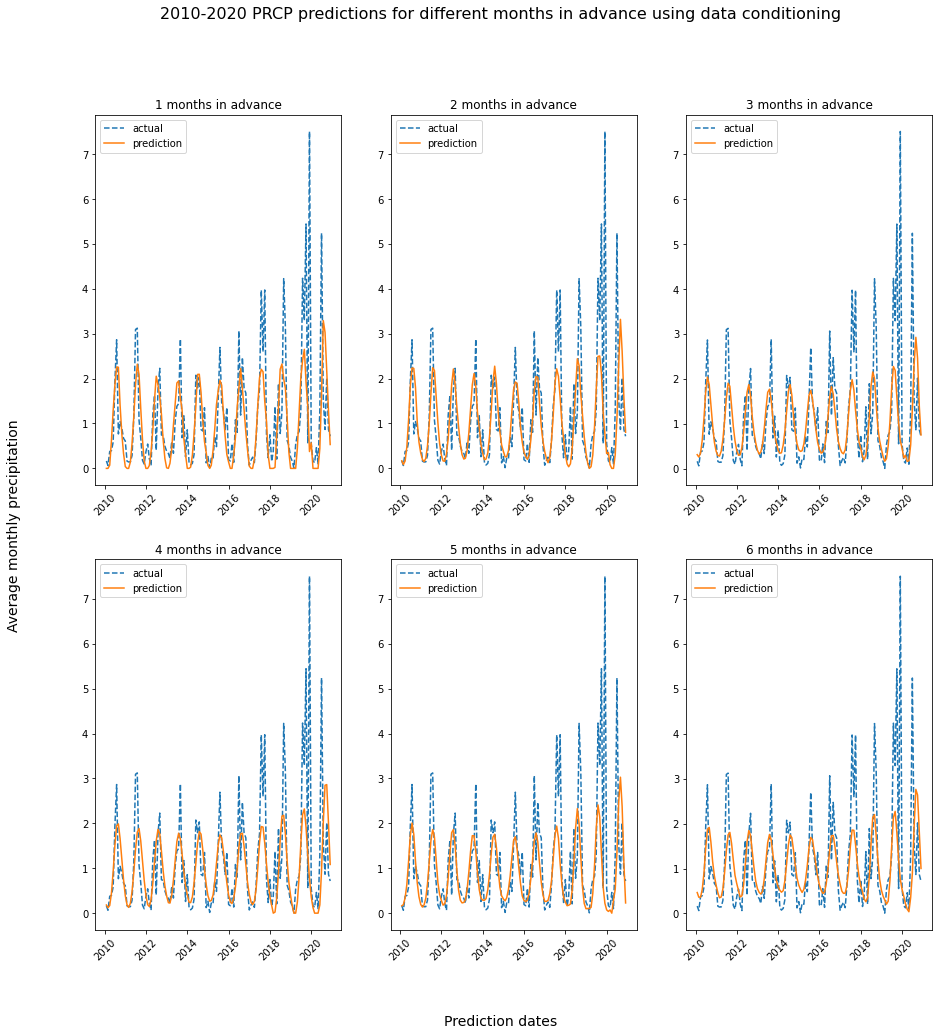

In [ ]:
# 2010-2020 years predictions
title = f'2010-2020 PRCP predictions for different months in advance using data conditioning'
plot_subplot(df_month,test_predict_list,test_target,descale_month_prcp,title,
             ytitle,np.arange(offset_max),frequency='months')

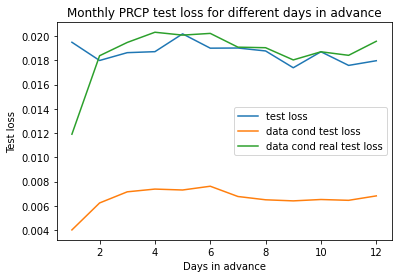

In [ ]:
# plot test loss vs offset
plt.plot(np.arange(1,offset_max+1),test_loss_list,label='test loss')
plt.plot(np.arange(1,offset_max+1),test_loss_list_cond,label='data cond test loss')
plt.plot(np.arange(1,offset_max+1),real_test_loss_list_cond,label='data cond real test loss')
plt.title('Monthly PRCP test loss for different days in advance')
plt.xlabel('Days in advance')
plt.ylabel('Test loss')
plt.legend()

As showns previously, for one day in advance and using data conditioning, we get slightly better predictions, we do not simply get sinusoidal predictions. To prove that for 2 months in advance we can't get decent predictions, I will use a very complex model.

In [ ]:
# months in the history used to predict
windowsize = 36
# 2 months in advance
offset = 1
# training data end date
train_end_date = date(2010,1,1)

# parameters of the model and training
epochs=10
batchsize=50
# two LSTM layers with 128,128 neurons
lstm_neurons=[128,128]
# three dense hidden layers with 128,128,64 neurons
# one dense output layer with 1 neuron
dense_neurons = [128,128,64,1]
# use linear act function for all dense layers
act = ['linear']*4

# train and return hisotry, predictions, loss
history,test_predict,_,test_loss = train_model(df_month_prcp_cond,windowsize,offset,train_end_date,
                                         epochs,batchsize,lstm_neurons,
                                         dense_neurons,act)

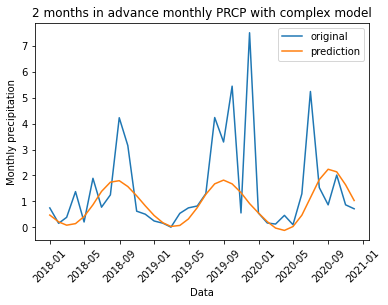

In [ ]:
# plot predictions of the last 36 months for original data
plt.plot(df_month.iloc[-36:].index,descale(test_target[-36:],descale_month_prcp),label='original')
plt.plot(df_month.iloc[-36:].index,descale(test_predict[-36:],descale_month_prcp),label='prediction')
plt.xticks(rotation=45)
plt.title(f'{offset+1} months in advance monthly PRCP with complex model')
plt.xlabel('Data')
plt.ylabel('Monthly precipitation')
plt.legend()

In [ ]:
# this test_target is the real target, not the data after data conditioning
print(f'loss = {mean_squared_error(test_target,test_predict)}')

loss = 0.019410945899941686


The predictions still look sinusoidal and the test loss is not lowered. One again, this can be a proof that the current model is enough. To sum up, for monthly precipitations, we can only predict decently one month in advance (using data conditioning). To see why this is the case, I will plot the montly average rainfall for the whole range.

Text(0.5, 1.0, 'Monthly PRCP for the whole range')

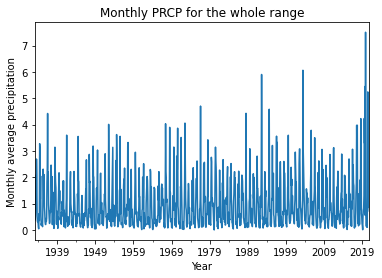

In [ ]:
df_month.PRCP.plot()
plt.xlabel('Year')
plt.ylabel('Monthly average precipitation')
plt.title('Monthly PRCP for the whole range')

We can't really see a patter for the maximum monthly rainfall per year. By using rainfall historical data, we can't predict very accurately this maximum. 

# 12. SUMMARY AND FUTURE WORK

To sum up, we've seen that data conditioning has been crucial to improve the performance. To think the reason of this, one might consider that data conditioning is a way of removing outliers. Actually, these filters (median and gaussian) are used to remove noise. Therefore, one can consider data conditioning as part of data pre-processing. 

To improve this work, one might consider adding more variables in the input data. I have actually tried this but not systematically. The first impression is that it does not really improve the performance, but one needs a more detail reseach on this. One can also use other near stations data and see if we can get better predictions.

## 12.1 Report figures

I will now create some figures used in the report. I will now compare the predictions to the data after data conditioning (after moving the noise), not to the raw data. As the report is limited to 15 pages, I will only show the predictions for the first three days/months in advance, as for the most cases, one can only predict 1 or 2 days/months in advance (as seen previously). Note: I have printed the time taken to run for each case (I am using Google Colab with GPU)


I will also plot the MSE (mean squared error). However, to compare between daily and monthly temperature and precipitation, I will use the coefficient of determination (R squared). Because one might notice that daily precipitation predictions have very small MSE but they are the worst predictions (according to R squared). To calculate the MSE and R squared, I will run from 1 to 12 days/months in advance. Moreover, for each offset, I will run multiple times to reduce fluctuations. For daily predictions, I will run each offset 5 times; for monthly predictions 10 times. This is because daily predictions take much more time to train (there are 30 times more data).

In [ ]:
# import time
from time import time

In [ ]:
def plot_subplot3(df,predictions,targets,descale_var,title,ytitle,offset_array,frequency='days',n=None):
  ''''Create figure of 3 subplots showing predictions and original targets
  Each subplot shows predictions with different amount of time in advance
  This function is created to create figures for the report
  Inputs:
          df: dataframe used to get indices (dates)
          predictions: list of predictions
                        predictions[i] are predictions of i-th subplot
          targets: original data
          descale_var: object used to descale back the predictions and targets
          title: main title of figure
          ytitle: main ylabel
          offset_array: array of offsets, eg offset_array=[0,1,2,3,4,5] represents
                        1 to 6 days/months in advance
                        1 day/month in advance for first subplot and so on
          frequency: days or months, default days
          n: number of data points to be plotted
             default None, in which case use all data points
  '''
  # if n is None, use all data points
  if n == None:
    n = len(targets)

  # create figure
  fig = plt.figure(figsize=(15,8))
  # common title
  fig.suptitle(title,size=18)
  # common xlabel and ylabel
  fig.text(0.5,0.04, 'Prediction dates', ha="center", va="center",size=16)
  fig.text(0.05,0.5, ytitle, ha="center", va="center", rotation=90,size=16)

  # six subplots
  for i in range(3):
    ax = fig.add_subplot(131+i)
    # plot predictions and targets after descaling
    ax.plot(df.iloc[-n:].index,descale(targets[-n:],descale_var),'--',label='actual')
    ax.plot(df.iloc[-n:].index,descale(predictions[i][-n:],descale_var),label='prediction')

    # set subplot title 
    ax.set_title(f'{offset_array[i]+1} {frequency} in advance',size=16)
    # rotate x labels (dates)
    plt.setp(ax.get_xticklabels(), rotation=90)
    # increase x labels size
    for tick in ax.xaxis.get_major_ticks():
      tick.label.set_fontsize(14) 
    # increase y labels size
    for tick in ax.yaxis.get_major_ticks():
      tick.label.set_fontsize(14) 

    # set legend
    ax.legend()

  # increase space for x labels
  fig.subplots_adjust(bottom=0.22)

For daily temperatures

In [ ]:
# days in the history used to predict
windowsize = 60
# training data end date
train_end_date = date(2020,1,1)
# parameters of the model and training
epochs=10
batchsize=100
lstm_neurons=[128,64]

# list of predictions
test_predict_list = []

# set start time
start = time()

# loop to predict from 1 to 3 days in advance
# offset from 0 to 2
offset_max = 3
for offset in range(offset_max):
  # train and get predictions and targets
  _,test_predict,test_target,_ = train_model(df_tavg_cond,windowsize,offset,train_end_date,
                                      epochs,batchsize,lstm_neurons)
  # append predictions
  test_predict_list.append(test_predict)

print(f'time taken: {time()-start}s')

time taken: 75.551020860672s


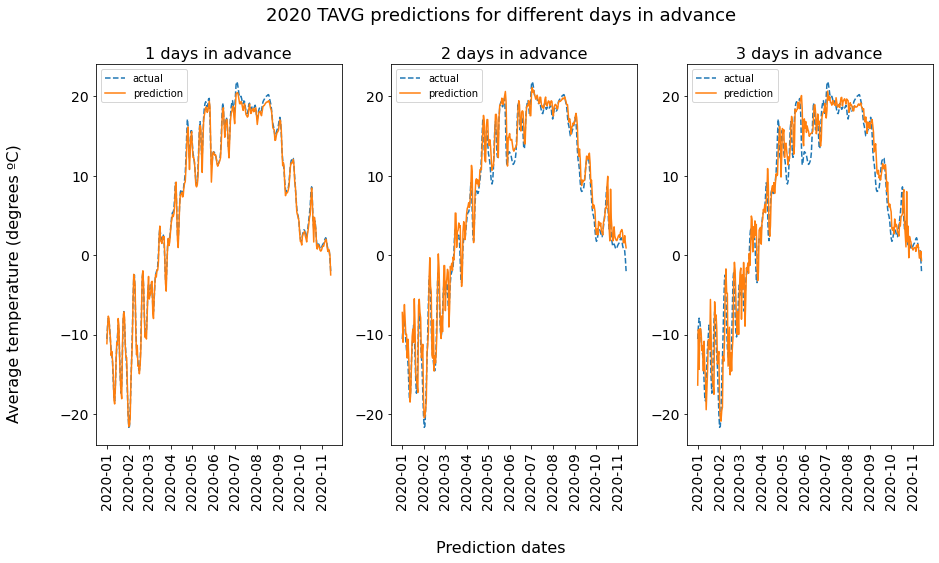

In [ ]:
# 2020 TAVG predictions comparison
title = '2020 TAVG predictions for different days in advance'
ytitle = 'Average temperature (degrees ºC)'
plot_subplot3(df,test_predict_list,test_target,descale_tavg,title,ytitle,np.arange(offset_max))

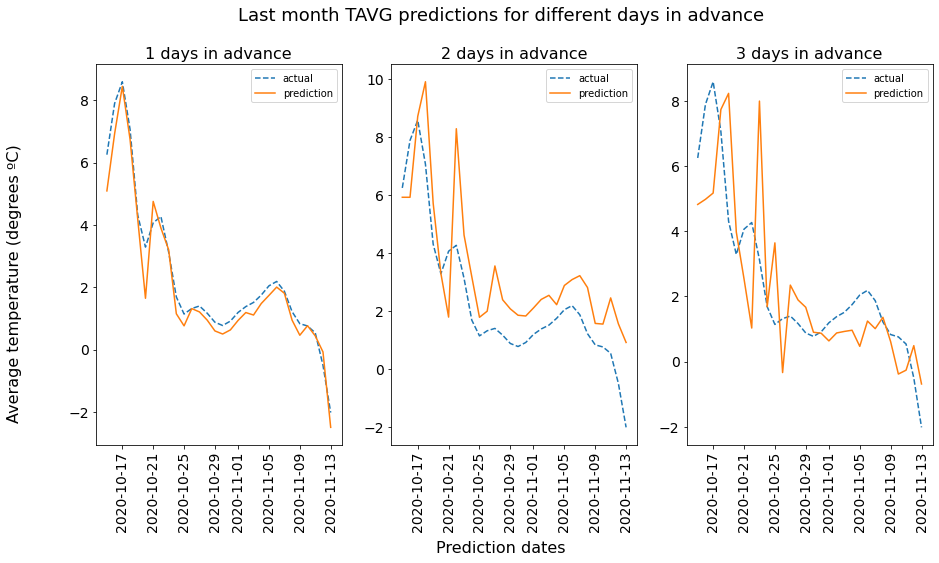

In [ ]:
# last month TAVG predictions comparison
n = 30
title = f'Last month TAVG predictions for different days in advance'
plot_subplot3(df,test_predict_list,test_target,descale_tavg,title,ytitle,
             np.arange(offset_max),n=n)

For monthly temperatures

In [ ]:
# months in the history used to predict
windowsize = 36
# training data end date
train_end_date = date(2010,1,1)
# parameters of the model and training
epochs=15
batchsize=50
lstm_neurons=[128]

# list of predictions
test_predict_list = []

# set start time
start = time()

# loop to predict from 1 to 3 months in advance
# offset from 0 to 2
offset_max = 3
for offset in range(offset_max):
  # train and get predictions and targets
  _,test_predict,test_target,_ = train_model(df_month_tavg_cond,windowsize,offset,train_end_date,
                                   epochs,batchsize,lstm_neurons)
  # append predictions
  test_predict_list.append(test_predict)

print(f'time taken: {time()-start}s')

time taken: 9.236173868179321s


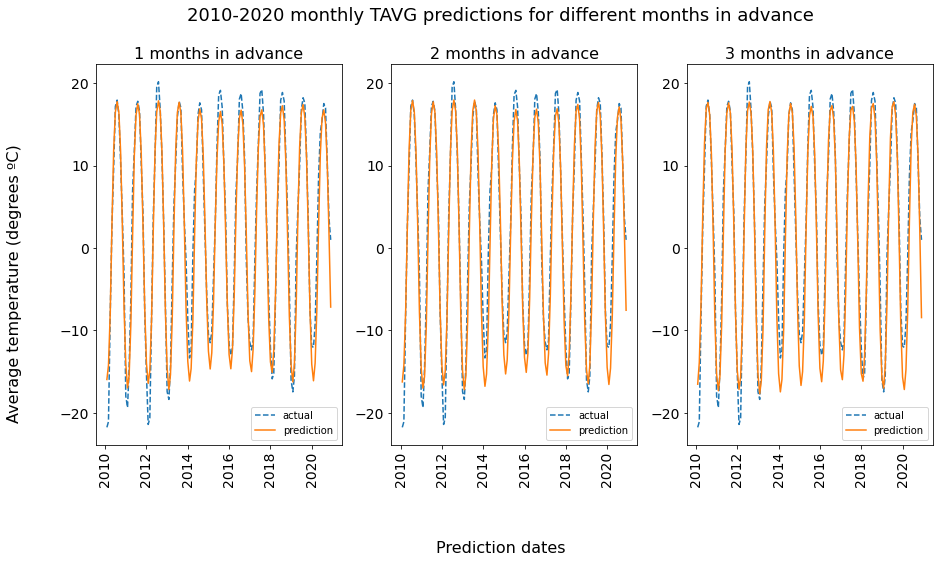

In [ ]:
# 2010-2020 predictions comparison
title = '2010-2020 monthly TAVG predictions for different months in advance'
ytitle = 'Average temperature (degrees ºC)'
plot_subplot3(df_month,test_predict_list,test_target,descale_month_tavg,title,
             ytitle,np.arange(offset_max),frequency='months')

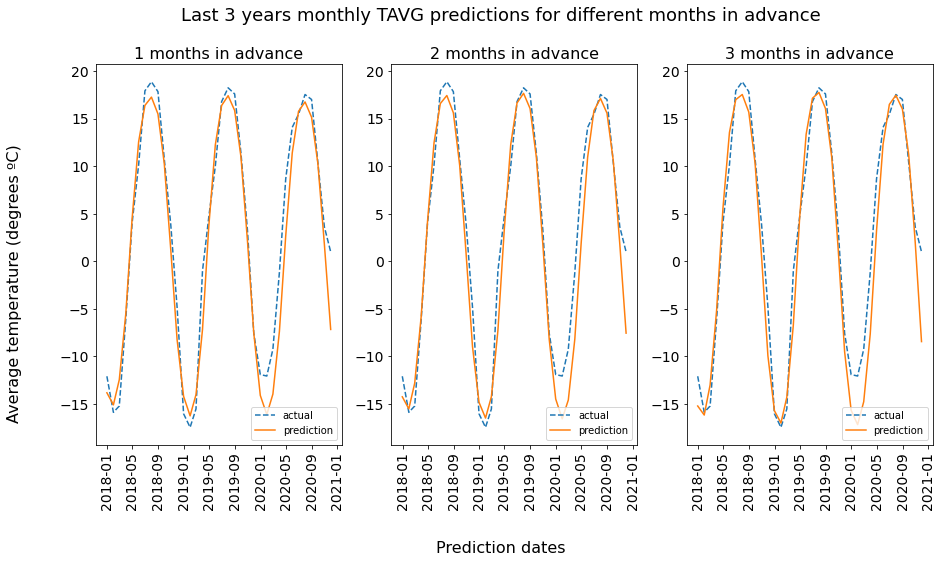

In [ ]:
# last 3 years monthly TAVG predictions comparison
n = 36
title = 'Last 3 years monthly TAVG predictions for different months in advance'
plot_subplot3(df_month,test_predict_list,test_target,descale_month_tavg,title,ytitle,
             np.arange(offset_max),frequency='months',n=n)

For daily precipitation

In [ ]:
# days in the history used to predict
windowsize = 60
# training data end date
train_end_date = date(2020,1,1)
# parameters of the model and training
epochs=10
batchsize=100
lstm_neurons=[128]

# list of predictions
test_predict_list = []

# set start time
start = time()

# loop to predict from 1 to 3 days in advance
# offset from 0 to 2
offset_max = 3
for offset in range(offset_max):
  # train and get predictions and targets
  _,test_predict,test_target,_ = train_model(df_prcp_cond,windowsize,offset,train_end_date,
                                      epochs,batchsize,lstm_neurons,act=['linear'])
  # replace negative predictions with zeroes
  test_predict[test_predict<0]=0

  # append predictions
  test_predict_list.append(test_predict)

print(f'time taken: {time()-start}s')

time taken: 45.13294863700867s


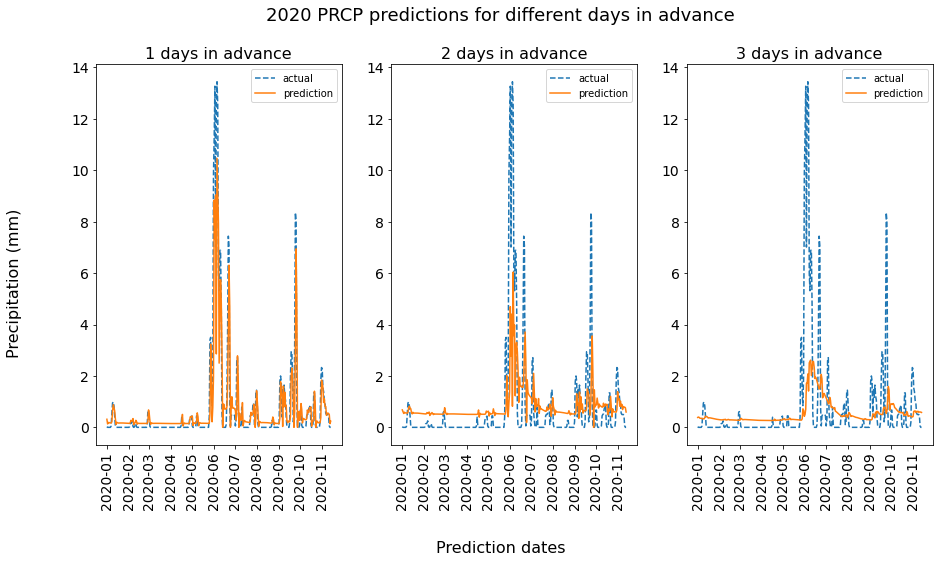

In [ ]:
# 2020 PRCP predictions comparison
title = '2020 PRCP predictions for different days in advance'
ytitle = 'Precipitation (mm)'
plot_subplot3(df,test_predict_list,test_target,descale_prcp,title,ytitle,np.arange(offset_max))

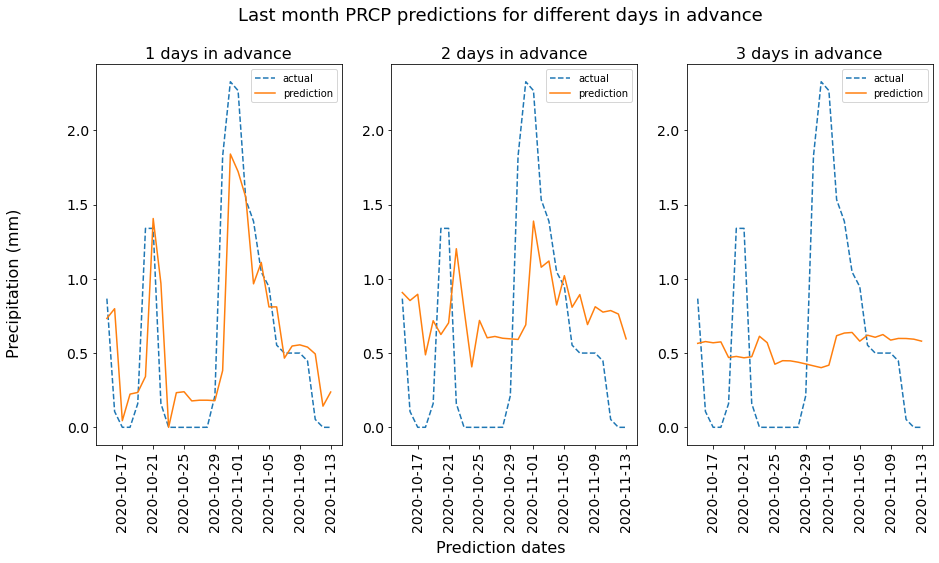

In [ ]:
# last month TAVG predictions comparison
n = 30
title = f'Last month PRCP predictions for different days in advance'
plot_subplot3(df,test_predict_list,test_target,descale_prcp,title,ytitle,
             np.arange(offset_max),n=n)

For monthly precipitation

In [ ]:
# months in the history used to predict
windowsize = 36
# training data end date
train_end_date = date(2010,1,1)
# parameters of the model and training
epochs=15
batchsize=50
lstm_neurons=[128]
dense_neurons=[128,1]
act=['linear']*2

# list of predictions
test_predict_list = []

# set start time
start = time()

# loop to predict from 1 to 3 months in advance
# offset from 0 to 2
offset_max = 3
for offset in range(offset_max):
  # train and get predictions and targets
  _,test_predict,test_target,_ = train_model(df_month_prcp_cond,windowsize,offset,train_end_date,
                                   epochs,batchsize,lstm_neurons,dense_neurons,act)
  
  # replace negative predictions with zeroes
  test_predict[test_predict<0]=0

  # append predictions
  test_predict_list.append(test_predict)

print(f'time taken: {time()-start}s')

time taken: 9.244824886322021s


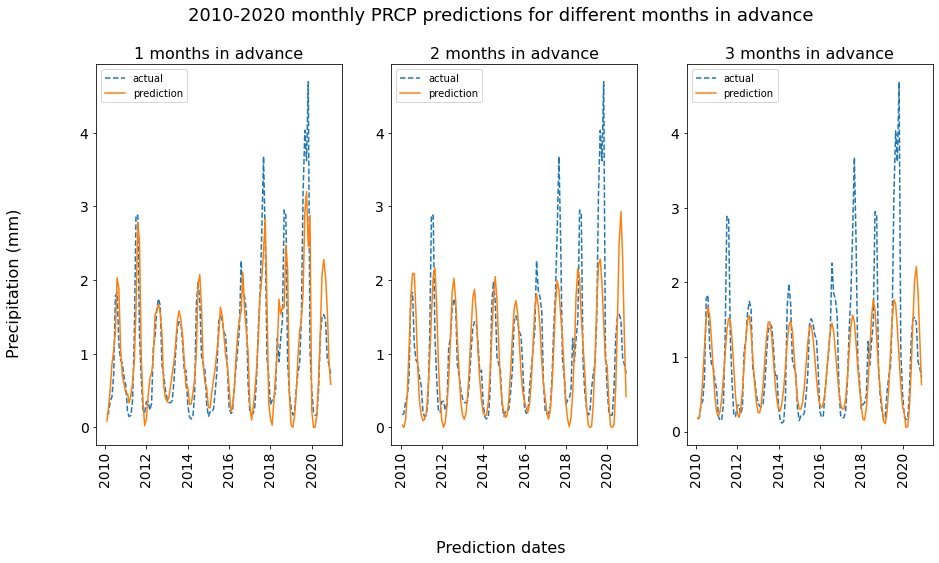

In [ ]:
# 2010-2020 monthly PRCP predictions comparison
title = '2010-2020 monthly PRCP predictions for different months in advance'
ytitle = 'Precipitation (mm)'
plot_subplot3(df_month,test_predict_list,test_target,descale_month_prcp,title,
             ytitle,np.arange(offset_max),frequency='months')

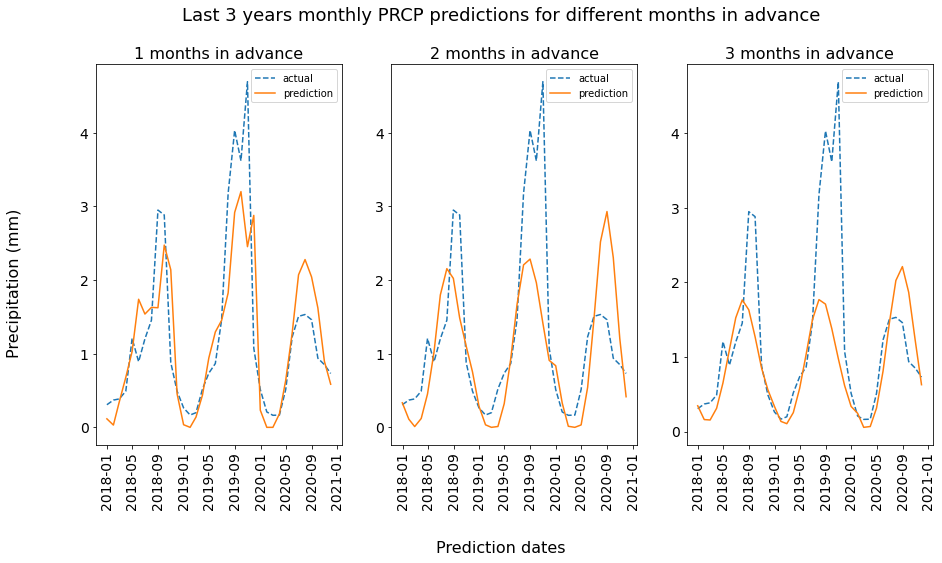

In [ ]:
# last 3 years monthly PRCP predictions comparison
n = 36
title = 'Last 3 years monthly PRCP predictions for different months in advance'
plot_subplot3(df_month,test_predict_list,test_target,descale_month_prcp,title,ytitle,
             np.arange(offset_max),frequency='months',n=n)

Now I will calculate the MSE and R squared.

For daily TAVG (12x5=60 models in total, around 1600s to run)

In [ ]:
# days in the history used to predict
windowsize = 60
# training data end date
train_end_date = date(2020,1,1)
# parameters of the model and training
epochs=10
batchsize=100
lstm_neurons=[128,64]

# mean squared errors and r2
mse_tavg_array = np.zeros((5,12))
r2_tavg_array = np.zeros((5,12))

# loop 5 times
for i in range(5):
  # loop to predict from 1 to 12 days in advance
  for offset in range(offset_max):
    # train and get predictions, targets and loss
    _,test_predict,test_target,test_loss = train_model(df_tavg_cond,windowsize,offset,train_end_date,
                                        epochs,batchsize,lstm_neurons)
    # mean squared errors and r2
    mse_tavg_array[i,offset] = test_loss
    r2_tavg_array[i,offset] = r2_score(test_target,test_predict)

For monthly TAVG (12x10=120 models in total, around 350s to run)

In [ ]:
# months in the history used to predict
windowsize = 36
# training data end date
train_end_date = date(2010,1,1)
# parameters of the model and training
epochs=15
batchsize=50
lstm_neurons=[128]

# mean squared errors and r2
mse_month_tavg_array = np.zeros((10,12))
r2_month_tavg_array = np.zeros((10,12))

# loop 10 times
for i in range(10):
  # loop to predict from 1 to 12 months in advance
  for offset in range(offset_max):
    # train and get predictions, targets and loss
    _,test_predict,test_target,test_loss = train_model(df_month_tavg_cond,windowsize,offset,train_end_date,
                                    epochs,batchsize,lstm_neurons)
    # mean squared errors and r2
    mse_month_tavg_array[i,offset] = test_loss
    r2_month_tavg_array[i,offset] = r2_score(test_target,test_predict)

For daily PRCP (12x5=60 models in total, around 1300s to run)

In [ ]:
# days in the history used to predict
windowsize = 60
# training data end date
train_end_date = date(2020,1,1)
# parameters of the model and training
epochs=10
batchsize=100
lstm_neurons=[128]

# mean squared errors and r2
mse_prcp_array = np.zeros((5,12))
r2_prcp_array = np.zeros((5,12))

# loop 5 times
for i in range(5):
  # loop to predict from 1 to 12 days in advance
  for offset in range(offset_max):
    # train and get predictions and targets
    _,test_predict,test_target,_ = train_model(df_prcp_cond,windowsize,offset,train_end_date,
                                        epochs,batchsize,lstm_neurons,act=['linear'])
    # replace negative predictions with zeroes
    test_predict[test_predict<0]=0

    # mean squared errors and r2
    mse_prcp_array[i,offset] = mean_squared_error(test_target,test_predict)
    r2_prcp_array[i,offset] = r2_score(test_target,test_predict)

For monthly PRCP (12x10=120 models in total, around 350s to run)

In [ ]:
# months in the history used to predict
windowsize = 36
# training data end date
train_end_date = date(2010,1,1)
# parameters of the model and training
epochs=15
batchsize=50
lstm_neurons=[128]
dense_neurons=[128,1]
act=['linear']*2

# mean squared errors and r2
mse_month_prcp_array = np.zeros((10,12))
r2_month_prcp_array = np.zeros((10,12))

# loop 10 times
for i in range(10):
  # loop to predict from 1 to 12 months in advance
  for offset in range(offset_max):
    # train and get predictions and targets
    _,test_predict,test_target,_ = train_model(df_month_prcp_cond,windowsize,offset,train_end_date,
                                    epochs,batchsize,lstm_neurons,dense_neurons,act)
    
    # replace negative predictions with zeroes
    test_predict[test_predict<0]=0

    # mean squared errors and r2
    mse_month_prcp_array[i,offset] = mean_squared_error(test_target,test_predict)
    r2_month_prcp_array[i,offset] = r2_score(test_target,test_predict)

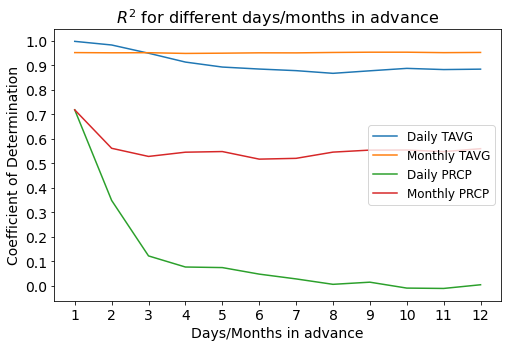

In [11]:
# plot maximum of R squared arrays for each model
plt.figure(figsize=(8,5))
plt.plot(np.arange(1,offset_max+1),np.max(r2_tavg_array,axis=0),label='Daily TAVG')
plt.plot(np.arange(1,offset_max+1),np.max(r2_month_tavg_array,axis=0),label='Monthly TAVG')
plt.plot(np.arange(1,offset_max+1),np.max(r2_prcp_array,axis=0),label='Daily PRCP')
plt.plot(np.arange(1,offset_max+1),np.max(r2_month_prcp_array,axis=0),label='Monthly PRCP')
plt.xlabel('Days/Months in advance',size=14)
plt.ylabel('Coefficient of Determination',size=14)
plt.title(r'$R^2$ for different days/months in advance',size=16)
# x and y labels
plt.xticks(np.arange(1,offset_max+1),fontsize=14)
plt.yticks(np.linspace(0,1,11),fontsize=14)
plt.legend(loc='right',fontsize=12)

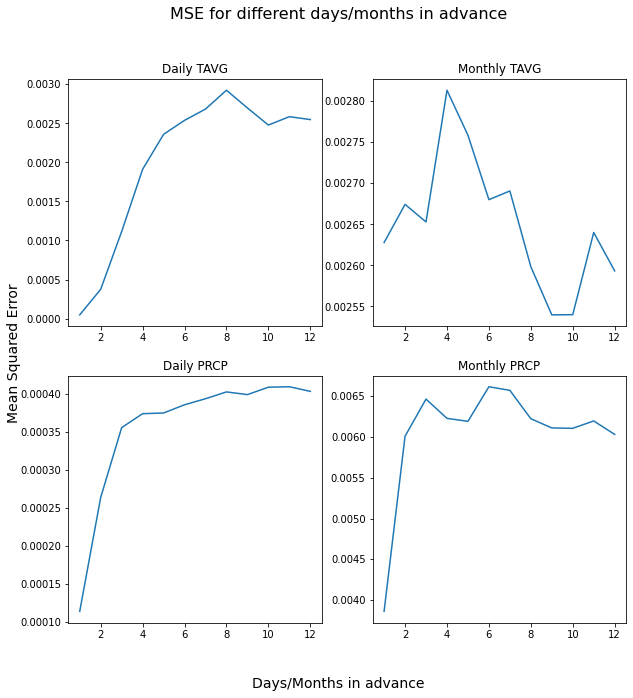

In [ ]:
# plot minimum of MSE arrays for each model

# create figure
fig = plt.figure(figsize=(10,10))
# common title
fig.suptitle('MSE for different days/months in advance',size=16)
# common xlabel and ylabel
fig.text(0.5,0.04, 'Days/Months in advance', ha="center", va="center",size=14)
fig.text(0.05,0.5, 'Mean Squared Error', ha="center", va="center", rotation=90,size=14)

# list of subplot titles
sub_titles = ['Daily TAVG','Monthly TAVG','Daily PRCP','Monthly PRCP']

# six subplots
for i,mse_list in enumerate([np.min(mse_tavg_array,0),np.min(mse_month_tavg_array,0),
                             np.min(mse_prcp_array,0),np.min(mse_month_prcp_array,0)]):
  ax = fig.add_subplot(221+i)
  # plot predictions and targets after descaling
  ax.plot(np.arange(1,offset_max+1),mse_list)
  # set subplot title 
  ax.set_title(sub_titles[i])

Lastly, I will print the r2 and MSE manually, to just have a record of these results.

In [ ]:
np.max(r2_tavg_array,axis=0)

array([0.99784835, 0.9830123 , 0.94947678, 0.91332959, 0.89301114,
       0.8848921 , 0.87833195, 0.86739494, 0.87769043, 0.88762517,
       0.88275449, 0.8844428 ])

In [ ]:
np.max(r2_month_tavg_array,axis=0)

array([0.9519956 , 0.95114642, 0.95153719, 0.94860754, 0.94960813,
       0.95104139, 0.9508479 , 0.95253216, 0.95360361, 0.95359971,
       0.95177161, 0.95262562])

In [ ]:
np.max(r2_prcp_array,axis=0)

array([ 0.71847284,  0.34894166,  0.12249999,  0.07721515,  0.07493095,
        0.04826956,  0.02867558,  0.00658294,  0.01537177, -0.00876665,
       -0.01020426,  0.00483176])

In [ ]:
np.max(r2_month_prcp_array,axis=0)

array([0.71837005, 0.56163469, 0.52838627, 0.54565845, 0.5482693 ,
       0.51733733, 0.52056963, 0.54596502, 0.55420972, 0.55454781,
       0.54794167, 0.5599975 ])

In [ ]:
np.min(mse_tavg_array,axis=0)

array([4.74442277e-05, 3.74582014e-04, 1.11404702e-03, 1.91109953e-03,
       2.35912553e-03, 2.53815157e-03, 2.68280436e-03, 2.92396732e-03,
       2.69694999e-03, 2.47788662e-03, 2.58528651e-03, 2.54805898e-03])

In [ ]:
np.min(mse_month_tavg_array,axis=0)

array([0.00262778, 0.00267427, 0.00265288, 0.00281325, 0.00275848,
       0.00268002, 0.00269061, 0.00259841, 0.00253976, 0.00253997,
       0.00264005, 0.0025933 ])

In [ ]:
np.min(mse_prcp_array,axis=0)

array([0.00011398, 0.0002636 , 0.00035528, 0.00037361, 0.00037454,
       0.00038533, 0.00039326, 0.00040221, 0.00039865, 0.00040842,
       0.000409  , 0.00040292])

In [ ]:
np.min(mse_month_prcp_array,axis=0)

array([0.00386074, 0.00600936, 0.00646515, 0.00622837, 0.00619258,
       0.00661662, 0.00657231, 0.00622417, 0.00611115, 0.00610651,
       0.00619707, 0.00603181])